In [73]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [74]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco


pd.set_option('display.max_columns', None)

In [75]:
appl_train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
prev_appl = pd.read_csv("previous_application.csv")

Есть ли требование о том, что банк должен объяснять, почему отказали в кредите?

Банки не обязаны сообщать заёмщику, почему была отклонена его кредитная заявка, но это не значит, что причину узнать невозможно. По закону финансовые учреждения должны сообщать в бюро кредитных историй (БКИ) причину отказа. Соответственно, интерпретируемость модели это преимущество, но не обязательное требование.

In [76]:
appl_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [77]:
# Из всех полдей заявки следует убрать следующие:
# a.	Не актуальны российскому рынку
# b.	Невозможно достать путём опроса
# c.	Кодированы
# d.	Не интерпретируемы



columns_to_drop = [
 #'SK_ID_CURR',
 #'TARGET',
 'NAME_CONTRACT_TYPE', # возобновляемость кредита, не применимо для ипотеки в России
 #'CODE_GENDER',
 #'FLAG_OWN_CAR',
 #'FLAG_OWN_REALTY',
 #'CNT_CHILDREN',
 #'AMT_INCOME_TOTAL',
 #'AMT_CREDIT',
 # 'AMT_ANNUITY',  # размер аннуиттентного платежа. Позволит вычислить срок кредита
 'AMT_GOODS_PRICE', # цена товара, характеристика потребительского кредита
 #'NAME_TYPE_SUITE',
 #'NAME_INCOME_TYPE',
 #'NAME_EDUCATION_TYPE',
 #'NAME_FAMILY_STATUS',
 #'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE', #относительная популярность зарубежного региона без специфики
 #'DAYS_BIRTH',
 #'DAYS_EMPLOYED',
 #'DAYS_REGISTRATION',
 #'DAYS_ID_PUBLISH',
 #'OWN_CAR_AGE',
 #'FLAG_MOBIL',
 #'FLAG_EMP_PHONE',
 #'FLAG_WORK_PHONE',
 #'FLAG_CONT_MOBILE',
 #'FLAG_PHONE',
 #'FLAG_EMAIL',
 #'OCCUPATION_TYPE',
 #'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT', # рейтинг региона из соревнования, интересен, но не важен в терминах задачи
 'REGION_RATING_CLIENT_W_CITY', # рейтинг города из соревнования, интересен, но не важен в терминах задачи
 #'WEEKDAY_APPR_PROCESS_START',
 #'HOUR_APPR_PROCESS_START',
 #'REG_REGION_NOT_LIVE_REGION',
 #'REG_REGION_NOT_WORK_REGION',
 #'LIVE_REGION_NOT_WORK_REGION',
 #'REG_CITY_NOT_LIVE_CITY',
 #'REG_CITY_NOT_WORK_CITY',
 #'LIVE_CITY_NOT_WORK_CITY',
 #'ORGANIZATION_TYPE',
 'EXT_SOURCE_1', # кодированные колонки
 'EXT_SOURCE_2', # кодированные колонки
 'EXT_SOURCE_3', # кодированные колонки
    # блок данных про недвижимость клиента. Может быть модифицирован после первых итераций построения модели
 #'APARTMENTS_AVG',
 #'BASEMENTAREA_AVG',
 #'YEARS_BEGINEXPLUATATION_AVG',
 #'YEARS_BUILD_AVG',
 #'COMMONAREA_AVG',
 #'ELEVATORS_AVG',
 #'ENTRANCES_AVG',
 #'FLOORSMAX_AVG',
 #'FLOORSMIN_AVG',
 #'LANDAREA_AVG',
 #'LIVINGAPARTMENTS_AVG',
 #'LIVINGAREA_AVG',
 #'NONLIVINGAPARTMENTS_AVG',
 #'NONLIVINGAREA_AVG',
 #'APARTMENTS_MODE',
 #'BASEMENTAREA_MODE',
 #'YEARS_BEGINEXPLUATATION_MODE',
 #'YEARS_BUILD_MODE',
 #'COMMONAREA_MODE',
 #'ELEVATORS_MODE',
 #'ENTRANCES_MODE',
 #'FLOORSMAX_MODE',
 #'FLOORSMIN_MODE',
 #'LANDAREA_MODE',
 #'LIVINGAPARTMENTS_MODE',
 #'LIVINGAREA_MODE',
 #'NONLIVINGAPARTMENTS_MODE',
 #'NONLIVINGAREA_MODE',
 #'APARTMENTS_MEDI',
 #'BASEMENTAREA_MEDI',
 #'YEARS_BEGINEXPLUATATION_MEDI',
 #'YEARS_BUILD_MEDI',
 #'COMMONAREA_MEDI',
 #'ELEVATORS_MEDI',
 #'ENTRANCES_MEDI',
 #'FLOORSMAX_MEDI',
 #'FLOORSMIN_MEDI',
 #'LANDAREA_MEDI',
 #'LIVINGAPARTMENTS_MEDI',
 #'LIVINGAREA_MEDI',
 #'NONLIVINGAPARTMENTS_MEDI',
 #'NONLIVINGAREA_MEDI',
 #'FONDKAPREMONT_MODE',
 #'HOUSETYPE_MODE',
 #'TOTALAREA_MODE',
 #'WALLSMATERIAL_MODE',
 #'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 'DEF_30_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 'OBS_60_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 'DEF_60_CNT_SOCIAL_CIRCLE', # различные показатели количества дефолтов в окружении клиента
 #'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2', # кодированные колонки
 'FLAG_DOCUMENT_3', # кодированные колонки
 'FLAG_DOCUMENT_4', # кодированные колонки
 'FLAG_DOCUMENT_5', # кодированные колонки
 'FLAG_DOCUMENT_6', # кодированные колонки
 'FLAG_DOCUMENT_7', # кодированные колонки
 'FLAG_DOCUMENT_8', # кодированные колонки
 'FLAG_DOCUMENT_9', # кодированные колонки
 'FLAG_DOCUMENT_10', # кодированные колонки
 'FLAG_DOCUMENT_11', # кодированные колонки
 'FLAG_DOCUMENT_12', # кодированные колонки
 'FLAG_DOCUMENT_13', # кодированные колонки
 'FLAG_DOCUMENT_14', # кодированные колонки
 'FLAG_DOCUMENT_15', # кодированные колонки
 'FLAG_DOCUMENT_16', # кодированные колонки
 'FLAG_DOCUMENT_17', # кодированные колонки
 'FLAG_DOCUMENT_18', # кодированные колонки
 'FLAG_DOCUMENT_19', # кодированные колонки
 'FLAG_DOCUMENT_20', # кодированные колонки
 'FLAG_DOCUMENT_21', # кодированные колонки
 'AMT_REQ_CREDIT_BUREAU_HOUR', # число взаимодействий с кредитным бюро перед подачей заявки. Потенциально значимая фича, убираем для упрощения
 'AMT_REQ_CREDIT_BUREAU_DAY', # число взаимодействий с кредитным бюро перед подачей заявки. Потенциально значимая фича, убираем для упрощения
 'AMT_REQ_CREDIT_BUREAU_WEEK', # число взаимодействий с кредитным бюро перед подачей заявки. Потенциально значимая фича, убираем для упрощения
 'AMT_REQ_CREDIT_BUREAU_MON', # число взаимодействий с кредитным бюро перед подачей заявки. Потенциально значимая фича, убираем для упрощения
 'AMT_REQ_CREDIT_BUREAU_QRT', # число взаимодействий с кредитным бюро перед подачей заявки. Потенциально значимая фича, убираем для упрощения
 'AMT_REQ_CREDIT_BUREAU_YEAR' # число взаимодействий с кредитным бюро перед подачей заявки. Потенциально значимая фича, убираем для упрощения
]

In [78]:
data = appl_train.drop(columns=columns_to_drop)

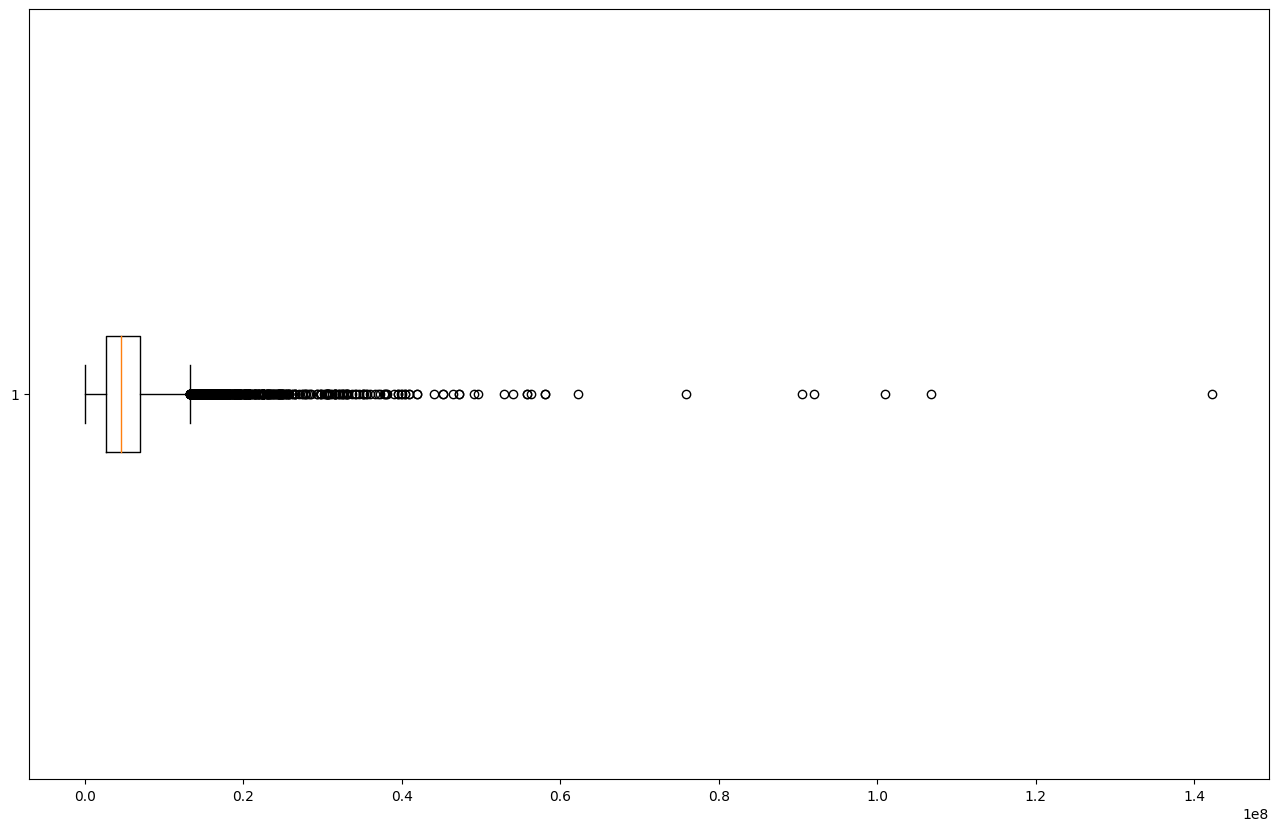

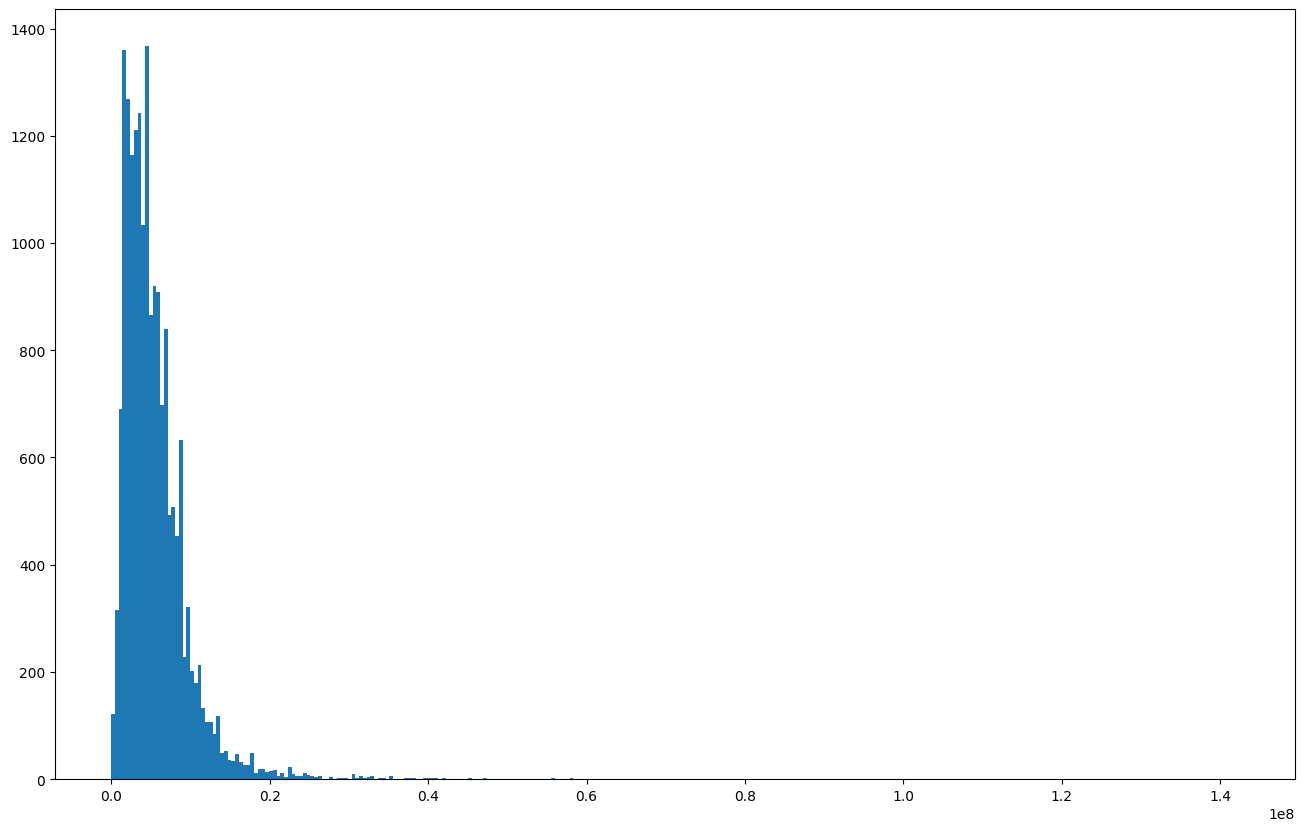

In [79]:
# Сформируем признак ипотечности заявки. Из простых идей - нужно собрать сумму и срок кредита из данных БКИ по ипотекам и 
# экстраполировать их на таблицу заявок

# Сначала посмотрим на распределение суммы кредита

bureau_mortgage = bureau[bureau["CREDIT_TYPE"].isin(['Mortgage','Real estate loan'])]

import matplotlib.pyplot as plt
import seaborn as sns

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_CREDIT_SUM', data=bureau_mortgage, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(bureau_mortgage['AMT_CREDIT_SUM'], bins=300)
plt.show()    

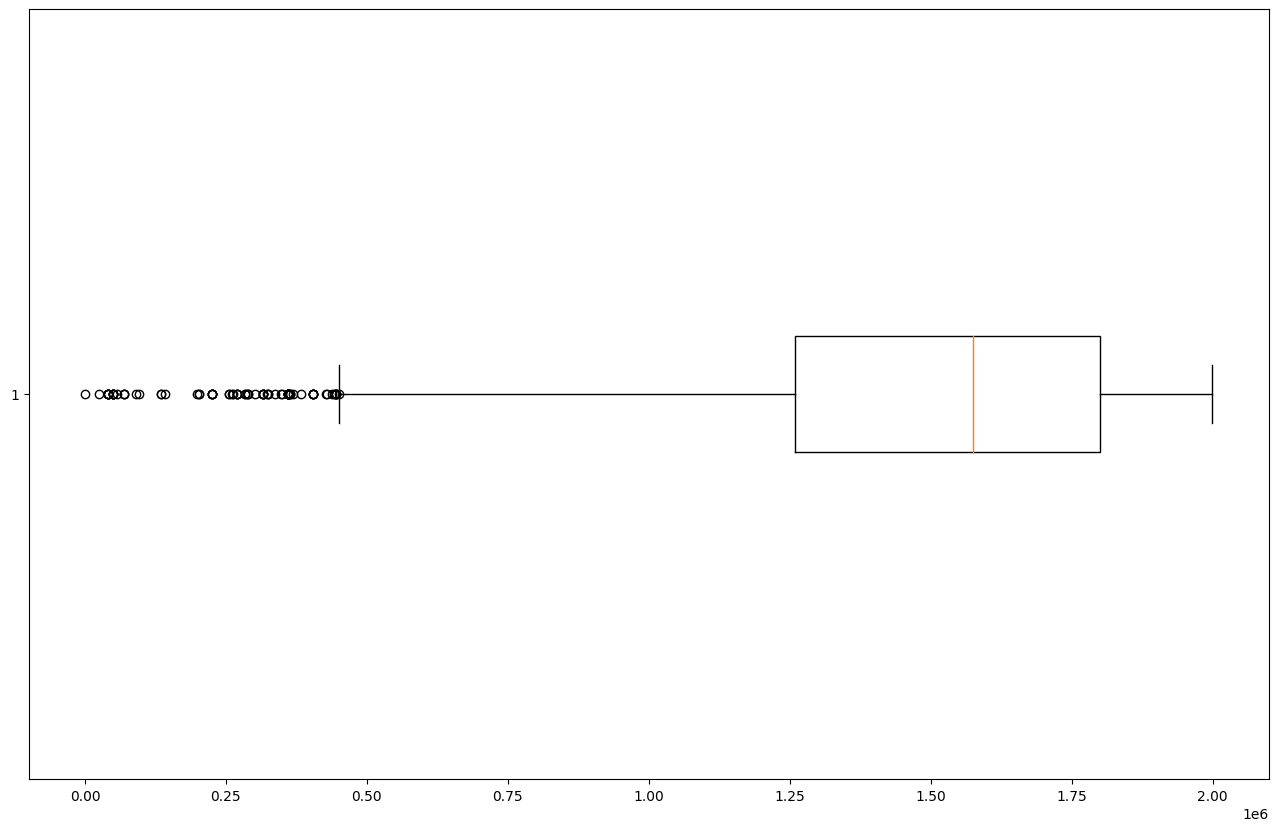

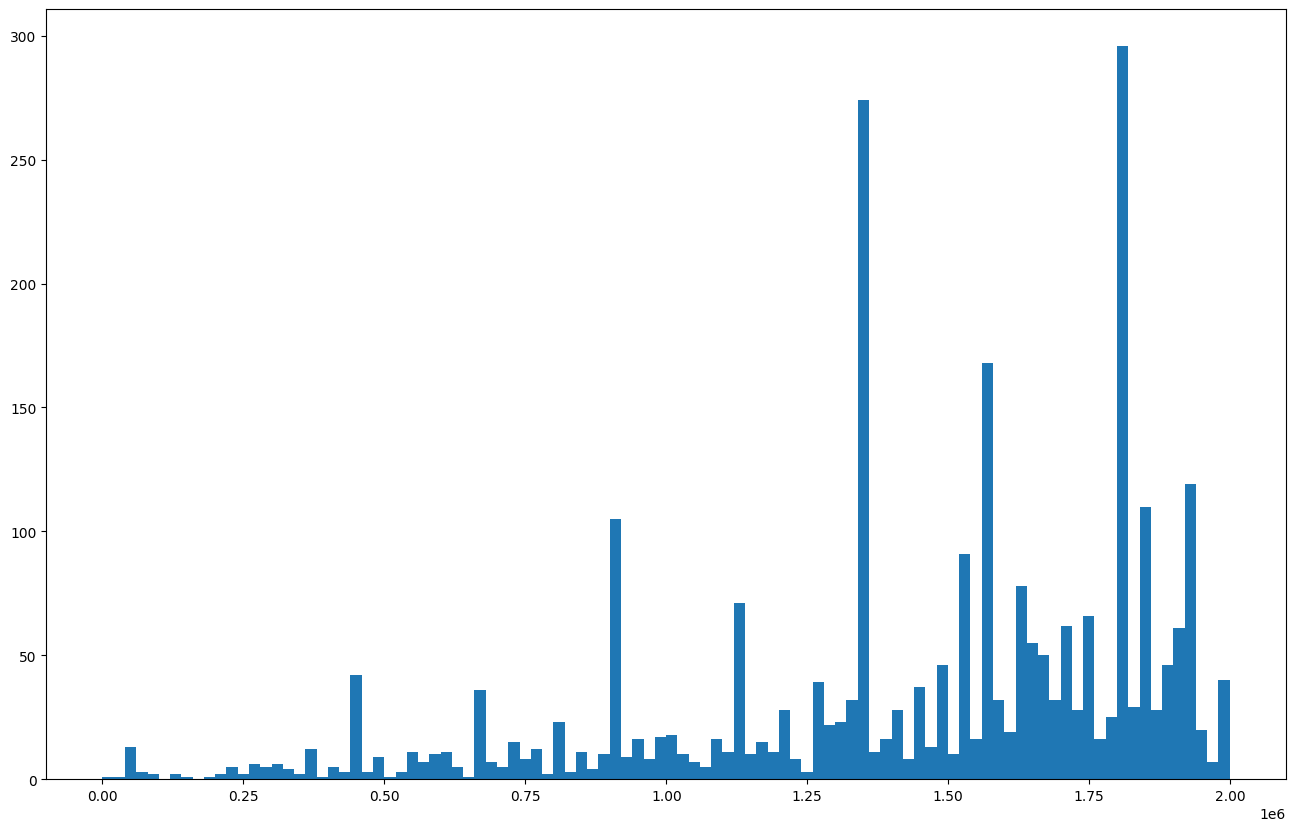

In [80]:
# Очевидно, что подавляющее большинство всех ипотечных кредитов лежит за пределами суммы 0.2e+08, потому следует изучить правую границу распределения. 
# Также, значения за пределами 0.4е+08 следует считать выбросами.

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_CREDIT_SUM', data=bureau_mortgage[bureau_mortgage['AMT_CREDIT_SUM']<0.2e+07], vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(bureau_mortgage[bureau_mortgage['AMT_CREDIT_SUM']<0.2e+07]['AMT_CREDIT_SUM'], bins=100)
plt.show()   

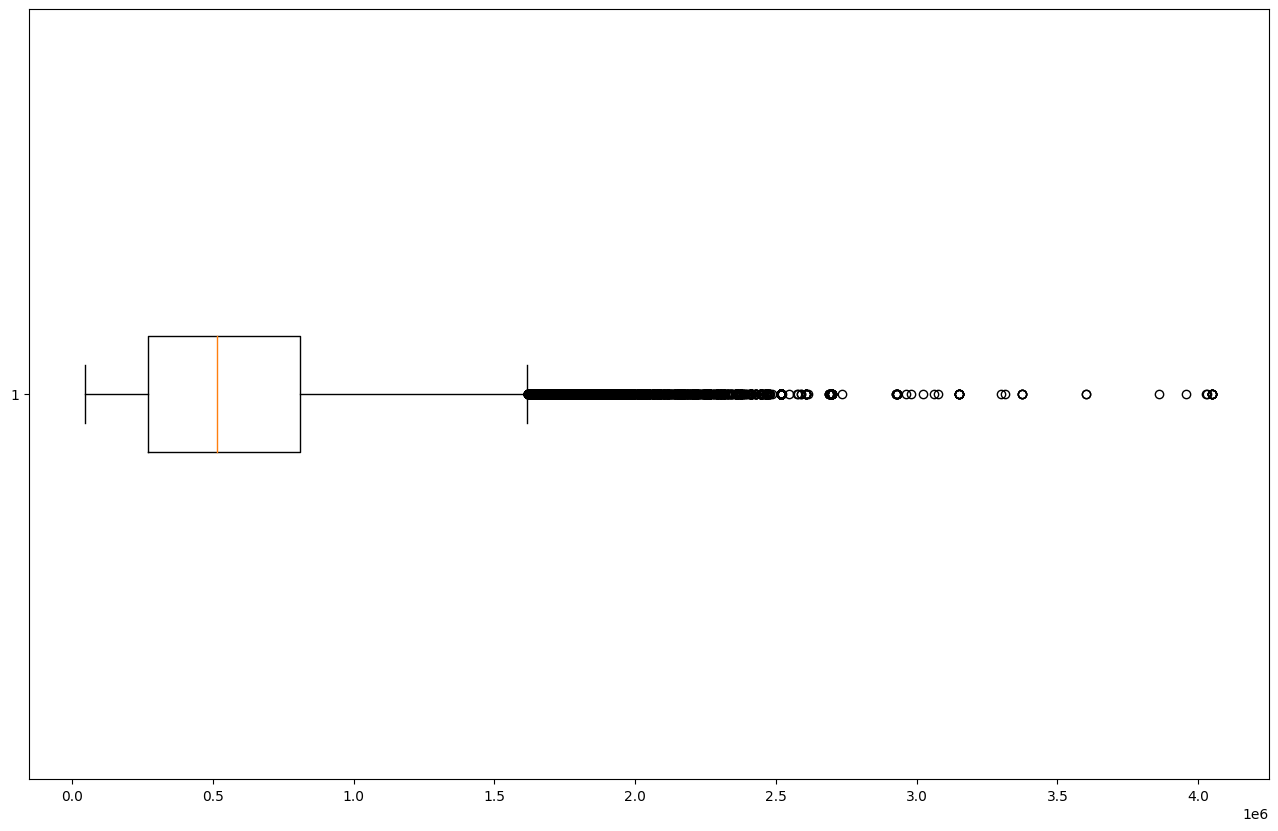

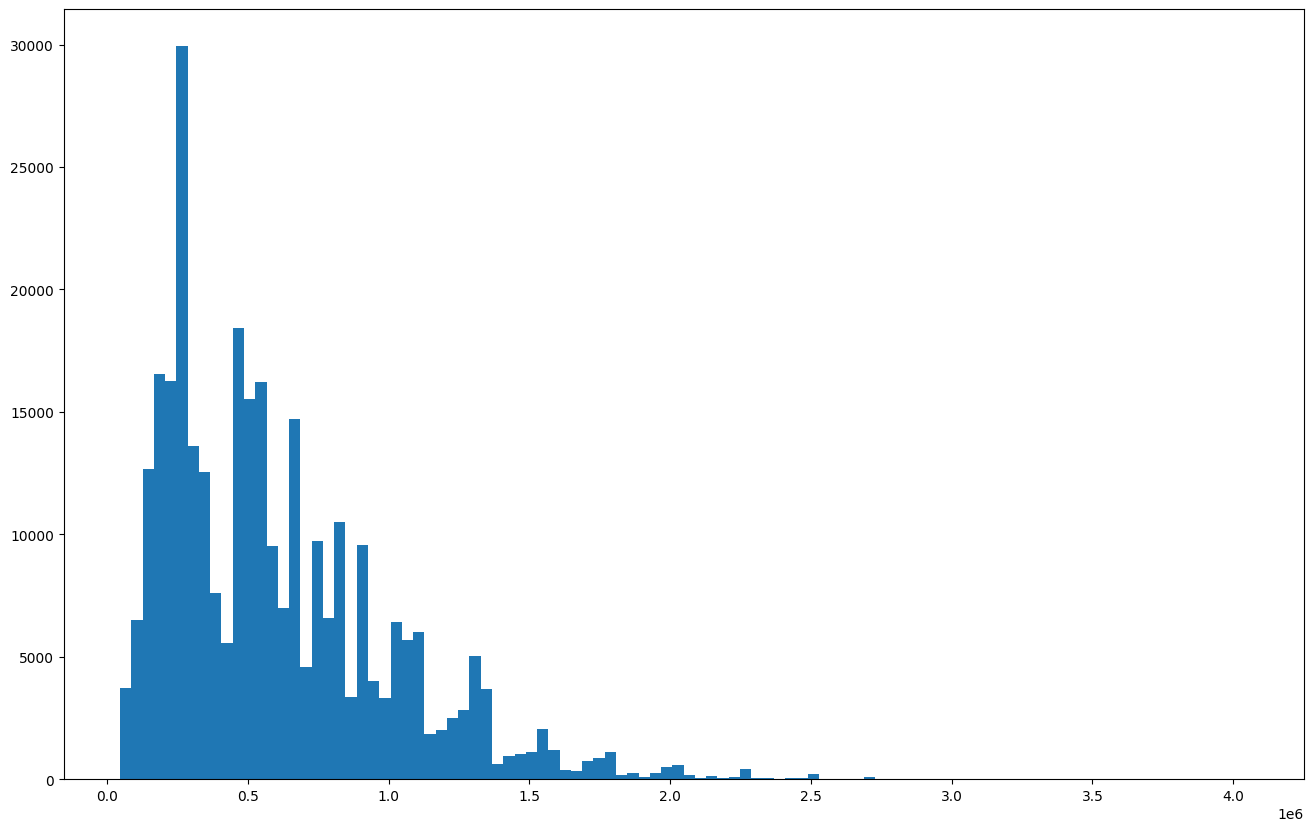

In [81]:
# Таким образом, верхнюю границу 25% перцентиля в распределении кредитов от 2 млн и ниже возьмём 1.25. Получим следующие аналитические границы суммы заявки:
# 1.25e+06<'AMT_CREDIT_SUM'<4e+07
# Наличие верхней аналитической границы стоит проверить при фильтрации заявок по нижней

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='AMT_CREDIT', data=data, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(data['AMT_CREDIT'], bins=100)
plt.show() 

In [82]:
# Из графика видно, что верхняя аналитическая граница не применима и мы можем отфильтровать исходную таблицу по нижней аналитической границе
data_mortgage = data[data["AMT_CREDIT"] >= 1.25e+06]
data_mortgage

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE
1,100003,0,F,N,N,0,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,MONDAY,11,0,0,0,0,0,0,School,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,-828.0
6,100009,0,F,Y,Y,1,171000.0,1560726.0,41301.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,-13778,-3130,-1213.0,-619,17.0,1,1,0,1,1,0,Accountants,3.0,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1562.0
7,100010,0,M,Y,Y,0,360000.0,1530000.0,42075.0,Unaccompanied,State servant,Higher education,Married,House / apartment,-18850,-449,-4597.0,-2379,8.0,1,1,1,1,0,0,Managers,2.0,MONDAY,16,0,0,0,0,1,1,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1070.0
48,100055,0,F,N,N,0,130500.0,1350000.0,37255.5,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,-19727,-4411,-6225.0,-3199,NaN,1,1,1,1,1,0,Managers,2.0,THURSDAY,10,0,0,0,0,0,0,Government,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-784.0
49,100056,0,M,Y,Y,0,360000.0,1506816.0,49927.5,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-18264,-9523,-5504.0,-1797,3.0,1,1,0,1,0,0,Laborers,2.0,THURSDAY,10,0,0,0,0,1,1,Transport: type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30

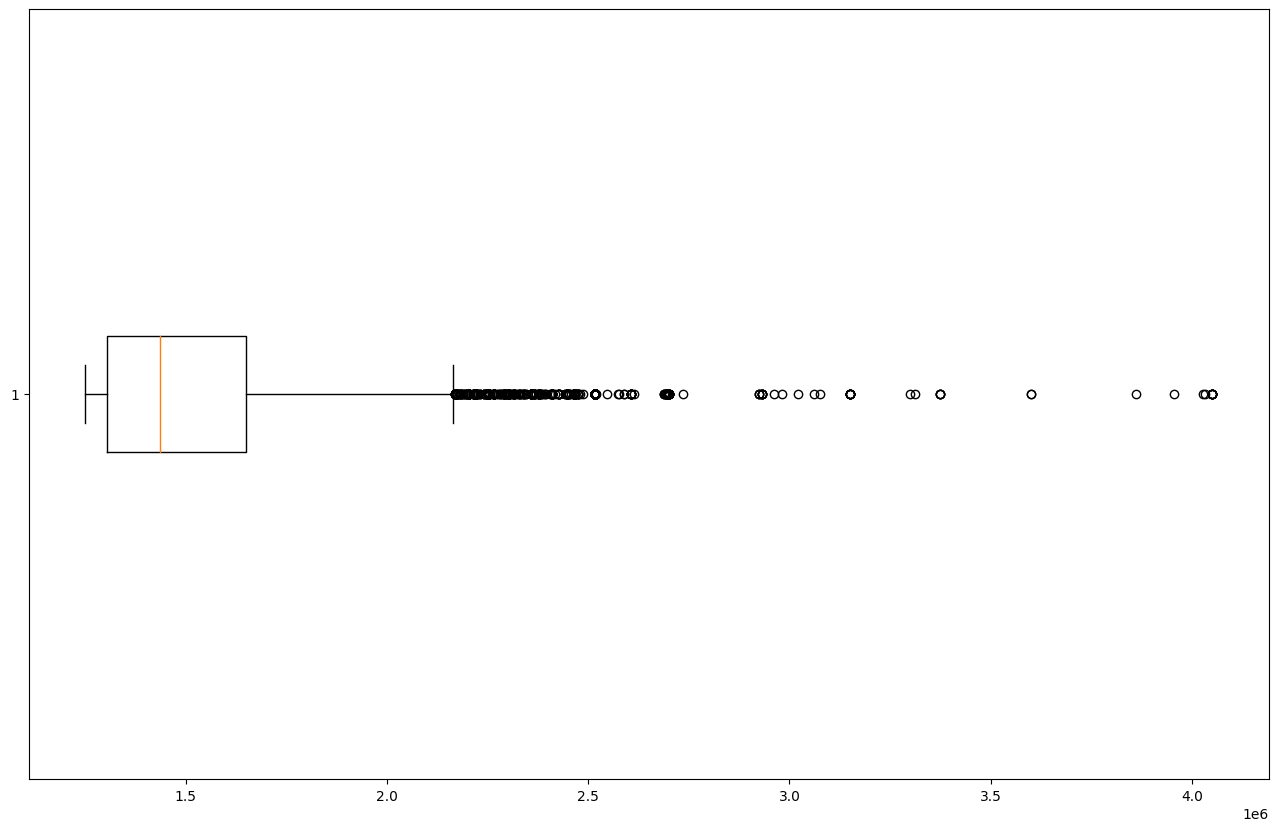

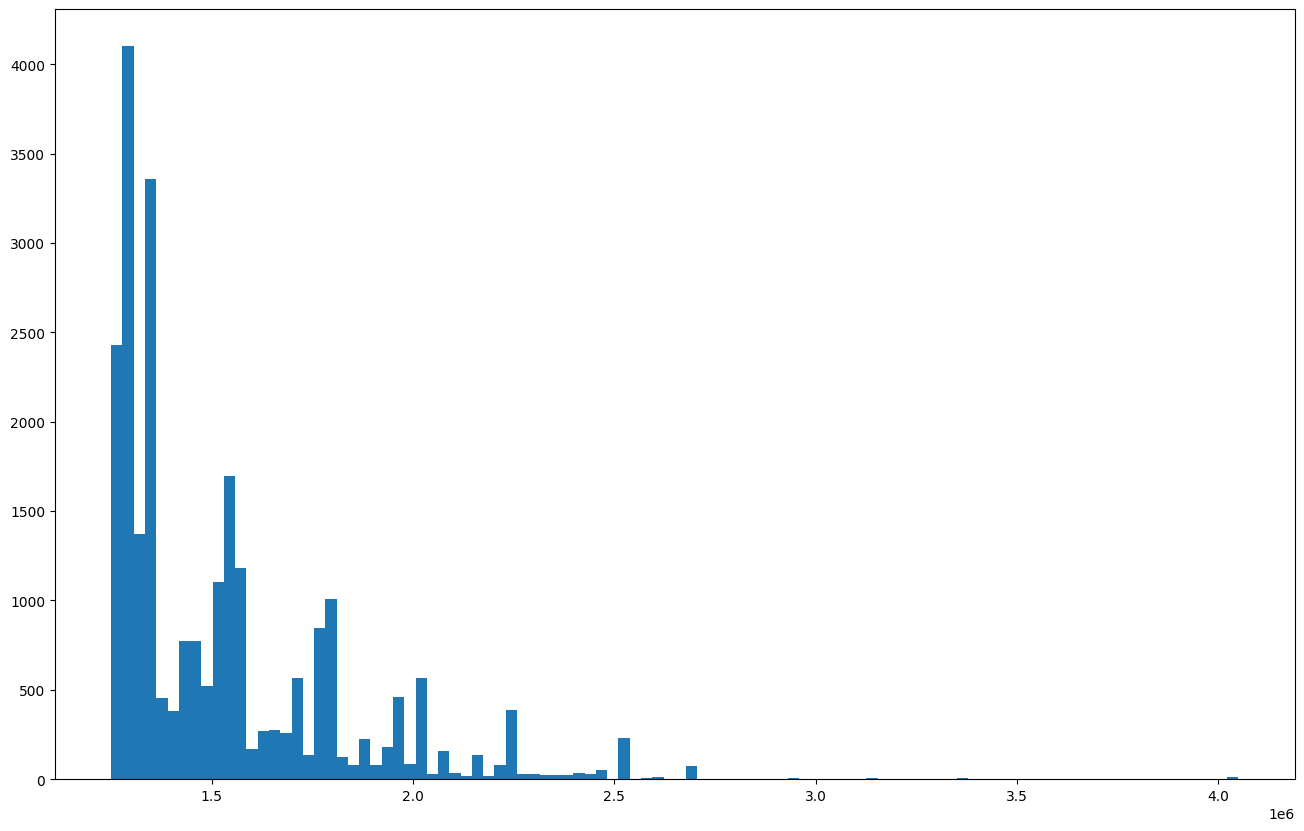

In [83]:
# Итоговое распределение сумм

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x="AMT_CREDIT", data=data_mortgage, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist( data_mortgage["AMT_CREDIT"], bins=100)
plt.show() 

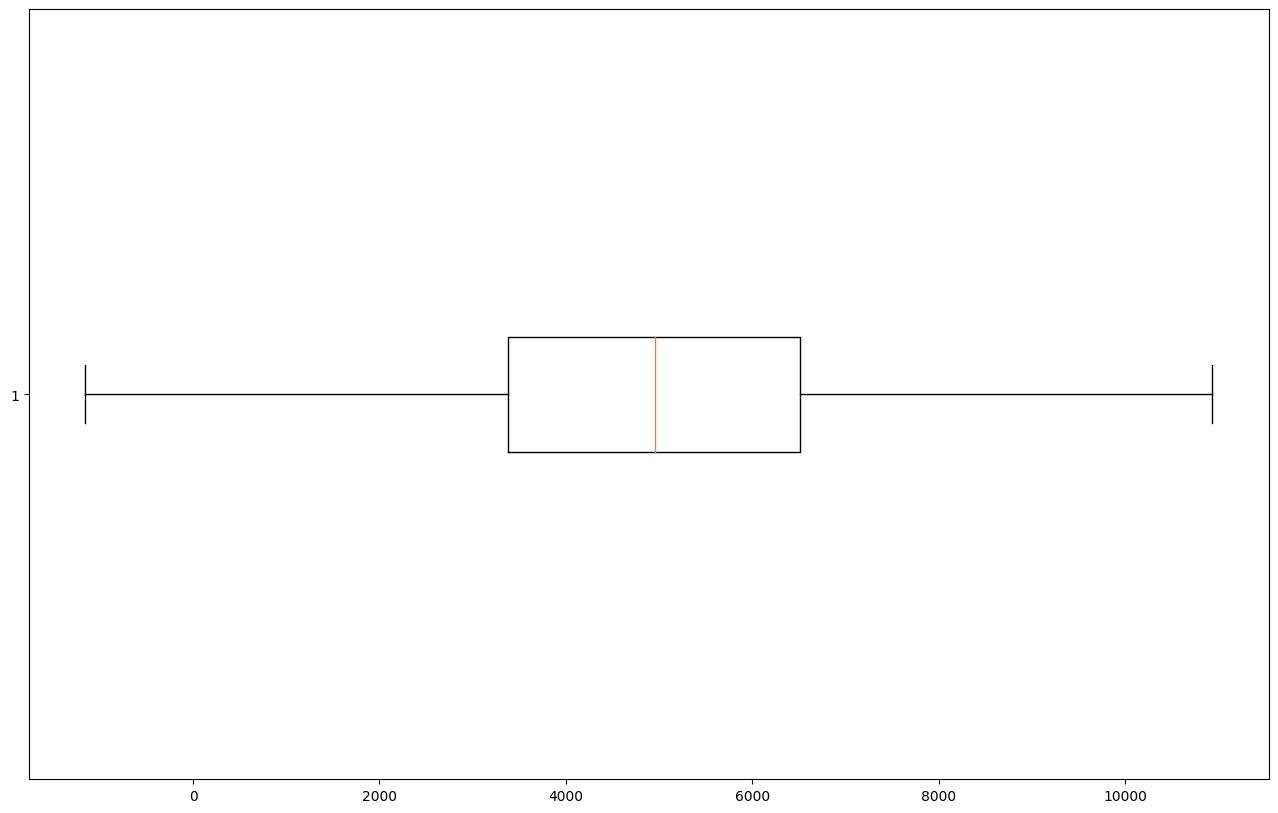

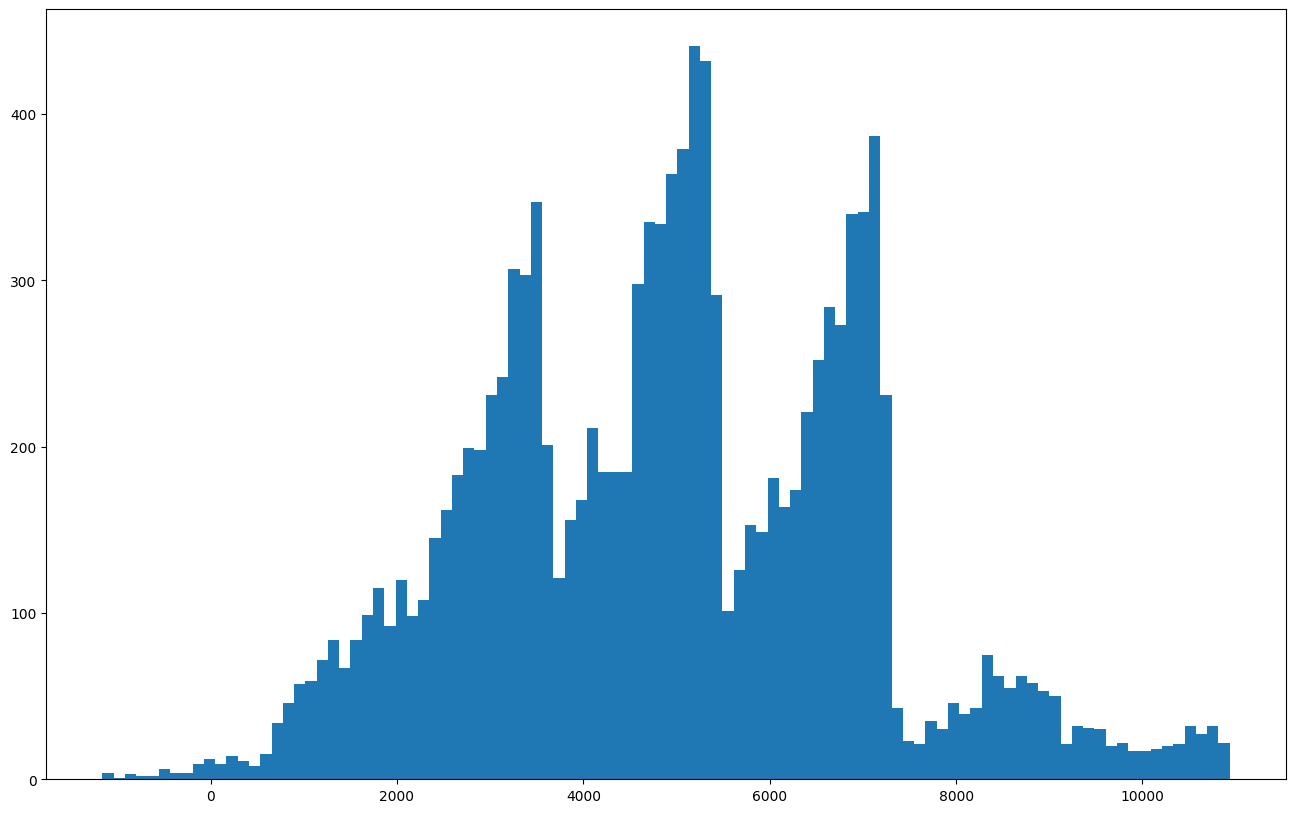

In [84]:
# Применим аналогичный подход к расчёту срока

# Выделим только те кредиты, которые являются активными на данный момент и по которым известен срок завершения. Активные требуются потому,
# что закрытые кредиты в датасете указаны с отрицательным числом дней от даты подачи заявки, т.е. кредит был закрыт N дней назад от даты датасета.
# Формально, активные кредиты также не дают полной картины, но выделить из них данные аналитически всё же возможно.

active_not_na_loans = bureau_mortgage[bureau_mortgage["CREDIT_ACTIVE"]=="Active"]
active_not_na_loans = active_not_na_loans[active_not_na_loans["DAYS_CREDIT_ENDDATE"].notna()]
active_not_na_loans

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='DAYS_CREDIT_ENDDATE', data=active_not_na_loans, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(active_not_na_loans['DAYS_CREDIT_ENDDATE'], bins=100)
plt.show()  

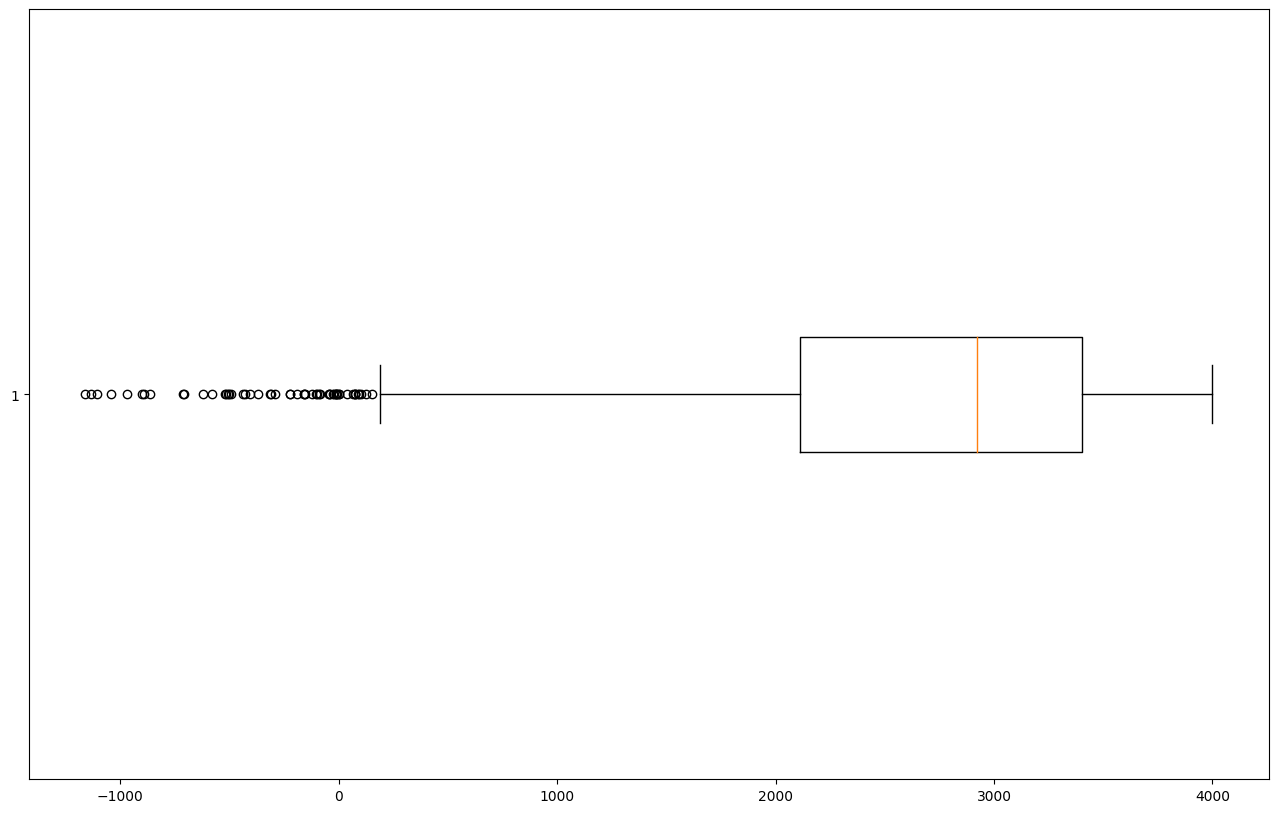

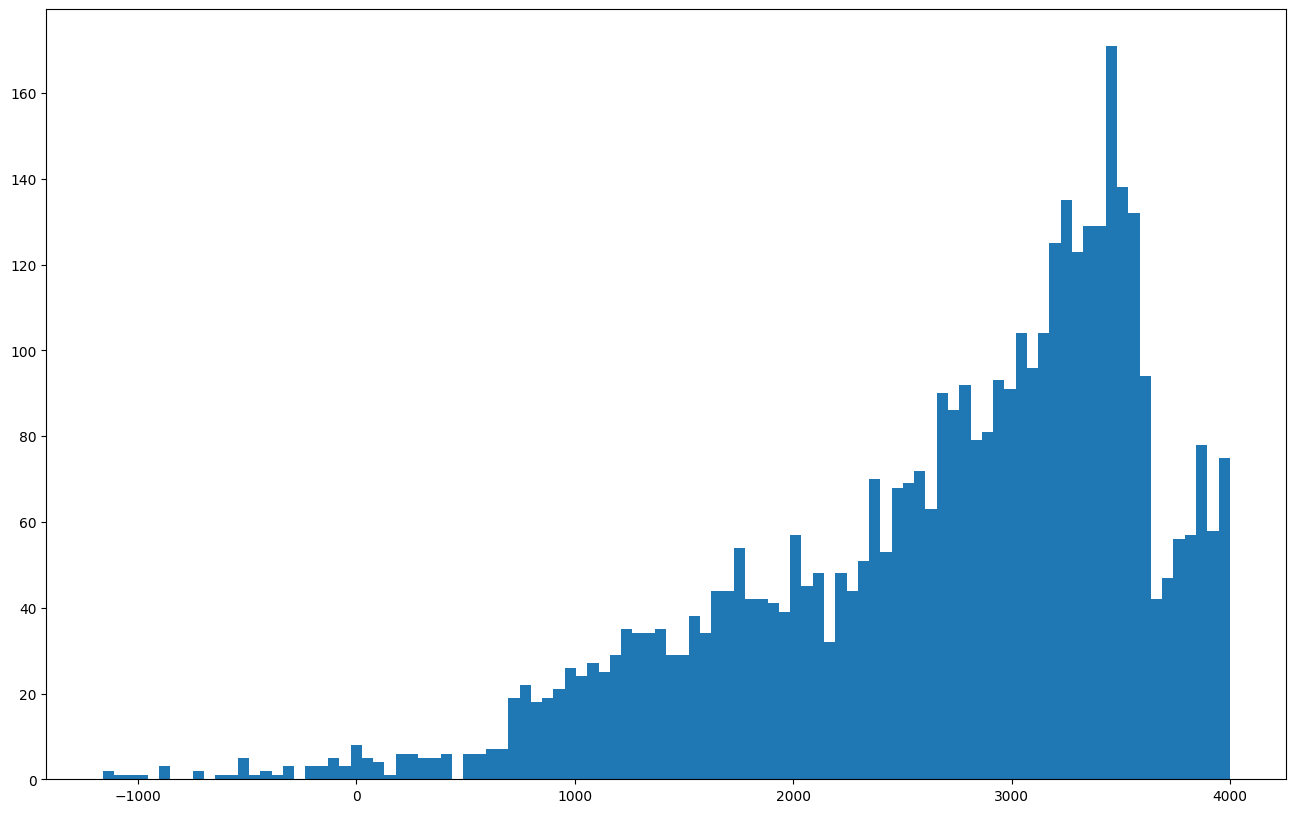

In [85]:
# Рассмотрим подробнее левую границу

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='DAYS_CREDIT_ENDDATE', data=active_not_na_loans[active_not_na_loans['DAYS_CREDIT_ENDDATE']<4000], vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(active_not_na_loans[active_not_na_loans['DAYS_CREDIT_ENDDATE']<4000]['DAYS_CREDIT_ENDDATE'], bins=100)
plt.show()  

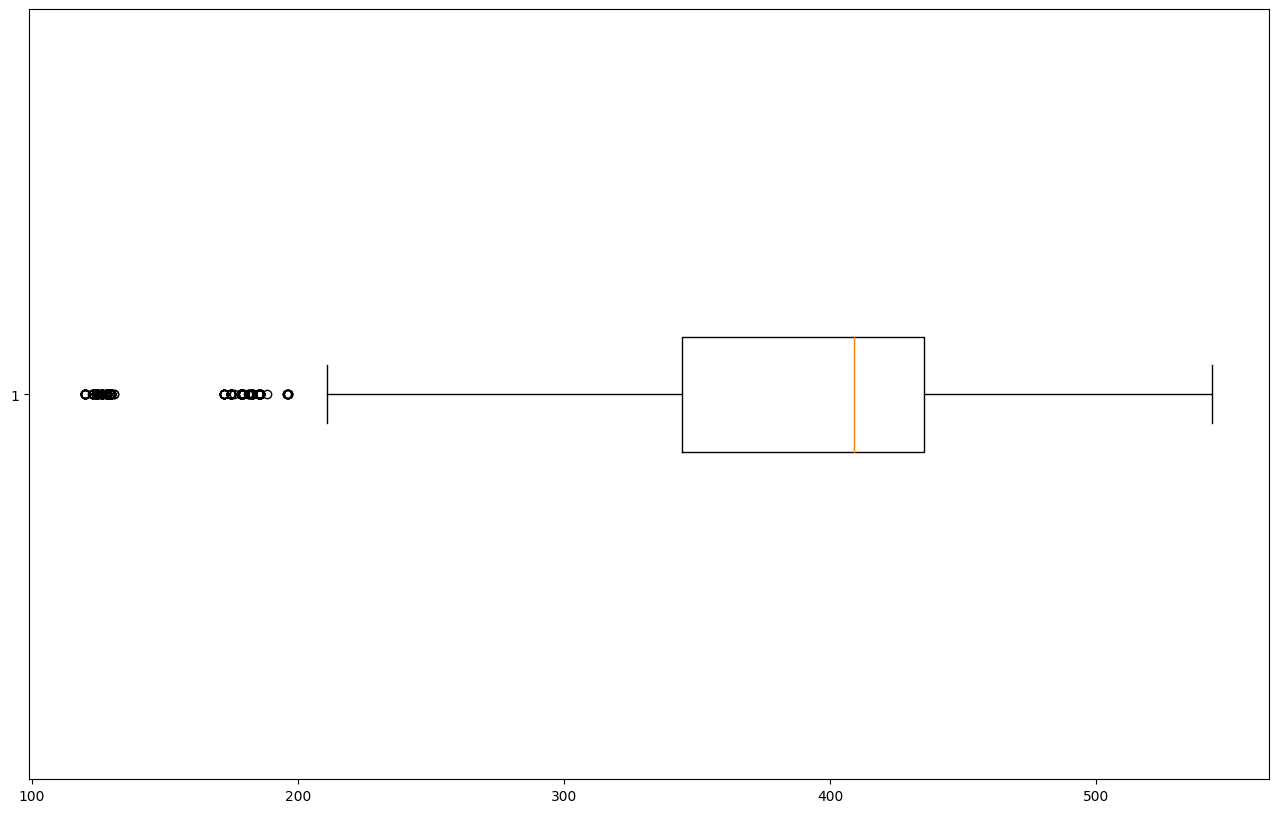

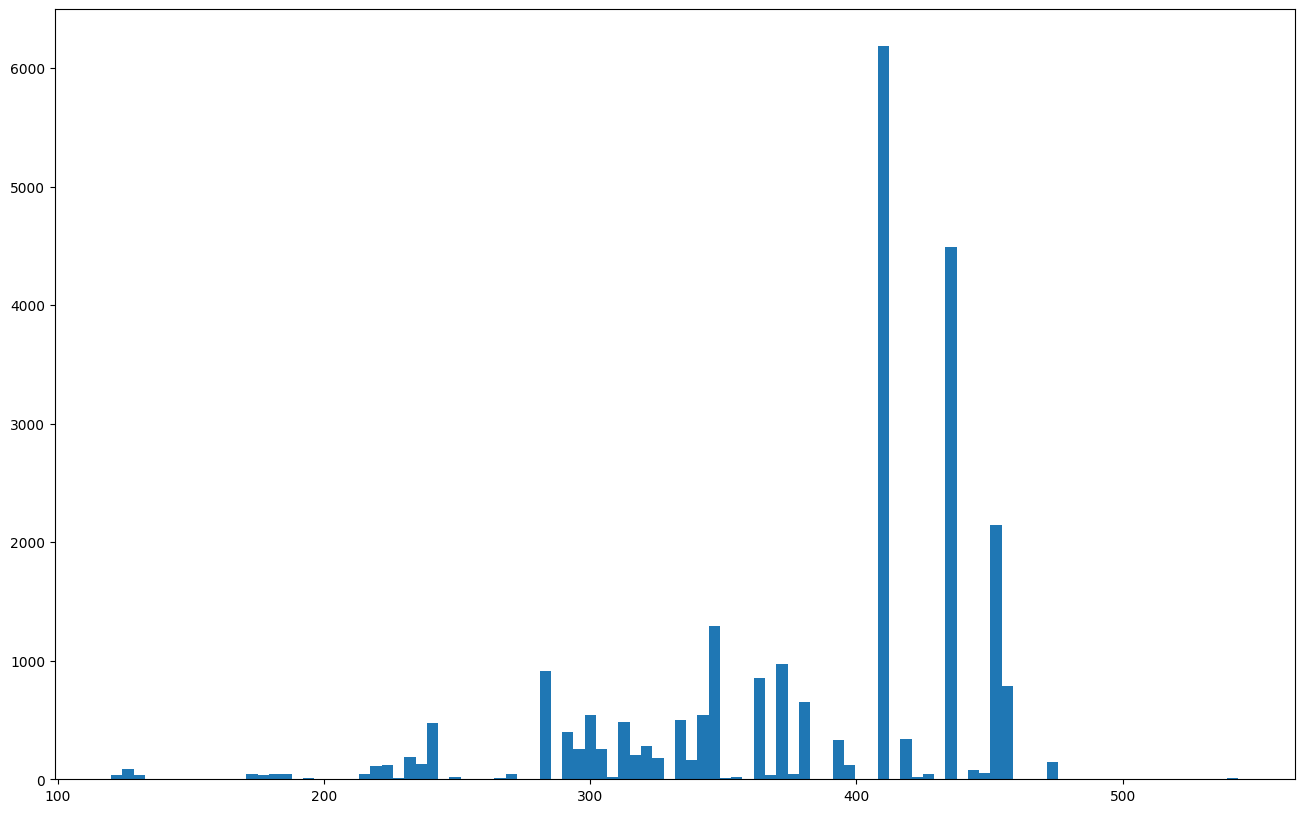

In [86]:
# Сделаем упрощение - учтём склонность европейцев к долгосрочному потребительскому кредитованию и поставим нижнюю аналитическую границу в 2000 дней.
# Далее необходимо посчитать срок, на который выдаётся кредит в заявке. В этом нам поможет наличие аннуиттентного платежа.

data_mortgage = data_mortgage[data_mortgage["AMT_ANNUITY"].notna()]
data_mortgage["CREDIT_LONGINESS"] = data_mortgage["AMT_CREDIT"]*12/data_mortgage["AMT_ANNUITY"]

f1 = plt.figure()
f1.set_size_inches(16, 10)
f2 = plt.figure()
f2.set_size_inches(16, 10)

ax1 = f1.add_subplot(111)
ax1.boxplot(x='CREDIT_LONGINESS', data=data_mortgage, vert=False)

ax2 = f2.add_subplot(111)
ax2.hist(data_mortgage['CREDIT_LONGINESS'], bins=100)
plt.show()  


In [87]:
# Подход по аналитической границе срока при распределениях выше результата не даст. 
# Соответственно, гипотезу с определением типа кредита по сроку отклоняем.
# Это неминуемо подводит нас к риску худшей реализации модели оценки ипотечного дефолта, 
# т.к. мы не можем с уверенностью сказать, что мы обучались на ипотечных заявках. Этот риск экстраполяции на российский рынок следует принять.
# Существует гипотеза, что ипотеку берут ради улушения жилищных условий, и, опираясь на параметры текущего места проживания аппликанта можно
# сделать предположение о цели кредита, но такая гипотеза выглядит слабее гипотезы по сроку кредита и рассматриваться в данной работе не будет.
# Рассмотрим структуру данных бюро и сделаем предположения об признаках, которое можно было бы извлечь для обогащения изначальной выборки.

bureau_appl = bureau[bureau["SK_ID_CURR"].isin(data_mortgage["SK_ID_CURR"])]

numeric_columns = bureau_appl.loc[:,bureau_appl.dtypes!=object].columns
bureau_appl.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,131624.000000,1.316240e+05,131624.000000,131624.000000,124220.000000,84902.000000,4.494400e+04,131624.000000,1.316240e+05,1.103710e+05,8.562300e+04,131624.000000,131624.000000,2.697100e+04
mean,277456.615876,5.776334e+06,-1241.957477,0.657844,470.016592,-1074.779829,6.717978e+03,0.008403,5.558678e+05,1.944087e+05,9.393427e+03,1.086089,-640.473561,2.057304e+04
std,102656.235873,5.102652e+05,806.064851,33.889983,4813.582468,724.443193,5.519994e+05,0.110071,1.516714e+06,9.091450e+05,6.988084e+04,273.197064,788.263190,1.417165e+05
min,100003.000000,5.000031e+06,-2922.000000,0.000000,-41920.000000,-2915.000000,0.000000e+00,0.000000,0.000000e+00,-2.167229e+06,-3.991669e+05,0.000000,-41945.000000,0.000000e+00
25%,189103.000000,5.350922e+06,-1819.000000,0.000000,-1193.000000,-1578.000000,0.000000e+00,0.000000,6.750000e+04,0.000000e+00,0.000000e+00,0.000000,-948.000000,0.000000e+00
50%,277992.000000,5.683810e+06,-1106.000000,0.000000,-358.000000,-949.000000,0.000000e+00,0.000000,1.746000e+05,0.000000e+00,0.000000e+00,0.000000,-465.000000,0.000000e+00
75%,365848.000000,6.184923e+06,-563.000000,0.000000,553.000000,-470.000000,0.000000e+00,0.000000,4.950000e+05,2.118600e+04,0.000000e+00,0.000000,-42.000000,1.892025e+04
max,456244.000000,6.842848e+06,-2.000000,2639.000000,31199.000000,-1.000000,1.159872e+08,5.000000,1.125000e+08,5.963769e+07,4.500000e+06,99004.500000,22.000000,9.508599e+06


In [88]:
# объектные колонки

object_columns = bureau_appl.loc[:,bureau_appl.dtypes==object].columns
bureau_appl.describe(include='object')

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,131624,131624,131624
unique,3,4,12
top,Closed,currency 1,Consumer credit
freq,84630,131333,92251


Вопросы, на которые способны ответить данные бюро:
1. Обращался ли клиент за кредитом ранее.
2. Были ли у него просрочки вообще.
3. Обращался ли клиент за ипотекой.
4. Были ли просрочки по ипотеке.
5. В данных существуют неочевидные взаимосвзяи, на выявление которых потребуется значительное время и ещё более значительный опыт. Идея - использовать PCA или FC NN для выявления таких зависимостей. Например, 5 признаков.

In [89]:
# Ответим на вопросы. Для начала, нужно понимать, что информация собрана по типу много ко многим, и мы точно имеем дубли индекса заявителя.
# Это даёт нам простор для сбора описательных статистик, но в данной работе ограничимся булевыми по следующим причинам:
# 1. Трудно вводить перегруженную анкету, невыгодно показывать на демо клиенту.
# 2. Доступа к БКИ у клиента может не быть или специфические данные БКИ могут отсутствовать. Это справедливо и для выделенных признаков, 
# но все выделенные признаки возможно получить кредитным отчётом по клиенту (кроме TSNE, про него позже)

# Индексы прошлой кредитной заявки в бюро уникальные сквозь таблицу, их можно убрать.
bureau_appl = bureau_appl.drop(columns=["SK_ID_BUREAU"])

In [90]:
# Данные имеют пропуски. Для начала, исправим те, кто мешают отвечать на поставленные выше вопросы.

# Обращался ли клиент за кредитом ранее?
data_mortgage.loc[data_mortgage["SK_ID_CURR"].isin(bureau["SK_ID_CURR"]), "FLAG_BUREAU_PREV_LOANS"] = 1

# обращался ли клиент за ипотекой?
data_mortgage.loc[data_mortgage["SK_ID_CURR"].isin(bureau_mortgage["SK_ID_CURR"]), "FLAG_BUREAU_PREV_MORT"] = 1

# Были ли у него просрочки вообще?
bureau_appl_overdue_ = bureau_appl[bureau_appl["AMT_CREDIT_MAX_OVERDUE"]>0]

data_mortgage.loc[data_mortgage["SK_ID_CURR"].isin(bureau_appl_overdue_["SK_ID_CURR"]), "FLAG_BUREAU_OVER_ANY"] = 1

# Были ли у него просрочки по ипотеке?
bureau_appl_overdue_mortg_ = bureau_appl[bureau_appl["AMT_CREDIT_MAX_OVERDUE"]>0]

data_mortgage.loc[data_mortgage["SK_ID_CURR"].isin(bureau_appl_overdue_mortg_["SK_ID_CURR"]), "FLAG_BUREAU_OVER_MORT"] = 1

# Заполним пропуски флагов
data_mortgage.loc[data_mortgage["FLAG_BUREAU_PREV_LOANS"].isna(), "FLAG_BUREAU_PREV_LOANS"] = 0
data_mortgage.loc[data_mortgage["FLAG_BUREAU_PREV_MORT"].isna(), "FLAG_BUREAU_PREV_MORT"] = 0
data_mortgage.loc[data_mortgage["FLAG_BUREAU_OVER_ANY"].isna(), "FLAG_BUREAU_OVER_ANY"] = 0
data_mortgage.loc[data_mortgage["FLAG_BUREAU_OVER_MORT"].isna(), "FLAG_BUREAU_OVER_MORT"] = 0

# Проверим на пропуски в свежесозданных данных
data_mortgage.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,FLAG_BUREAU_OVER_ANY,FLAG_BUREAU_OVER_MORT
count,24909.000000,24909.000000,24909.000000,2.490900e+04,2.490900e+04,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,11605.000000,24909.0,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,14187.000000,12125.000000,14677.000000,9961.000000,8989.000000,13589.000000,14297.000000,14443.000000,9575.000000,11679.000000,9444.000000,14266.000000,9143.000000,13057.000000,14187.000000,12125.000000,14677.000000,9961.000000,8989.000000,13589.000000,14297.000000,14443.000000,9575.000000,11679.000000,9444.000000,14266.000000,9143.000000,13057.000000,14187.000000,12125.000000,14677.000000,9961.000000,8989.000000,13589.000000,14297.000000,14443.000000,9575.000000,11679.000000,9444.000000,14266.000000,9143.000000,13057.000000,14841.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000
mean,277788.946445,0.052792,0.412381,2.504686e+05,1.526539e+06,49778.374563,-16560.148701,49300.922879,-4924.244530,-3028.020836,9.814821,1.0,0.858324,0.199326,0.999438,0.321892,0.065157,2.259183,12.470954,0.023365,0.080774,0.067566,0.064675,0.208399,0.173552,0.130996,0.094565,0.978907,0.763309,0.052212,0.102786,0.152012,0.260561,0.259825,0.066124,0.112177,0.124425,0.010794,0.034451,0.126116,0.092145,0.978178,0.769716,0.048892,0.096336,0.146223,0.255476,0.255048,0.064083,0.116102,0.121154,0.009704,0.032415,0.131103,0.093583,0.978887,0.766336,0.052068,0.101426,0.151229,0.260113,0.259544,0.066899,0.113067,0.125563,0.010478,0.034074,0.119503,-1066.270264,382.052845,0.884419,0.071701,0.233650,0.233650
std,102588.510783,0.223623,0.719155,1.785497e+05,2.933852e+05,15725.761079,3777.303741,128320.387500,3493.264607,1527.823373,10.227215,0.0,0.348724,0.399501,0.023701,0.467211,0.246808,0.841996,3.380115,0.151063,0.272493,0.251005,0.245957,0.406171,0.378731,0.119154,0.086677,0.056066,0.117545,0.084591,0.152772,0.096705,0.165539,0.182364,0.081966,0.103507,0.124415,0.053904,0.080290,0.118008,0.087134,0.062260,0.114457,0.081743,0.149980,0.097829,0.164418,0.182387,0.082135,0.108226,0.124610,0.051648,0.080970,0.120139,0.085825,0.057074,0.116356,0.084347,0.152808,0.097171,0.166252,0.183189,0.083370,0.104201,0.126692,0.053167,0.081059,0.121047,869.577778,65.493911,0.319728,0.257997,0.423161,0.423161
min,100003.000000,0.000000,0.000000,2.565000e+04,1.250118e+06,28813.500000,-25229.000000,-16836.000000,-22928.000000,-6207.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [44]:
# MTE и заполнение пропусков перед TSNE

bureau_appl_ = bureau_appl.copy()
for col in object_columns:
        mean_target = bureau_appl_.groupby(col)['CREDIT_DAY_OVERDUE'].mean()
        bureau_appl_[col] = bureau_appl_[col].map(mean_target)


numeric_columns = bureau_appl_.loc[:,bureau_appl.dtypes!=object].columns
for col in numeric_columns:
    bureau_appl_[col] = bureau_appl_[col].fillna(bureau_appl_[col].mean())

bureau_appl_.describe()

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,131624.000000,131624.000000,131624.000000,131624.000000,131624.000000,131624.000000,131624.000000,1.316240e+05,131624.000000,1.316240e+05,1.316240e+05,1.316240e+05,131624.000000,131624.000000,131624.000000,1.316240e+05
mean,277456.615876,0.657844,0.657844,-1241.957477,0.657844,470.016592,-1074.779829,6.717978e+03,0.008403,5.558678e+05,1.944087e+05,9.393427e+03,1.086089,0.657844,-640.473561,2.057304e+04
std,102656.235873,2.307597,0.030966,806.064851,33.889983,4676.237265,581.828307,3.225550e+05,0.110071,1.516714e+06,8.325163e+05,5.636181e+04,273.197064,0.103319,788.263190,6.414976e+04
min,100003.000000,0.083150,0.000000,-2922.000000,0.000000,-41920.000000,-2915.000000,0.000000e+00,0.000000,0.000000e+00,-2.167229e+06,-3.991669e+05,0.000000,0.000000,-41945.000000,0.000000e+00
25%,189103.000000,0.083150,0.659301,-1819.000000,0.000000,-1130.000000,-1170.000000,0.000000e+00,0.000000,6.750000e+04,0.000000e+00,0.000000e+00,0.000000,0.526054,-948.000000,2.057304e+04
50%,277992.000000,0.083150,0.659301,-1106.000000,0.000000,-265.500000,-1074.779829,6.717978e+03,0.000000,1.746000e+05,0.000000e+00,0.000000e+00,0.000000,0.719017,-465.000000,2.057304e+04
75%,365848.000000,1.315711,0.659301,-563.000000,0.000000,478.000000,-738.000000,6.717978e+03,0.000000,4.950000e+05,1.944087e+05,9.393427e+03,0.000000,0.719017,-42.000000,2.057304e+04
max,456244.000000,36.827655,0.659301,-2.000000,2639.000000,31199.000000,-1.000000,1.159872e+08,5.000000,1.125000e+08,5.963769e+07,4.500000e+06,99004.500000,0.719017,22.000000,9.508599e+06


In [52]:
bureau_ = bureau_appl_.groupby(["SK_ID_CURR"]).mean().reset_index()
bureau_ 

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100003,0.391290,0.659301,-1400.750000,0.0,-544.500000,-1091.694957,0.000000,0.0,254350.125000,0.000000,202500.000000,0.0,0.622535,-816.000000,20573.035591
1,100009,0.357053,0.659301,-1271.500000,0.0,-654.387045,-1101.006629,5225.094106,0.0,266711.750000,103054.685110,3652.999364,0.0,0.697576,-851.611111,20573.035591
2,100010,0.699431,0.659301,-1939.500000,0.0,-119.500000,-1106.389914,6717.978136,0.0,495000.000000,174003.750000,4696.713468,0.0,0.359508,-578.000000,20573.035591
3,100055,0.787471,0.659301,-876.857143,0.0,1.145227,-895.017045,5758.266974,0.0,403818.859286,233322.210141,4025.754401,0.0,0.672870,-288.000000,20573.035591
4,100071,0.083150,0.659301,-1594.250000,0.0,-1158.500000,-1165.250000,6717.978136,0.0,149514.750000,48602.176999,2348.356734,0.0,0.719017,-687.500000,20573.035591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22025,456216,0.576175,0.659301,-1206.200000,0.0,-451.600000,-1052.111931,6717.978136,0.0,529632.900000,257852.700000,0.000000,0.0,0.719017,-560.600000,20573.035591
22026,456220,0.576175,0.659301,-1000.800000,0.0,5134.000000,-1075.911931,5374.382509,0.4,166068.000000,132909.754599,38288.057774,0.0,0.680424,-458.800000,20573.035591
22027,456236,0.462400,0.659301,-1270.153846,0.0,478.769231,-1261.086101,3407.458175,0.0,638975.596154,327769.999844,5057.999119,0.0,0.684164,-946.153846,20573.035591
22028,456242,1.315711,0.659301,-491.000000,0.0,509.000000,-1074.779829,6717.978136,0.0,198000.000000,186097.500000,0.000000,0.0,0.526054,-5.000000,11205.000000


## TSNE для данных БКИ, будьте внимательны

In [54]:
from sklearn.manifold import TSNE
bureau_tsne = bureau_.set_index(["SK_ID_CURR"])
bureau_tsne = TSNE(n_components=3, n_jobs=4, random_state=42).fit_transform(bureau_tsne)

In [67]:
bureau_tsne_ = np.concatenate((bureau_tsne, bureau_["SK_ID_CURR"].values.reshape(-1, 1)), axis=1)
bureau_tsne_ = pd.DataFrame(bureau_tsne_, columns=['Tsne_1st_component',
                                       'Tsne_2nd_component',
                                       'Tsne_3rd_component',
                                                  "SK_ID_CURR"])
bureau_tsne_["SK_ID_CURR"] = bureau_tsne_["SK_ID_CURR"].astype('int64')
bureau_tsne_

,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component,SK_ID_CURR
0,-8.658347,8.526887,0.857079,100003
1,-1.923463,-2.696966,9.886137,100009
2,10.386352,0.780868,0.242534,100010
3,9.931601,-12.357285,-6.093150,100055
4,-13.123246,0.023423,-11.042142,100071
...,...,...,...,...
22025,8.807288,-7.099911,7.897267,456216
22026,-14.610455,-17.288080,3.281166,456220
22027,16.605824,-7.864538,12.673636,456236
22028,-5.890571,-22.293907,6.861719,456242


In [104]:
# Теперь уберём пропуски в данных оригинальной таблицы. Учитывая, что данные по недвижимости создают основной массив пропусков 
# есть смысл первое приближение рассмотреть без них

data_mortgage_light = data_mortgage.loc[:,~data_mortgage.columns.str.contains('_AVG|_MODE|_MEDI', case=False)] 

# Подмержим TSNE и заполним пропуски нулями
data_mortgage_light = data_mortgage_light.merge(bureau_tsne_, on="SK_ID_CURR", how="left")
data_mortgage_light = data_mortgage_light.fillna(0)

data_mortgage_light.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,FLAG_BUREAU_OVER_ANY,FLAG_BUREAU_OVER_MORT,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component
count,24909.000000,24909.000000,24909.000000,2.490900e+04,2.490900e+04,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.0,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000
mean,277788.946445,0.052792,0.412381,2.504686e+05,1.526539e+06,49778.374563,-16560.148701,49300.922879,-4924.244530,-3028.020836,4.572685,1.0,0.858324,0.199326,0.999438,0.321892,0.065157,2.259183,12.470954,0.023365,0.080774,0.067566,0.064675,0.208399,0.173552,-1066.270264,382.052845,0.884419,0.071701,0.233650,0.233650,0.418092,-0.056886,-0.159658
std,102588.510783,0.223623,0.719155,1.785497e+05,2.933852e+05,15725.761079,3777.303741,128320.387500,3493.264607,1527.823373,8.526439,0.0,0.348724,0.399501,0.023701,0.467211,0.246808,0.841996,3.380115,0.151063,0.272493,0.251005,0.245957,0.406171,0.378731,869.577778,65.493911,0.319728,0.257997,0.423161,0.423161,17.376468,11.139217,8.114257
min,100003.000000,0.000000,0.000000,2.565000e+04,1.250118e+06,28813.500000,-25229.000000,-16836.000000,-22928.000000,-6207.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4128.000000,120.000000,0.000000,0.000000,0.000000,0.000000,-40.501060,-35.910194,-19.791050
25%,189594.000000,0.000000,0.000000,1.575000e+05,1.305000e+06,39469.500000,-19687.000000,-3433.000000,-7476.000000,-4333.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1682.000000,344.450559,1.000000,0.000000,0.000000,0.000000,-12.274991,-7.448915,-6.502544
50%,278040.000000,0.000000,0.000000,2.250000e+05,1.436850e+06,45333.000000,-16477.000000,-1652.000000,-4479.000000,-3327.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-896.000000,409.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,366843.000000,0.000000,1.000000,2.925000e+05,1.649844e+06,55507.500000,-13642.000000,-483.000000,-1906.000000,-1760.000000,7.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-347.000000,435.069650,1.000000,0.000000,0.000000,0.000000,11.931463,7.591000,6.035555
max,456244.000000,1.000000,7.000000,1.350000e+07,4.050000e+06,258025.500000,-7692.000000,365243.000000,0.000000,0.000000,65.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,543.527144,1.000000,1.000000,1.000000,1.000000,35.428658,25.001486,22.848314


In [111]:
# Теперь рассмотрим структуру данных банка и сделаем предположения о признаках, которые можно было бы извлечь для обогащения изначальной выборки.
# Вопросы, на которые способны ответить данные банковских историй:

#   1. Обращался ли клиент за кредитом ранее.
#   2. Были ли у него просрочки вообще.
#   3. Обращался ли клиент за ипотекой.
#   4. Были ли просрочки по ипотеке.
#   5. PCA/TSNE
#   6. Проаппрувили ли?


prev_appl_ = prev_appl[prev_appl["SK_ID_CURR"].isin(data_mortgage["SK_ID_CURR"])]

numeric_columns_prev = prev_appl_.loc[:,prev_appl_mortgage.dtypes!=object].columns
prev_appl_.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.025510e+05,102551.000000,82898.000000,1.025510e+05,1.025510e+05,5.212800e+04,8.161700e+04,102551.000000,102551.000000,52128.000000,339.000000,339.000000,102551.000000,102551.000000,82898.000000,66100.000000,66100.00000,66100.000000,66100.000000,66100.000000,66100.000000
mean,1.921232e+06,278030.114460,20502.429971,2.509287e+05,2.745332e+05,9.071964e+03,3.152951e+05,12.850474,0.996880,0.088261,0.196630,0.743155,-980.527864,358.264785,16.846667,345742.690030,12529.23295,29657.630348,50767.748321,57756.674856,0.313707
std,5.349959e+05,102898.646219,19704.262023,4.087511e+05,4.369683e+05,2.918157e+04,4.354815e+05,3.402049,0.055774,0.113602,0.119144,0.105550,814.414045,1771.457339,15.346846,82272.315756,69570.69315,101003.697994,127609.773029,134404.703318,0.464002
min,1.000011e+06,100003.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.034781,0.424419,-2922.000000,-1.000000,0.000000,-2918.000000,-2892.00000,-2800.000000,-2884.000000,-2874.000000,0.000000
25%,1.453746e+06,189304.500000,7275.071250,2.695500e+04,3.276450e+04,0.000000e+00,6.294150e+04,10.000000,1.000000,0.000000,0.142440,0.637949,-1510.000000,-1.000000,6.000000,365243.000000,-1762.00000,-1366.000000,-1447.000000,-1385.000000,0.000000
50%,1.922986e+06,278813.000000,13500.000000,9.048600e+04,1.018530e+05,2.740500e+03,1.350000e+05,13.000000,1.000000,0.097664,0.176003,0.715645,-720.000000,8.000000,12.000000,365243.000000,-928.00000,-446.000000,-650.000000,-604.000000,0.000000
75%,2.384013e+06,366990.000000,26940.003750,2.475000e+05,2.798618e+05,1.015762e+04,3.600000e+05,15.000000,1.000000,0.108929,0.193323,0.835095,-307.000000,112.000000,24.000000,365243.000000,-494.00000,68.000000,-188.000000,-150.000000,1.000000
max,2.845372e+06,456244.000000,298427.085000,4.050000e+06,4.104351e+06,2.025000e+06,4.050000e+06,23.000000,1.000000,0.944776,0.715148,0.867336,-2.000000,250000.000000,84.000000,365243.000000,365243.00000,365243.000000,365243.000000,365243.000000,1.000000


In [112]:
object_columns_prev = prev_appl_.loc[:,prev_appl_.dtypes==object].columns
prev_appl_.describe(include=object)

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,102551,102551,102551,102551,102551,102551,102551,55138,102551,102551,102551,102551,102551,102551,102551,102538
unique,4,7,2,24,4,4,9,7,4,26,5,3,8,11,5,17
top,Consumer loans,SATURDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,POS household with interest
freq,48605,15516,102122,58235,69108,67433,86437,31030,75365,54713,46264,65967,41973,49547,27358,17546


In [132]:
# Индексы прошлой кредитной заявки в бюро уникальные сквозь таблицу, их можно убрать.
prev_appl_ = prev_appl_.drop(columns=["SK_ID_PREV"])

In [118]:
# Составление выборки по ипотеке. Нет точного указания именно ипотеки (mortgage) но есть релевантные категории. Также реструтуризация долгов и сегмент
# "other" могут содержать данные по ипотеке, потому воспользуемся подходом с категорией и нижней аналитической границей суммы кредита

prev_appl_mortgage = prev_appl_[prev_appl_["NAME_CASH_LOAN_PURPOSE"].isin(['Other', 
                                                                           'Payments on other loans',
                                                                          ])]

# техническая категория, чтобы не потерять валидные кредиты с меньшей суммой
prev_appl_mortgage_ = prev_appl_[prev_appl_["NAME_CASH_LOAN_PURPOSE"].isin([
                                                                           'Buying a holiday home / land', 
                                                                           'Building a house or an annex',
                                                                           'Buying a home',
                                                                          ])]

prev_appl_mortgage = prev_appl_mortgage[prev_appl_mortgage["AMT_CREDIT"]>1.25e+06].append(prev_appl_mortgage_)

prev_appl_mortgage

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
9698,1778841,226667,Cash loans,69758.640,2025000.0,2217456.0,NaN,2025000.0,TUESDAY,9,Y,1,NaN,NaN,NaN,Other,Refused,-139,Cash through the bank,LIMIT,Unaccompanied,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,48.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
11476,1753764,104277,Cash loans,69225.750,2250000.0,2517300.0,NaN,2250000.0,FRIDAY,9,Y,1,NaN,NaN,NaN,Payments on other loans,Refused,-264,Cash through the bank,LIMIT,Unaccompanied,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
17028,1951251,230236,Cash loans,66536.865,2250000.0,2517300.0,NaN,2250000.0,TUESDAY,16,Y,1,NaN,NaN,NaN,Other,Refused,-125,Cash through the bank,HC,Unaccompanied,Refreshed,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,60.0,low_action,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
18513,1706867,310334,Cash loans,84822.930,2700000.0,3020760.0,NaN,2700000.0,WEDNESDAY,12,Y,1,NaN,NaN,NaN,Payments on other loans,Refused,-643,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,0,XNA,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
19318,1072780,360873,Cash loans,65790.000,2250000.0,2250000.0,NaN,2250000.0,WEDNESDAY,13,Y,1,NaN,NaN,NaN,Other,Refused,-1664,Cash through the bank,LIMIT,Unaccompanied,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648761,2515535,251844,Cash loans,94901.175,900000.0,926136.0,NaN,900000.0,MONDAY,10,Y,1,NaN,NaN,NaN,Building a house or an annex,Refused,-320,Cash through the bank,HC,NaN,Refreshed,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,12.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
1657276,2068156,216837,Cash loans,35613.000,1350000.0,1350000.0,NaN,1350000.0,SUNDAY,14,Y,1,NaN,NaN,NaN,Building a house or an annex,Refused,-650,Cash through the bank,SCO,Family,Repeater,XNA,Cash,walk-in,Stone,220,Consumer electronics,60.0,low_action,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
1659174,1356807,327793,Cash loans,32272.605,675000.0,767664.0,NaN,675000.0,MONDAY,12,Y,1,NaN,NaN,NaN,Building a house or an annex,Refused,-414,Cash through the bank,VERIF,Unaccompanied,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,48.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
1660432,1001252,372066,Cash loans,40519.530,675000.0,744498.0,NaN,675000.0,FRIDAY,18,Y,1,NaN,NaN,NaN,Buying a home,Approved,-562,Cash through the bank,XAP,NaN,New,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,36.0,middle,Cash Street: middle,365243.0,-526.0,524.0,-406.0,-399.0,0.0


In [144]:
# Обращался ли клиент за кредитом ранее?
data_mortgage_light.loc[data_mortgage_light["SK_ID_CURR"].isin(prev_appl_["SK_ID_CURR"]), "FLAG_BANK_PREV_LOANS"] = 1

# обращался ли клиент за ипотекой?
data_mortgage_light.loc[data_mortgage_light["SK_ID_CURR"].isin(prev_appl_mortgage["SK_ID_CURR"]), "FLAG_BANK_PREV_MORT"] = 1

# Были ли у него просрочки вообще?
prev_appl_overdue_ = prev_appl_[prev_appl_["AMT_DOWN_PAYMENT"]>0]

data_mortgage_light.loc[data_mortgage_light["SK_ID_CURR"].isin(prev_appl_overdue_["SK_ID_CURR"]), "FLAG_BANK_OVER_ANY"] = 1

# Были ли у него просрочки по ипотеке?
prev_appl_overdue_mortg_ = prev_appl_mortgage[prev_appl_mortgage["AMT_DOWN_PAYMENT"]>0]

data_mortgage_light.loc[data_mortgage_light["SK_ID_CURR"].isin(bureau_appl_overdue_mortg_["SK_ID_CURR"]), "FLAG_BANK_OVER_MORT"] = 1

# Были ли у него одобренные кредиты?
prev_appl_approved_ = prev_appl_[prev_appl_["NAME_CONTRACT_STATUS"] == "Approved"]

data_mortgage_light.loc[data_mortgage_light["SK_ID_CURR"].isin(prev_appl_approved_["SK_ID_CURR"]), "FLAG_BANK_APPROVED_LOAN"] = 1

# Были ли у него одобренные ипотеки?
prev_appl_approved_mortgage_ = prev_appl_mortgage[prev_appl_mortgage["NAME_CONTRACT_STATUS"] == "Approved"]

data_mortgage_light.loc[data_mortgage_light["SK_ID_CURR"].isin(bureau_appl_overdue_mortg_["SK_ID_CURR"]), "FLAG_BANK_APPROVED_MORT"] = 1

# Заполним пропуски флагов
data_mortgage_light.loc[data_mortgage_light["FLAG_BANK_PREV_LOANS"].isna(), "FLAG_BANK_PREV_LOANS"] = 0
data_mortgage_light.loc[data_mortgage_light["FLAG_BANK_PREV_MORT"].isna(), "FLAG_BANK_PREV_MORT"] = 0
data_mortgage_light.loc[data_mortgage_light["FLAG_BANK_OVER_ANY"].isna(), "FLAG_BANK_OVER_ANY"] = 0
data_mortgage_light.loc[data_mortgage_light["FLAG_BANK_OVER_MORT"].isna(), "FLAG_BANK_OVER_MORT"] = 0
data_mortgage_light.loc[data_mortgage_light["FLAG_BANK_APPROVED_LOAN"].isna(), "FLAG_BANK_APPROVED_LOAN"] = 0
data_mortgage_light.loc[data_mortgage_light["FLAG_BANK_APPROVED_MORT"].isna(), "FLAG_BANK_APPROVED_MORT"] = 0

# Проверим на пропуски в свежесозданных данных
data_mortgage_light.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,FLAG_BUREAU_OVER_ANY,FLAG_BUREAU_OVER_MORT,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component,FLAG_BANK_PREV_LOANS,FLAG_BANK_PREV_MORT,FLAG_BANK_OVER_ANY,FLAG_BANK_OVER_MORT,FLAG_BANK_APPROVED_LOAN,FLAG_BANK_APPROVED_MORT
count,24909.000000,24909.000000,24909.000000,2.490900e+04,2.490900e+04,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.0,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000
mean,277788.946445,0.052792,0.412381,2.504686e+05,1.526539e+06,49778.374563,-16560.148701,49300.922879,-4924.244530,-3028.020836,4.572685,1.0,0.858324,0.199326,0.999438,0.321892,0.065157,2.259183,12.470954,0.023365,0.080774,0.067566,0.064675,0.208399,0.173552,-1066.270264,382.052845,0.884419,0.071701,0.233650,0.233650,0.418092,-0.056886,-0.159658,0.891886,0.012526,0.622907,0.233650,0.888635,0.233650
std,102588.510783,0.223623,0.719155,1.785497e+05,2.933852e+05,15725.761079,3777.303741,128320.387500,3493.264607,1527.823373,8.526439,0.0,0.348724,0.399501,0.023701,0.467211,0.246808,0.841996,3.380115,0.151063,0.272493,0.251005,0.245957,0.406171,0.378731,869.577778,65.493911,0.319728,0.257997,0.423161,0.423161,17.376468,11.139217,8.114257,0.310530,0.111217,0.484668,0.423161,0.314590,0.423161
min,100003.000000,0.000000,0.000000,2.565000e+04,1.250118e+06,28813.500000,-25229.000000,-16836.000000,-22928.000000,-6207.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4128.000000,120.000000,0.000000,0.000000,0.000000,0.000000,-40.501060,-35.910194,-19.791050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189594.000000,0.000000,0.000000,1.575000e+05,1.305000e+06,39469.500000,-19687.000000,-3433.000000,-7476.000000,-4333.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1682.000000,344.450559,1.000000,0.000000,0.000000,0.000000,-12.274991,-7.448915,-6.502544,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,278040.000000,0.000000,0.000000,2.250000e+05,1.436850e+06,45333.000000,-16477.000000,-1652.000000,-4479.000000,-3327.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-896.000000,409.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,366843.000000,0.000000,1.000000,2.925000e+05,1.649844e+06,55507.500000,-13642.000000,-483.000000,-1906.000000,-1760.000000,7.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-347.000000,435.069650,1.000000,0.000000,0.000000,0.000000,11.931463,7.591000,6.035555,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,456244.000000,1.000000,7.000000,1.350000e+07,4.050000e+06,258025.500000,-7692.000000,365243.000000,0.000000,0.000000,65.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,543.527144,1.000000,1.000000,1.000000,1.000000,35.428658,25.001486,22.848314,1.00

In [134]:
# Подготовим данные для TSNE преобразования
prev_appl_preproc_ = prev_appl_.copy()

# заполнение пропусков наиболее популярным классом
for col in object_columns_prev:
    popular_category = prev_appl_preproc_[col].value_counts().index[0]
    prev_appl_preproc_[col] = prev_appl_preproc_[col].fillna(popular_category)

# MTE
for col in object_columns_prev:
        mean_target = prev_appl_preproc_.groupby(col)['NFLAG_LAST_APPL_IN_DAY'].mean()
        prev_appl_preproc_[col] = prev_appl_preproc_[col].map(mean_target)

numeric_columns_prev = prev_appl_.loc[:,prev_appl_mortgage.dtypes!=object].columns
# Заполнение пропусков числовых колонок средним
for col in numeric_columns_prev:
    prev_appl_preproc_[col] = prev_appl_preproc_[col].fillna(prev_appl_preproc_[col].mean())

# Группировка по юзеру - теряем часть данных, но позволяем себе избежать неоднозначности
prev_appl_pretsne_ = prev_appl_preproc_.groupby(["SK_ID_CURR"]).mean().reset_index()
prev_appl_pretsne_

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100003,0.999556,56553.990000,435436.500000,484191.000000,5318.988021,435436.500000,0.997699,14.666667,0.99953,1.0,0.062774,0.19663,0.743155,0.996436,0.999320,-1305.000000,0.996899,0.999456,0.998322,0.996959,0.997873,0.999446,0.996298,0.997186,533.000000,0.997494,10.000000,0.999161,0.999633,365243.000000,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667
1,100009,0.999650,10051.412143,76741.714286,70137.642857,9203.142857,76741.714286,0.996517,13.714286,0.99953,1.0,0.126602,0.19663,0.743155,0.994986,0.999320,-719.285714,0.999407,0.999456,0.997555,0.996377,0.999773,0.999654,0.999742,0.997925,170.000000,0.996972,8.000000,0.999372,0.999802,365243.000000,-688.285714,-478.285714,51666.857143,51672.857143,0.000000
2,100010,0.999650,27463.410000,247212.000000,260811.000000,0.000000,247212.000000,0.998410,16.000000,0.99953,1.0,0.000000,0.19663,0.743155,0.994986,0.999320,-1070.000000,0.999407,0.999456,0.999466,0.999392,0.999520,0.999654,0.999742,0.997732,8636.000000,0.999317,10.000000,0.999626,0.999168,365243.000000,-1039.000000,-769.000000,-769.000000,-762.000000,0.000000
3,100055,0.999650,9036.787500,73264.500000,73975.500000,5467.500000,73264.500000,0.998036,7.000000,0.99953,1.0,0.049746,0.19663,0.743155,0.994986,0.999320,-568.500000,0.991882,0.999456,0.997751,0.996774,0.999676,0.999654,0.999742,0.997732,160.000000,0.996920,9.000000,0.999241,0.999829,365243.000000,-537.500000,-297.500000,-372.500000,-369.000000,0.000000
4,100056,0.999462,17561.715000,254640.000000,283330.500000,10487.988021,254640.000000,0.997113,11.000000,0.99953,1.0,0.065723,0.19663,0.743155,0.997887,0.999320,-2538.000000,0.996899,0.999456,0.996035,0.997276,0.996213,0.999238,0.992854,0.997384,24.333333,0.996920,29.333333,0.999249,0.999665,365243.000000,-2506.000000,-1656.000000,-1826.000000,-1819.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22211,456216,0.999368,25198.875000,372000.000000,418906.500000,3023.988021,372000.000000,0.997390,12.333333,0.99953,1.0,0.029420,0.19663,0.743155,0.999558,0.999320,-1717.000000,0.999407,0.999456,0.996035,0.996589,0.994462,0.999030,0.992898,0.996617,-0.333333,0.996246,22.000000,0.999500,0.999264,358742.896677,3188.410983,9357.876783,16104.582774,18439.891619,0.771236
22212,456220,0.999537,18792.324988,198978.300000,220590.900000,3943.785625,262037.315735,0.997863,12.400000,0.99953,1.0,0.055837,0.19663,0.743155,0.996726,0.999470,-1286.200000,0.996397,0.999443,0.996721,0.996663,0.997233,0.999647,0.997676,0.997077,17.400000,0.997123,20.738667,0.995514,0.999321,357442.876012,4115.493180,11368.852139,19530.899328,22329.669943,0.525483
22213,456236,0.999368,20817.933750,204750.000000,226901.250000,0.000000,204750.000000,0.995836,11.000000,0.99953,1.0,0.000000,0.19663,0.743155,0.999503,0.994790,-2004.500000,0.999407,0.996139,0.996893,0.996218,0.994462,0.999030,0.992026,0.996765,-1.000000,0.996414,15.000000,0.999374,0.999344,360367.922508,1590.058238,6209.657587,11374.687080,13126.418714,0.578427
22214,456242,0.992589,11054.520000,99441.000000,106664.625000,5746.491016,99441.000000,0.997055,14.250000,0.99953,1.0,0.048442,0.19663,0.743155,0.994986,0.999320,-447.000000,0.995793,0.999456,0.996035,0.997012,0.998370,0.990818,0.999776,0.997209,450.000000,0.997

## TSNE будьте внимательны

In [135]:
prev_appl_tsne_ = prev_appl_pretsne_.set_index(["SK_ID_CURR"])
prev_appl_tsne = TSNE(n_components=3, n_jobs=4, random_state=42).fit_transform(prev_appl_tsne_)

In [138]:
prev_appl_tsne_full = np.concatenate((prev_appl_tsne, prev_appl_pretsne_["SK_ID_CURR"].values.reshape(-1, 1)), axis=1)
prev_appl_tsne_full = pd.DataFrame(prev_appl_tsne_full, columns=['Tsne_bank_1st_component',
                                       'Tsne_bank_2nd_component',
                                       'Tsne_bank_3rd_component',
                                                  "SK_ID_CURR"])
prev_appl_tsne_full["SK_ID_CURR"] = prev_appl_tsne_full["SK_ID_CURR"].astype('int64')
prev_appl_tsne_full

,Tsne_bank_1st_component,Tsne_bank_2nd_component,Tsne_bank_3rd_component,SK_ID_CURR
0,20.147093,-10.754812,-10.269214,100003
1,-10.336374,9.829407,-14.731417,100009
2,1.794795,-22.261909,9.427479,100010
3,-20.525509,-14.586614,-9.400582,100055
4,3.275896,-20.070637,11.083857,100056
...,...,...,...,...
22211,18.261797,-10.508476,0.877691,456216
22212,-0.785567,-9.130712,11.642412,456220
22213,-1.108872,-14.386101,0.974889,456236
22214,-1.139416,21.700739,7.521064,456242


In [145]:
# Подмержим TSNE и заполним пропуски нулями
data_mortgage_full = data_mortgage_light.merge(prev_appl_tsne_full, on="SK_ID_CURR", how="left")
data_mortgage_full = data_mortgage_full.fillna(0)

## Пару слов о жизнеспособности TSNE в коммерческом продукте, где данные вводятся с анкеты.
### Да, это неинтерпретируемо, но
может быть подано как доп. фича базового решения, например, если у клиента есть доступ БКИ и собственная история выданных кредитов - мы сможем обогатить данные по аппликанту довольно простым преобразованием. Встаёт вопрос воспроизводимости преобразования на каждом конкретном клиенте. Для этого, перед запуском TSNE прогоняется по всей базе кредитных историй и собирается в единую табличку аппликантов. При добавлении существующего клиента как аппликанта, признак выбирается из предрассчитанных в таблице. По новому мы ничего не знаем. Данные актуализируются джобом в ML пайплайне. Поддержка этой фичи осуществляется при развёртывании системы и за пределы MVP выходит.
### Да, это не показательно на демо, но
бизнес-смысл фичи можно пояснить словами даже на искусственном примере - информационная выжимка из данных кредитных историй, улучшающая точность итогового расчёта. Данное пояснение является гипотезой и её стоит проверить при построении бэйзлайна.

In [153]:
# EDA полученных признаков

numeric_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes!=object].columns

data_mortgage_full.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,FLAG_BUREAU_OVER_ANY,FLAG_BUREAU_OVER_MORT,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component,FLAG_BANK_PREV_LOANS,FLAG_BANK_PREV_MORT,FLAG_BANK_OVER_ANY,FLAG_BANK_OVER_MORT,FLAG_BANK_APPROVED_LOAN,FLAG_BANK_APPROVED_MORT,Tsne_bank_1st_component,Tsne_bank_2nd_component,Tsne_bank_3rd_component
count,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,2.490900e+04,2.490900e+04,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.0,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000
mean,277788.946445,0.052792,0.369264,0.465896,0.651050,0.412381,2.504686e+05,1.526539e+06,49778.374563,-16560.148701,49300.922879,-4924.244530,-3028.020836,4.572685,1.0,0.858324,0.199326,0.999438,0.321892,0.065157,2.259183,12.470954,0.023365,0.080774,0.067566,0.064675,0.208399,0.173552,-1066.270264,382.052845,0.884419,0.071701,0.233650,0.233650,0.418092,-0.056886,-0.159658,0.891886,0.012526,0.622907,0.233650,0.888635,0.233650,-0.086718,-0.003481,0.406284
std,102588.510783,0.223623,0.482615,0.498846,0.476648,0.719155,1.785497e+05,2.933852e+05,15725.761079,3777.303741,128320.387500,3493.264607,1527.823373,8.526439,0.0,0.348724,0.399501,0.023701,0.467211,0.246808,0.841996,3.380115,0.151063,0.272493,0.251005,0.245957,0.406171,0.378731,869.577778,65.493911,0.319728,0.257997,0.423161,0.423161,17.376468,11.139217,8.114257,0.310530,0.111217,0.484668,0.423161,0.314590,0.423161,14.964856,12.035234,10.894572
min,100003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,1.250118e+06,28813.500000,-25229.000000,-16836.000000,-22928.000000,-6207.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4128.000000,120.000000,0.000000,0.000000,0.000000,0.000000,-40.501060,-35.910194,-19.791050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.176060,-29.350498,-27.503046
25%,189594.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.575000e+05,1.305000e+06,39469.500000,-19687.000000,-3433.000000,-7476.000000,-4333.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1682.000000,344.450559,1.000000,0.000000,0.000000,0.000000,-12.274991,-7.448915,-6.502544,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-9.041074,-7.659139,-6.983541
50%,278040.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.250000e+05,1.436850e+06,45333.000000,-16477.000000,-1652.000000,-4479.000000,-3327.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-896.000000,409.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,366843.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.925000e+05,1.649844e+06,55507.500000,-13642.000000,-483.000000,-1906.000000,-1760.000000,7.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,15.000000,0.000000,0.000000,0.000000,0.000000,

In [152]:
object_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes==object].columns

data_mortgage_full.describe(include='object')

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
count,24909,24909,24909,24909,24909,24909,24909,24909
unique,8,8,5,5,6,19,7,58
top,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0,TUESDAY,Business Entity Type 3
freq,19761,10796,14279,19534,22716,7129,4379,6319


In [151]:
# Обнаружены флаги как категориальные признаки. Переведём их в вещественные

flags = ["FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
for flag in flags:
    data_mortgage_full[flag] = data_mortgage_full[flag].apply(lambda x: 1 if x == 'Y' else 0)

data_mortgage_full["CODE_GENDER"] = data_mortgage_full["CODE_GENDER"].apply(lambda x: 1 if x == 'M' else 0)

numeric_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes!=object].columns
object_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes==object].columns

In [149]:
# Изучим корелляции вещественных признаков

data_mortgage_full[numeric_columns_full].corr()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,FLAG_BUREAU_OVER_ANY,FLAG_BUREAU_OVER_MORT,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component,FLAG_BANK_PREV_LOANS,FLAG_BANK_PREV_MORT,FLAG_BANK_OVER_ANY,FLAG_BANK_OVER_MORT,FLAG_BANK_APPROVED_LOAN,FLAG_BANK_APPROVED_MORT,Tsne_bank_1st_component,Tsne_bank_2nd_component,Tsne_bank_3rd_component
SK_ID_CURR,1.000000,0.012240,-0.000257,-0.005061,0.004569,-0.005551,0.004082,0.001921,-0.001468,0.007244,0.000466,NaN,-0.001895,-0.004237,0.001531,0.009389,0.009185,-0.000482,-0.005192,-0.003238,0.003270,0.008186,-0.006944,-0.000336,0.003538,0.006484,0.007872,-0.010092,-0.003948,-0.008749,-0.008749,-0.001562,0.001764,-0.000904,-0.002683,-0.002475,0.005611,-0.008749,-0.003126,-0.008749,-0.018349,-0.002675,0.010076
TARGET,0.012240,1.000000,-0.000320,-0.029266,-0.037654,-0.047205,0.022133,-0.004868,0.011594,0.015947,0.000146,NaN,0.005819,0.008038,0.005598,-0.015097,-0.008498,-0.008492,-0.022165,0.008646,-0.006732,-0.012767,0.024783,0.024291,0.014117,0.011839,0.024170,-0.026959,-0.016205,0.030441,0.030441,-0.006060,-0.063691,0.002460,0.022646,0.031525,0.001806,0.030441,0.023652,0.030441,0.010811,0.022878,0.018147
CNT_CHILDREN,-0.000257,-0.000320,1.000000,0.006170,0.000778,-0.009900,0.367922,-0.192907,0.158653,-0.057178,0.068050,NaN,0.194393,-0.000485,-0.005245,-0.050480,0.033636,0.905336,-0.010201,-0.017741,0.001903,0.009778,0.024435,0.045815,0.040577,0.001291,0.013544,0.035139,0.094665,0.021101,0.021101,0.024077,-0.005789,-0.002740,0.028862,-0.002341,0.054885,0.021101,0.028916,0.021101,-0.093655,0.010591,-0.000740
AMT_INCOME_TOTAL,-0.005061,-0.029266,0.006170,1.000000,0.215032,0.349783,0.048306,-0.074532,0.052925,0.015600,-0.000750,NaN,0.074314,-0.011992,-0.008955,0.007354,0.077004,-0.023365,0.054410,0.056342,0.105756,0.094261,0.003217,-0.003543,-0.002664,0.023812,-0.202936,0.008058,0.106425,0.012982,0.012982,0.239449,0.046161,0.014434,-0.144561,0.020069,-0.082077,0.012982,-0.144026,0.012982,0.119095,0.012468,-0.006936
AMT_CREDIT,0.004569,-0.037654,0.000778,0.215032,1.000000,0.521197,0.021172,-0.020410,0.037650,-0.011941,-0.013327,NaN,0.020153,0.021267,-0.000004,0.035930,0.050189,0.003496,0.041940,0.046135,0.068497,0.051912,0.002631,-0.023000,-0.028315,0.049737,0.151824,0.004252,0.050368,-0.028142,-0.028142,0.149010,0.095316,0.003619,-0.226539,-0.000107,-0.120725,-0.028142,-0.228789,-0.028142,0.083370,-0.037195,-0.016268
AMT_ANNUITY,-0.005551,-0.047205,-0.009900,0.349783,0.521197,1.000000,0.006367,-0.001617,0.030664,-0.015127,-0.017523,NaN,0.001151,-0.015400,-0.027729,0.016555,0.112541,-0.016990,0.040648,0.045928,0.063394,0.050725,-0.010638,-0.041504,-0.039664,0.019739,-0.679193,-0.063029,0.024779,-0.048598,-0.048598,0.093958,0.098057,0.015466,-0.186677,-0.000310,-0.112365,-0.048598,-0.187622,-0.048598,0.079907,-0.027647,-0.016675
DAYS_BIRTH,0.004082,0.022133,0.367922,0.048306,0.021172,0.006367,1.000000,-0.497983,0.299721,0.136599,0.057731,NaN,0.502674,0.146802,-0.005820,-0.043927,0.062702,0.318454,0.077495,0.067675,0.107824,0.080169,0.136594,0.169301,0.112016,0.080966,0.001420,0.023863,0.127158,0.022904,0.022904,0.038908,-0.025919,0.007996,-0.114744,-0.008508,0.002544,0.022904,-0.113504,0.022904,-0.163681,0.009481,-0.006110
DAYS_EMPLOYED,0.001921,-0.004868,-0.192907,-0.074532,-0.020410,-0.001617,-0.497983,1.000000,-0.145189,-0.188579,-0.052701,NaN,-0.999339,-0.202511,-0.000260,-0.000591,-0.043112,-0.166135,-0.055082,-0.025066,-0.118397,-0.107674,-0.055986,-0.206453,-0.184868,0.021323,-0.009874,-0.045753,-0.073815,-0.041698,-0.041698,-0.100468,

In [155]:
# Функции для фильтрации признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data_mortgage_full[numeric_columns_full], 50))

Top Absolute Correlations
FLAG_BUREAU_OVER_MORT        FLAG_BANK_APPROVED_MORT        1.000000
                             FLAG_BANK_OVER_MORT            1.000000
FLAG_BUREAU_OVER_ANY         FLAG_BANK_OVER_MORT            1.000000
                             FLAG_BANK_APPROVED_MORT        1.000000
                             FLAG_BUREAU_OVER_MORT          1.000000
FLAG_BANK_OVER_MORT          FLAG_BANK_APPROVED_MORT        1.000000
DAYS_EMPLOYED                FLAG_EMP_PHONE                 0.999339
FLAG_BANK_PREV_LOANS         FLAG_BANK_APPROVED_LOAN        0.983494
CNT_CHILDREN                 CNT_FAM_MEMBERS                0.905336
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION    0.865243
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY        0.856848
AMT_ANNUITY                  CREDIT_LONGINESS               0.679193
FLAG_OWN_CAR                 OWN_CAR_AGE                    0.574223
AMT_CREDIT                   AMT_ANNUITY                    0.521197
DAYS_BIR

In [156]:
# Коррелирующие признаки нужно разобрать вручную.
data_mortgage_full = data_mortgage_full.drop(
    columns=[
        "FLAG_BUREAU_OVER_MORT",
        "FLAG_BUREAU_OVER_ANY",  # Информация по просрочкам в бюро полностью совпадает с информацией по просрочкам в банке
        "FLAG_BANK_APPROVED_MORT", # Необходимо оставить признак просрочек по ипотекам. Он линейно выражается через выданные ипотеки
        "FLAG_EMP_PHONE", # Если человек работал, то у него есть рабочий телефон
        "FLAG_BANK_APPROVED_LOAN", # необходимо сохранить историю обращений в банк
        "CNT_FAM_MEMBERS", # дети предположительно дороже по содержанию прочих членов семьи
        
    ] 
)


In [160]:
# Посмотрим на квазиконстантые признаки

from sklearn.feature_selection import VarianceThreshold

numeric_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes!=object].columns
cutter = VarianceThreshold(threshold=0.1)
cutter.fit(data_mortgage_full[numeric_columns_full])
constant_cols = [x for x in numeric_columns_full if x not in cutter.get_feature_names_out()]

data_mortgage_full[constant_cols]

,TARGET,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_BUREAU_PREV_MORT,FLAG_BANK_PREV_LOANS,FLAG_BANK_PREV_MORT
0,0,1,1,0,0,0,0,0,0.0,1.0,0.0
1,0,1,1,0,0,0,0,0,0.0,1.0,0.0
2,0,1,1,0,0,0,0,0,0.0,1.0,0.0
3,0,1,1,0,0,0,0,0,0.0,1.0,0.0
4,0,1,1,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
24904,0,1,1,0,0,0,0,0,0.0,1.0,0.0
24905,0,1,1,0,0,0,0,0,0.0,1.0,0.0
24906,0,1,1,0,0,0,0,0,0.0,1.0,0.0
24907,0,1,1,0,0,0,0,0,0.0,1.0,0.0


In [161]:
# Оставим таргет и сборные флаги по ипотеке (т.к. ранее взятая выплаченная ипотека хорошо интерпретируется с т.з. пользователя)
data_mortgage_full = data_mortgage_full.drop(
    columns=[
        "FLAG_MOBIL",
        "FLAG_CONT_MOBILE", 
        "FLAG_EMAIL", 
        "REG_REGION_NOT_LIVE_REGION", 
        "REG_REGION_NOT_WORK_REGION", 
        "REG_CITY_NOT_LIVE_CITY", 
        "LIVE_REGION_NOT_WORK_REGION",  
        "FLAG_BANK_PREV_LOANS", 
    ] 
)


In [162]:
# Итоговая таблица

data_mortgage_full

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component,FLAG_BANK_PREV_MORT,FLAG_BANK_OVER_ANY,FLAG_BANK_OVER_MORT,Tsne_bank_1st_component,Tsne_bank_2nd_component,Tsne_bank_3rd_component
0,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,-16765,-1188,-1186.0,-291,0.0,0,1,Core staff,MONDAY,11,0,0,School,-828.0,434.809026,1.0,0.0,-8.658347,8.526887,0.857079,0.0,1.0,0.0,20.147093,-10.754812,-10.269214
1,100009,0,0,1,1,1,171000.0,1560726.0,41301.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,-13778,-3130,-1213.0,-619,17.0,0,1,Accountants,SUNDAY,16,0,0,Business Entity Type 3,-1562.0,453.468730,1.0,0.0,-1.923463,-2.696966,9.886137,0.0,1.0,0.0,-10.336374,9.829407,-14.731417
2,100010,0,1,1,1,0,360000.0,1530000.0,42075.0,Unaccompanied,State servant,Higher education,Married,House / apartment,-18850,-449,-4597.0,-2379,8.0,1,0,Managers,MONDAY,16,1,1,Other,-1070.0,436.363636,1.0,0.0,10.386352,0.780868,0.242534,0.0,0.0,0.0,1.794795,-22.261909,9.427479
3,100055,0,0,0,0,0,130500.0,1350000.0,37255.5,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,-19727,-4411,-6225.0,-3199,0.0,1,1,Managers,THURSDAY,10,0,0,Government,-784.0,434.835125,1.0,0.0,9.931601,-12.357285,-6.093150,0.0,1.0,0.0,-20.525509,-14.586614,-9.400582
4,100056,0,1,1,1,0,360000.0,1506816.0,49927.5,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-18264,-9523,-5504.0,-1797,3.0,0,0,Laborers,THURSDAY,10,1,1,Transport: type 2,-1498.0,362.160973,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,3.275896,-20.070637,11.083857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24904,456216,0,0,0,0,2,135000.0,1762110.0,48456.0,Unaccompanied,Working,Higher education,Married,House / apartment,-13790,-1878,-3023.0,-1798,0.0,0,0,0,MONDAY,12,0,0,Other,-2538.0,436.381872,1.0,0.0,8.807288,-7.099911,7.897267,0.0,0.0,0.0,18.261797,-10.508476,0.877691
24905,456220,0,0,0,0,1,81000.0,1350000.0,39474.0,Unaccompanied,State servant,Higher education,Married,Rented apartment,-10567,-3855,-1260.0,-2188,0.0,0,0,Core staff,FRIDAY,11,0,0,Government,-1594.0,410.396717,1.0,0.0,-14.610455,-17.288080,3.281166,0.0,1.0,0.0,-0.785567,-9.130712,11.642412
24906,456236,0,1,1,1,0,585000.0,1575000.0,43443.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-20965,-1618,-1764.0,-4410,2.0,0,0,Sales staff,FRIDAY,10,0,0,Self-employed,0.0,435.052828,1.0,0.0,16.605824,-7.864538,12.673636,0.0,0.0,1.0,-1.108872,-14.386101,0.974889
24907,456242,0,1,1,1,0,198000.0,1312110.0,52168.5,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,-19102,-3689,-746.0,-2650,10.0,0,0,Laborers,MONDAY,10,0,0,Construction,-734.0,301.816613,1.0,0.0,-5.890571,-22.293907,6.861719,0.0,1.0,0.0,-1.139416,21.700739,7.521064


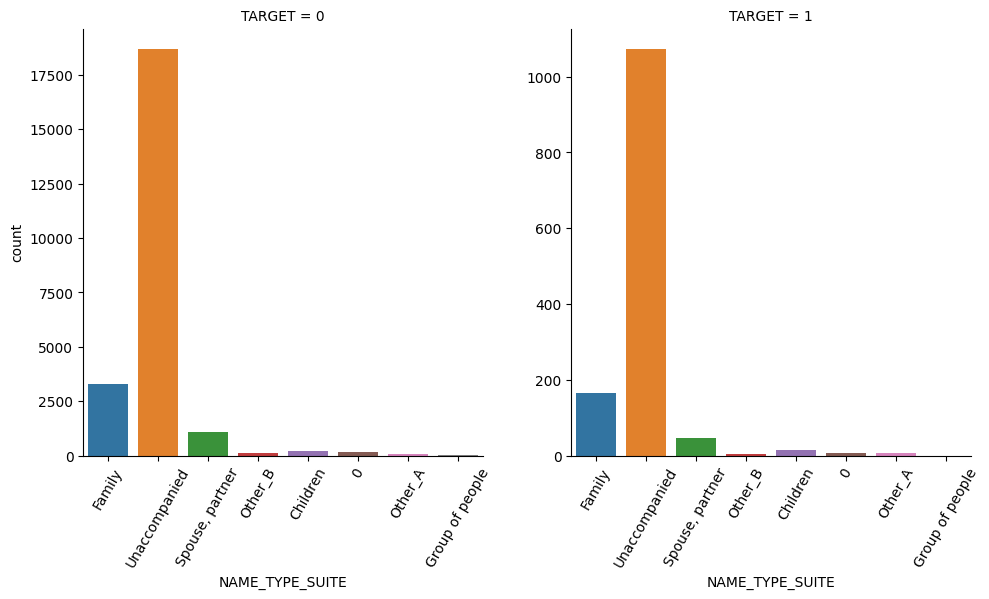

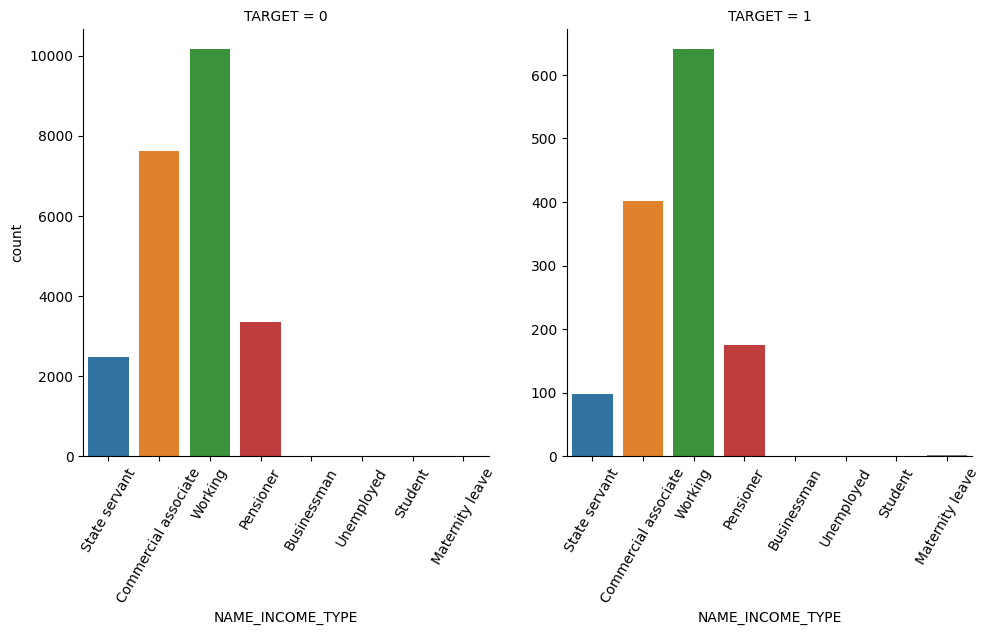

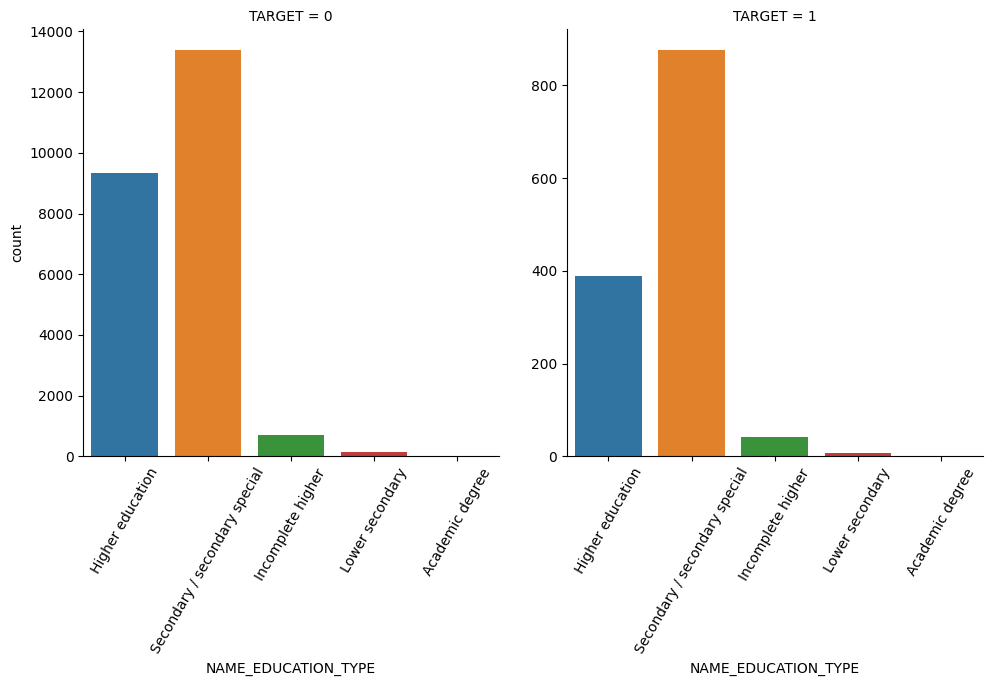

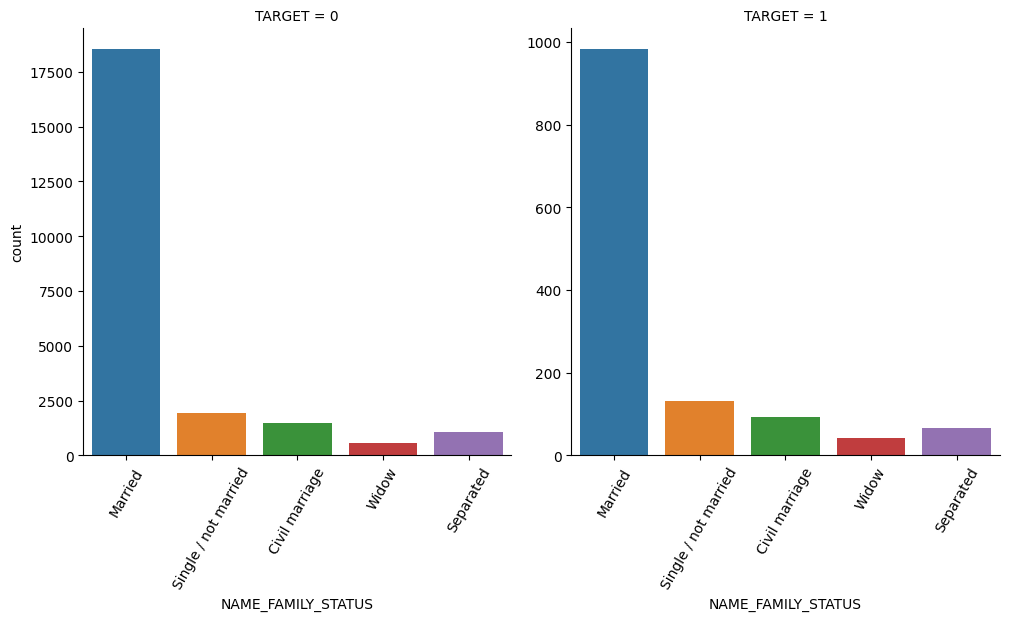

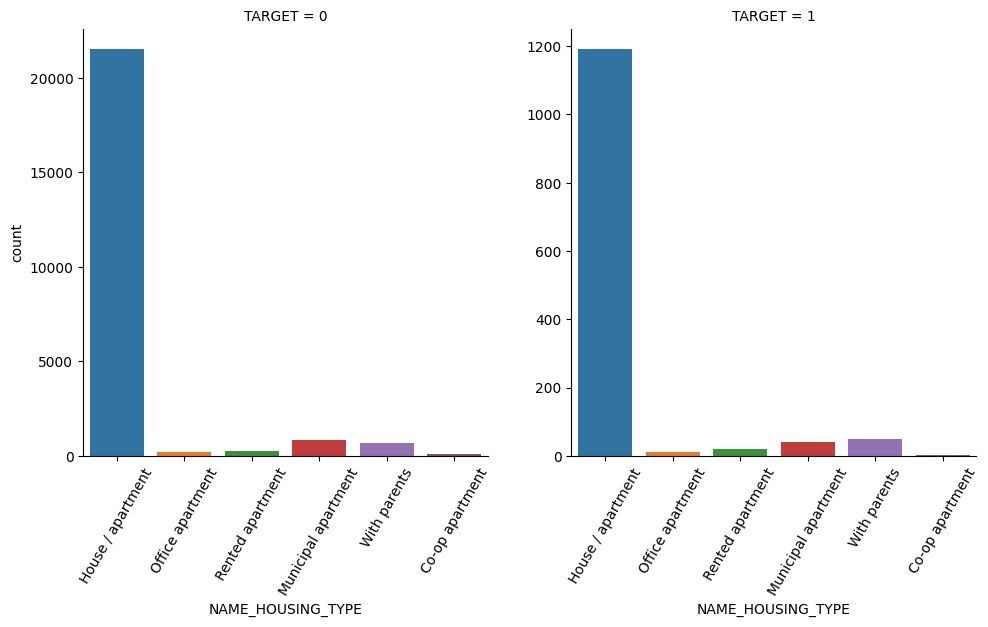

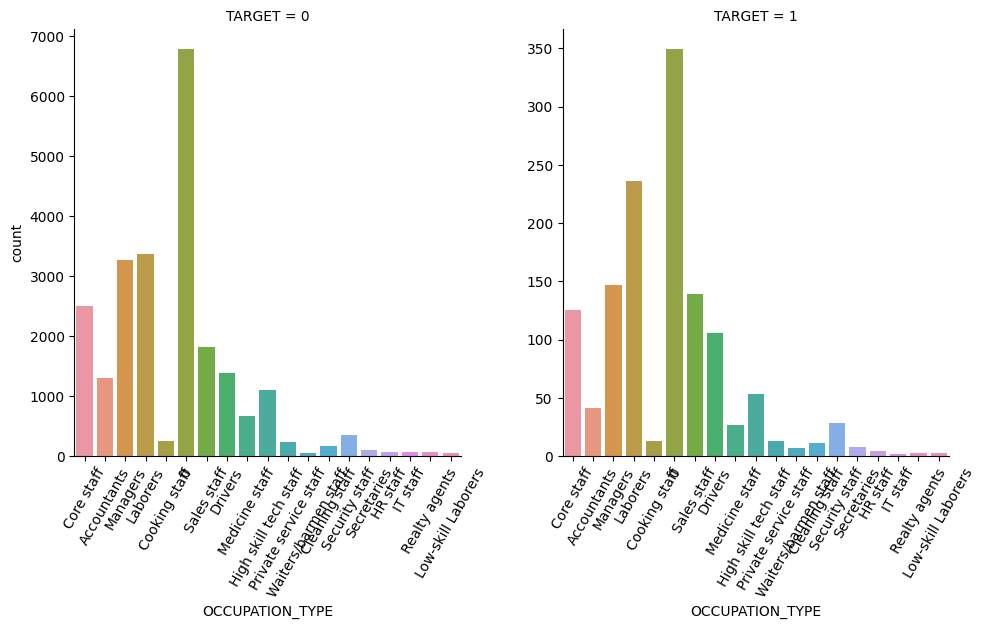

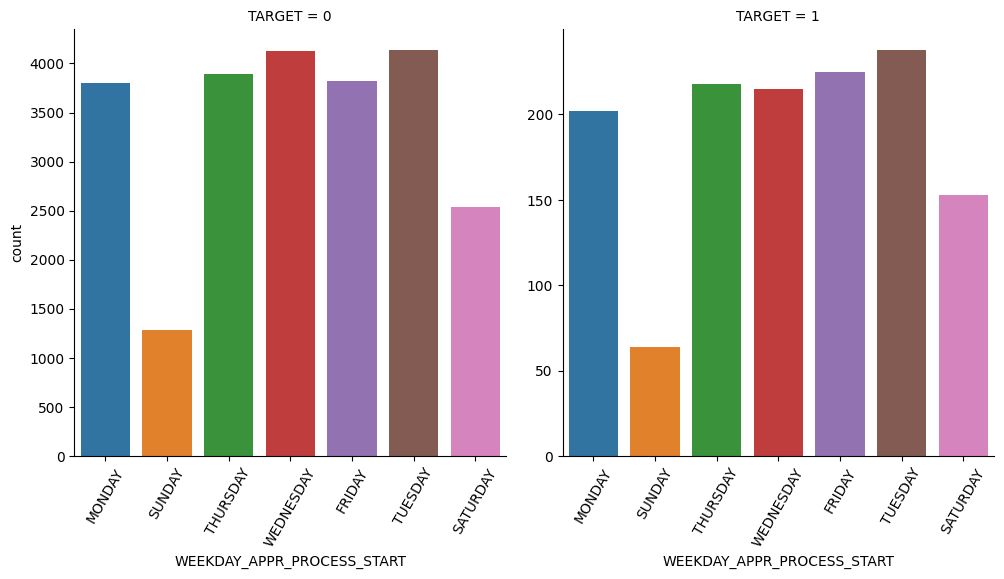

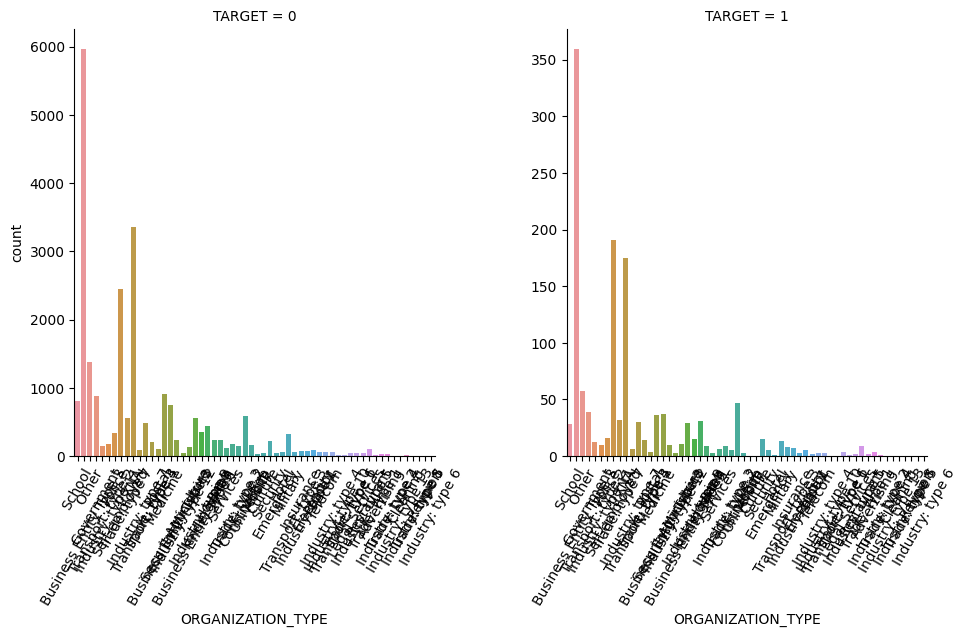

In [255]:
# Проверим распределение таргета от некоторых теоретически наиболее значимых признаков

for col in object_columns_full:
    g = sns.catplot(x=col, kind='count', col='TARGET', data=data_mortgage_full, sharey=False)
    g.set_xticklabels(rotation=60)

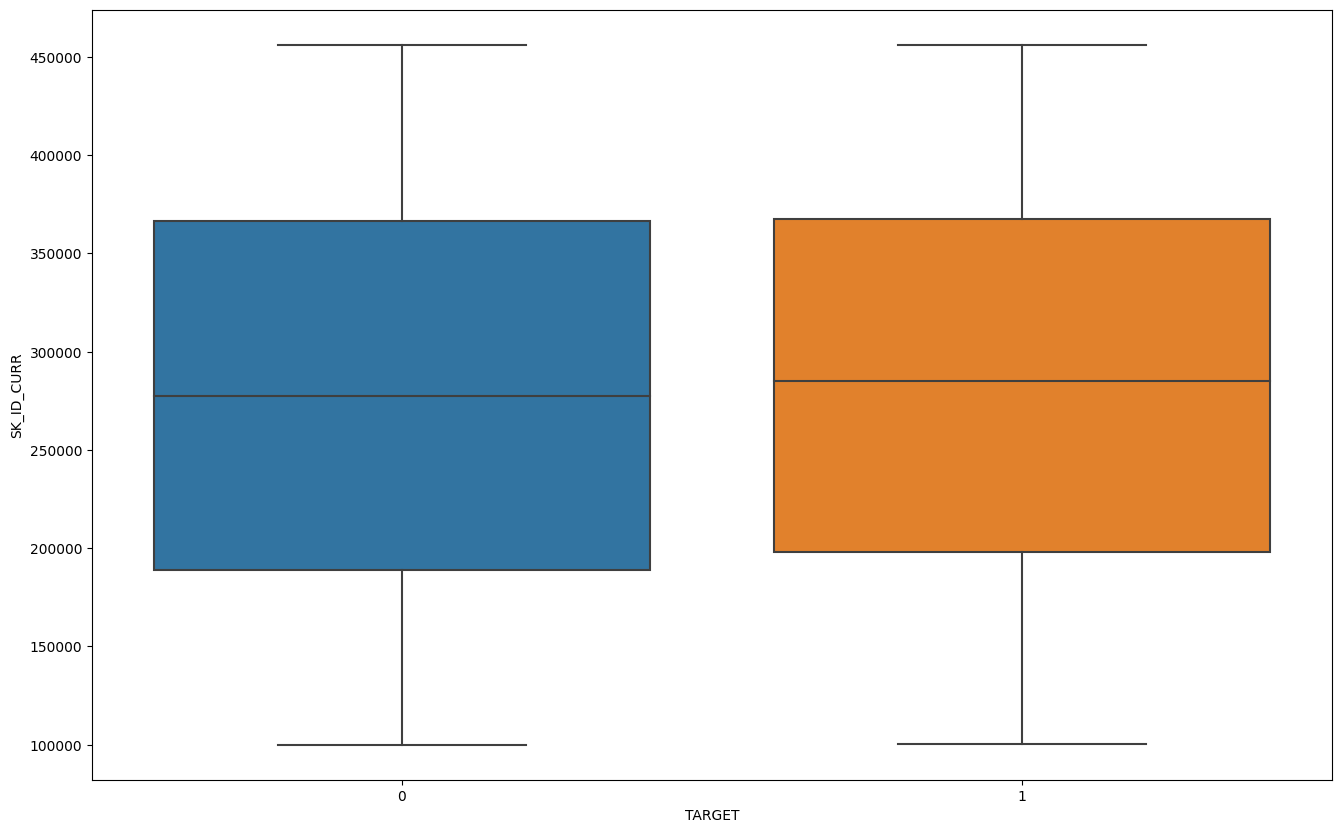

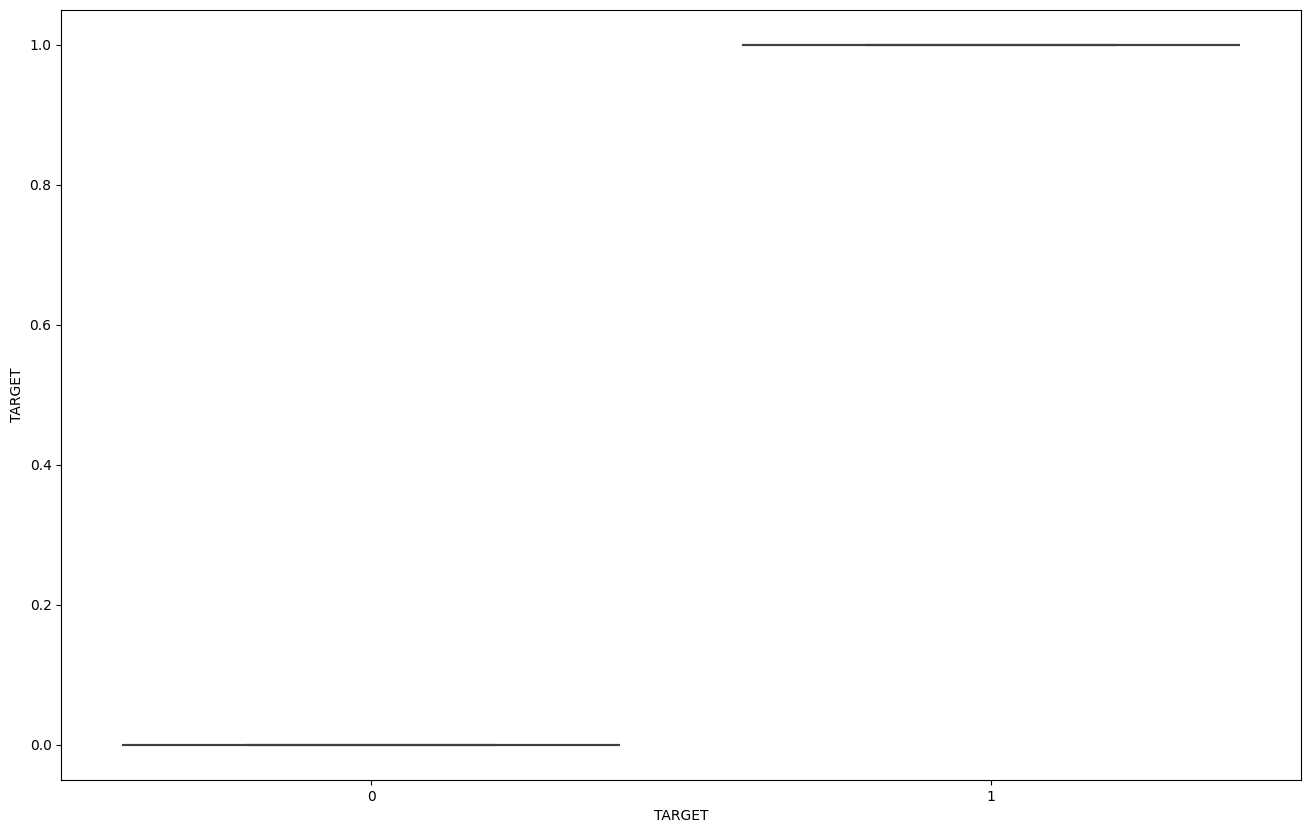

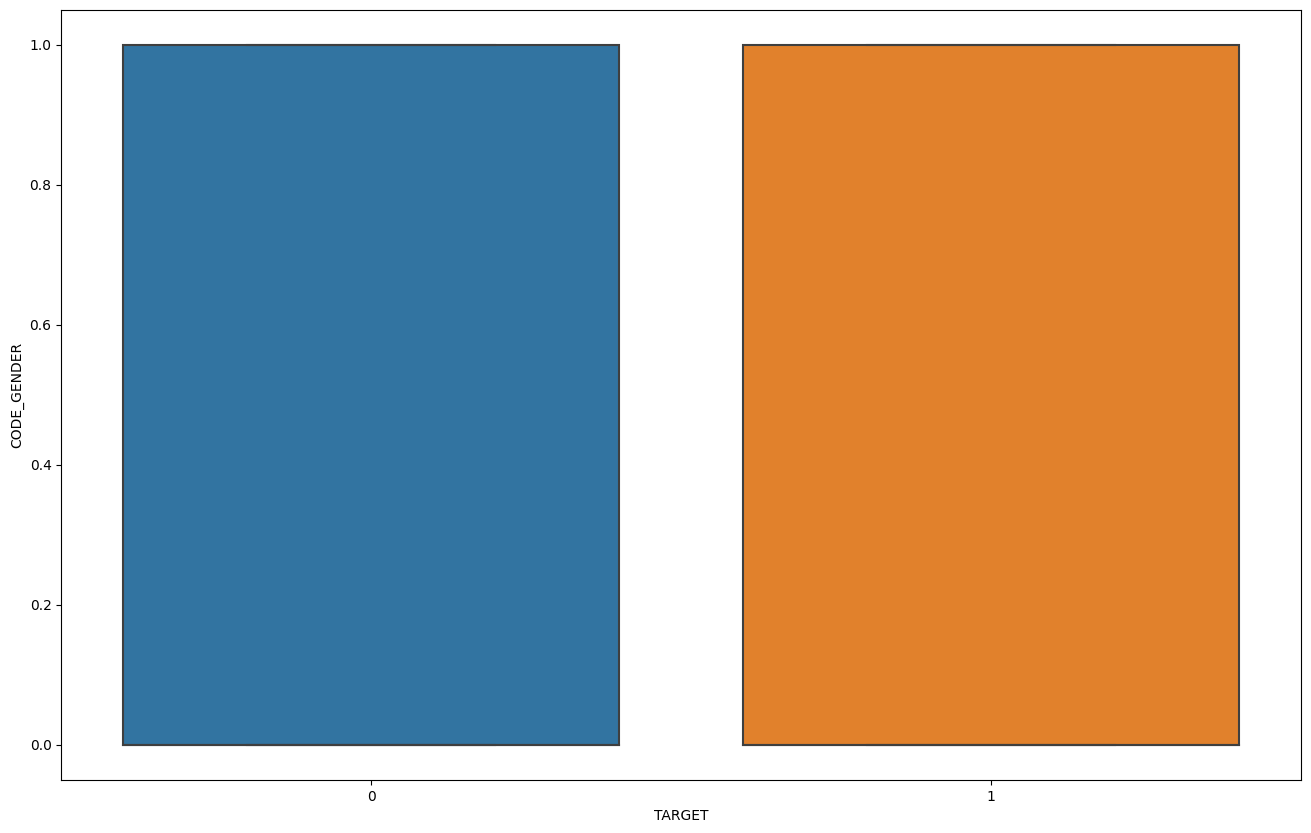

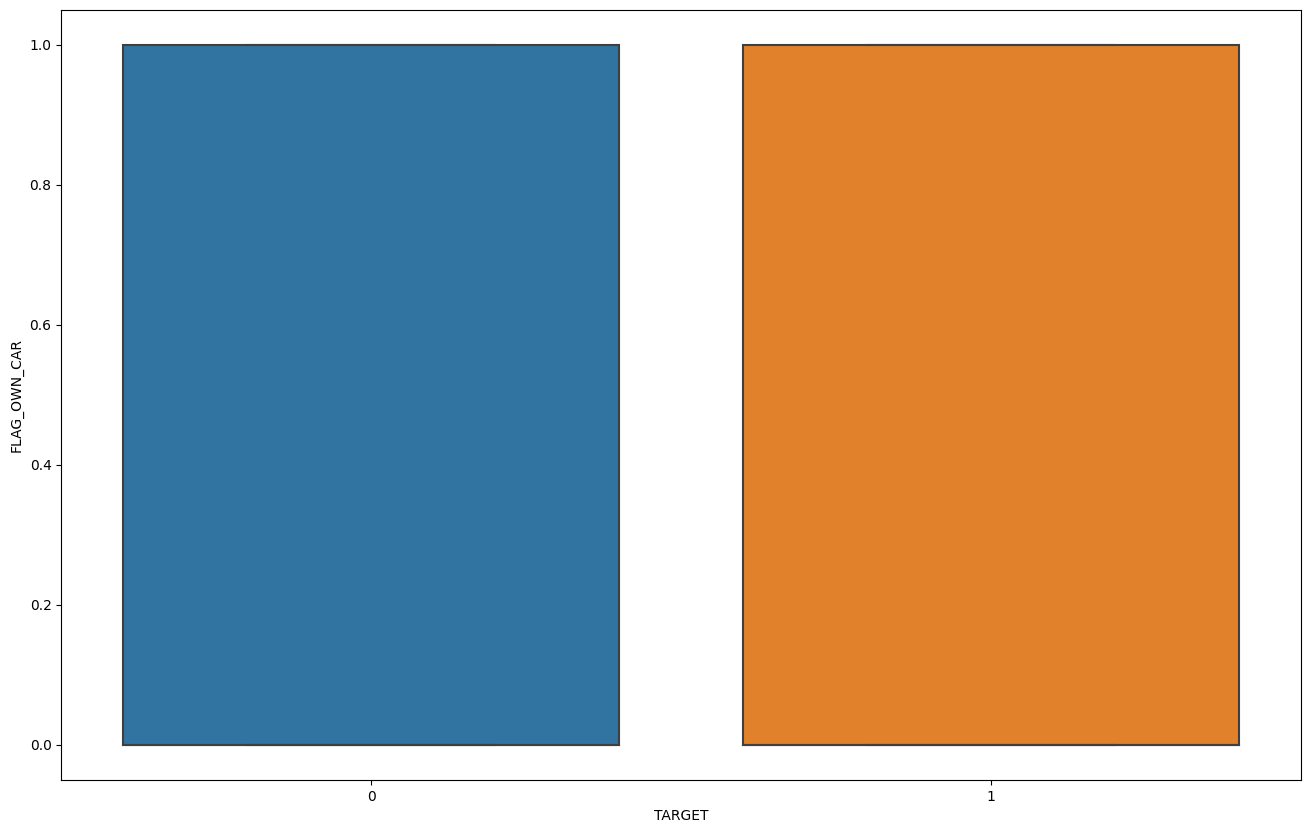

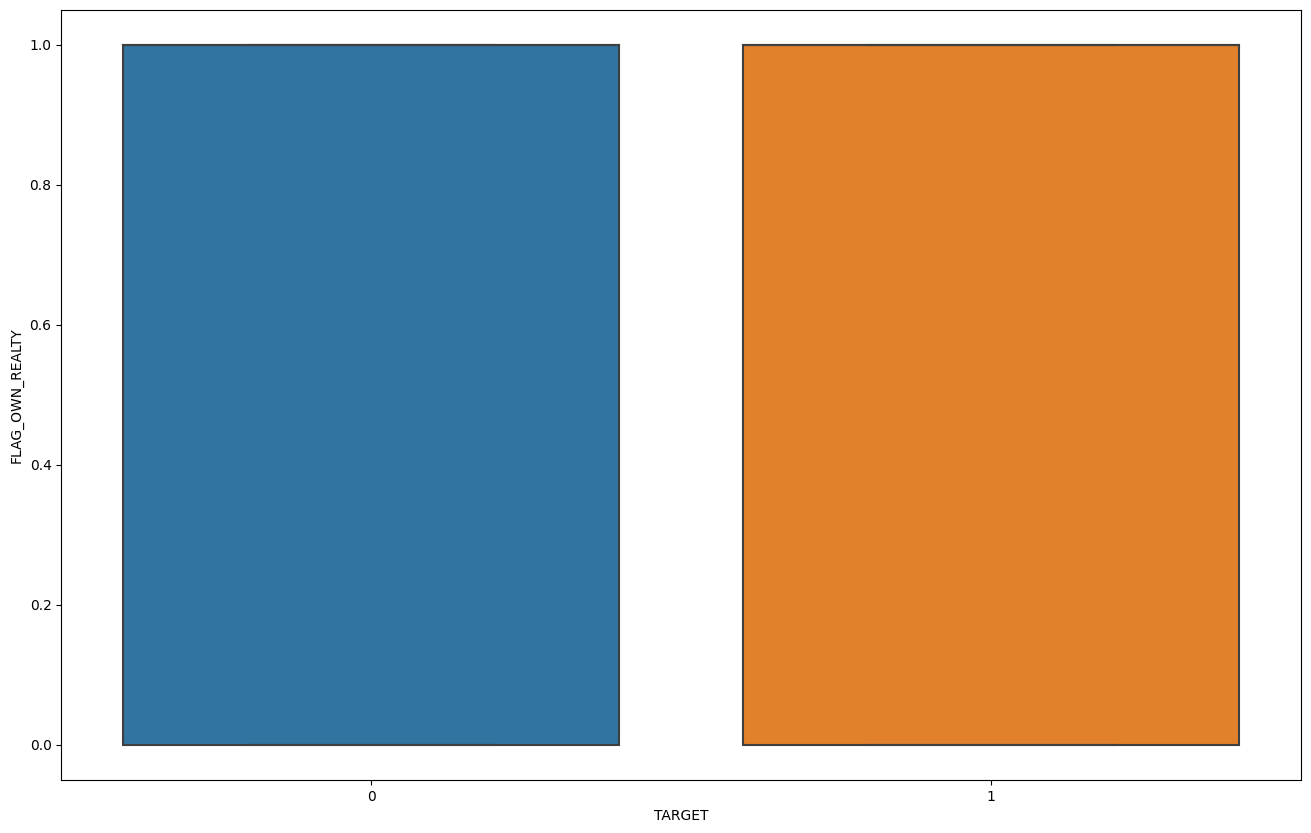

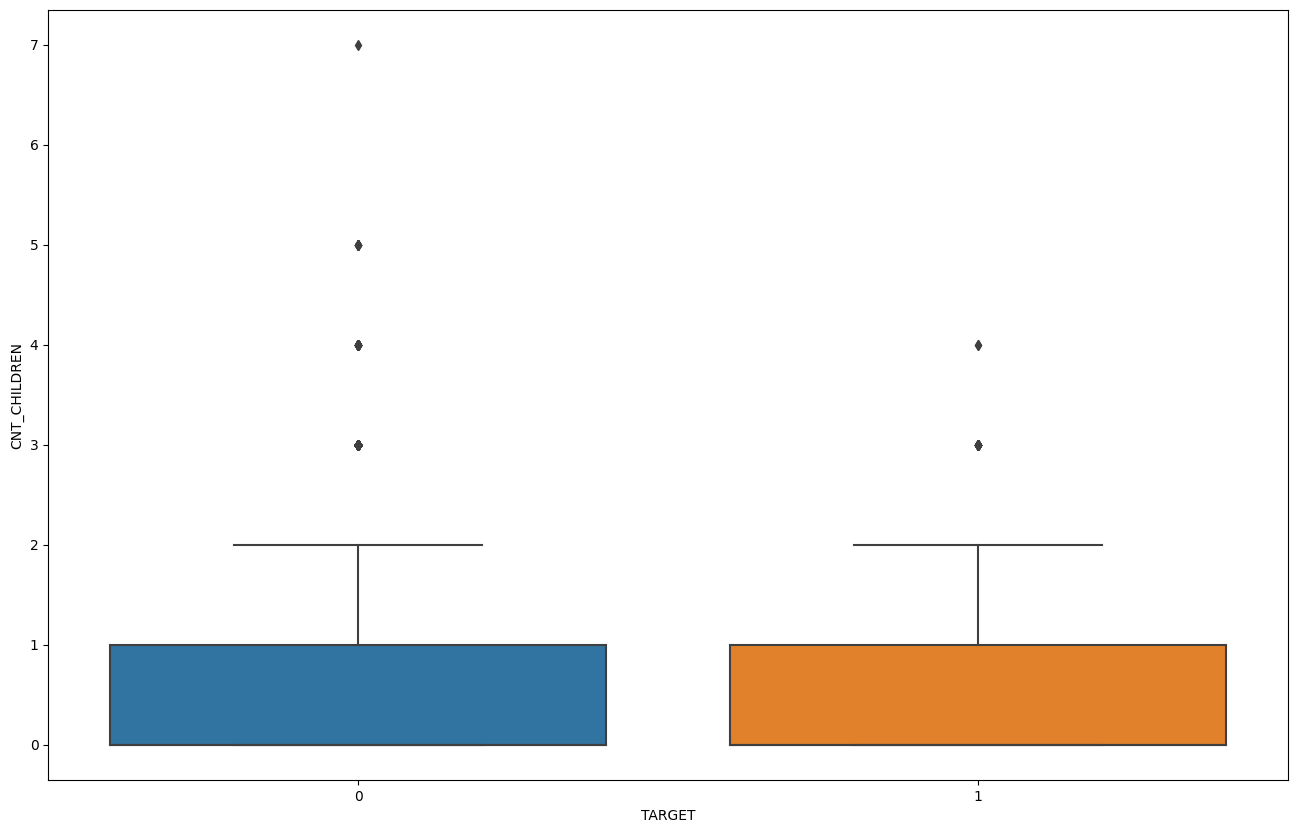

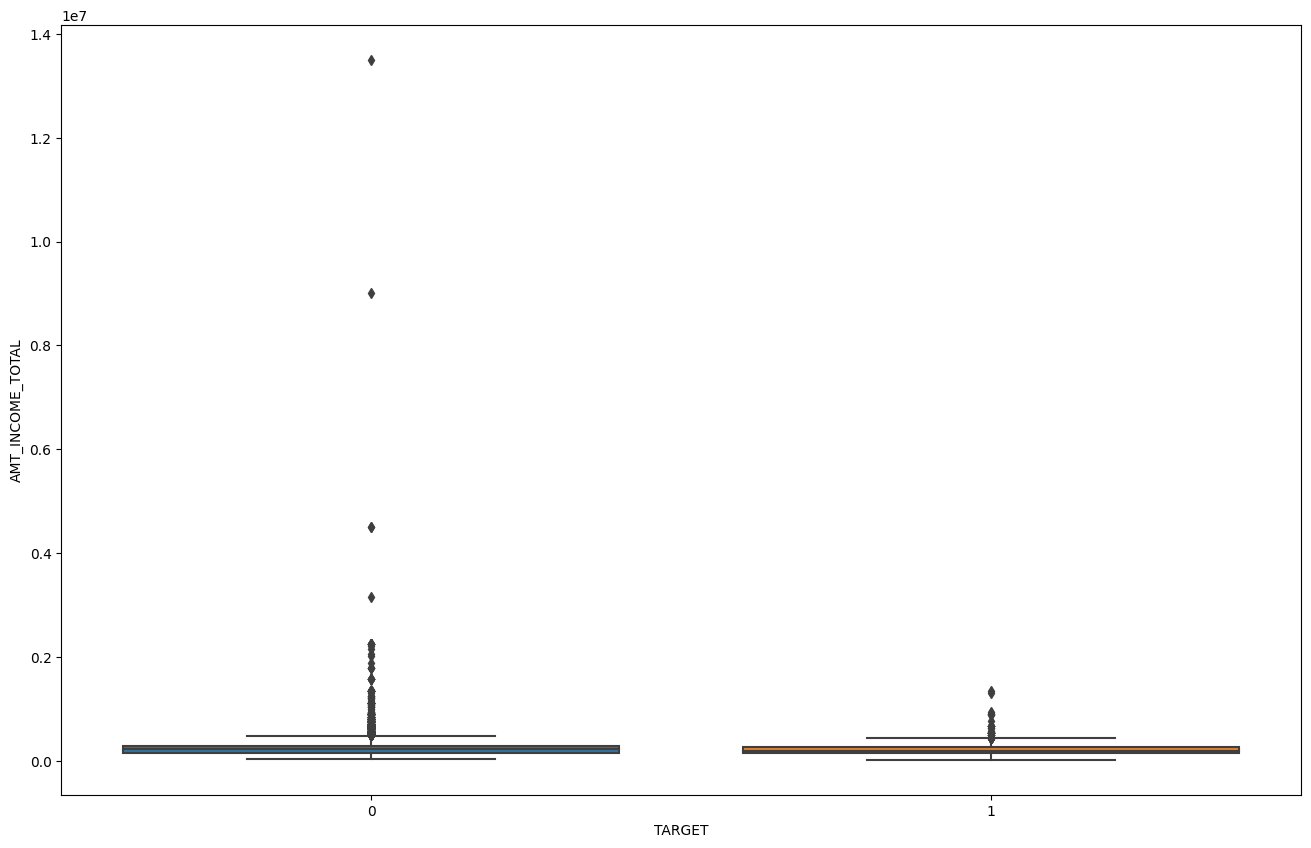

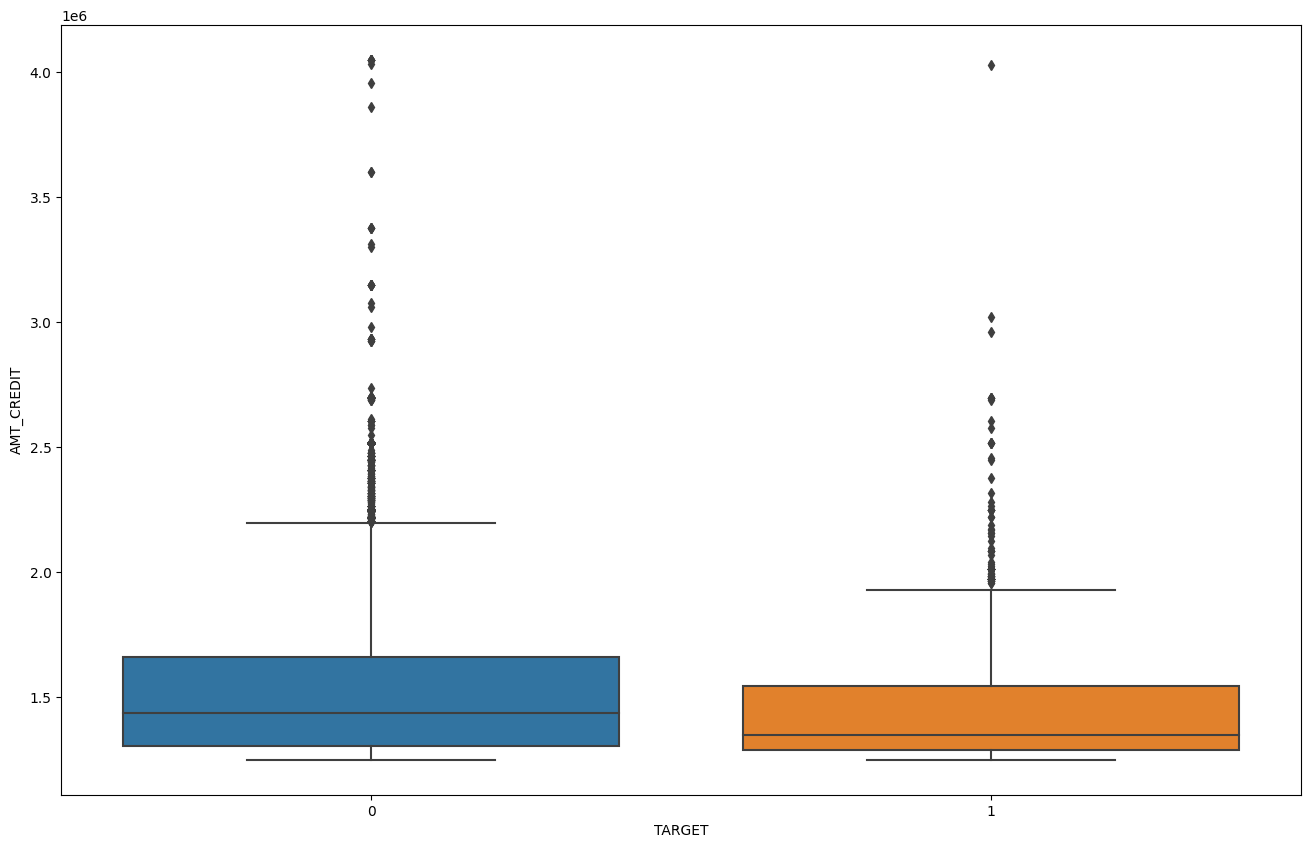

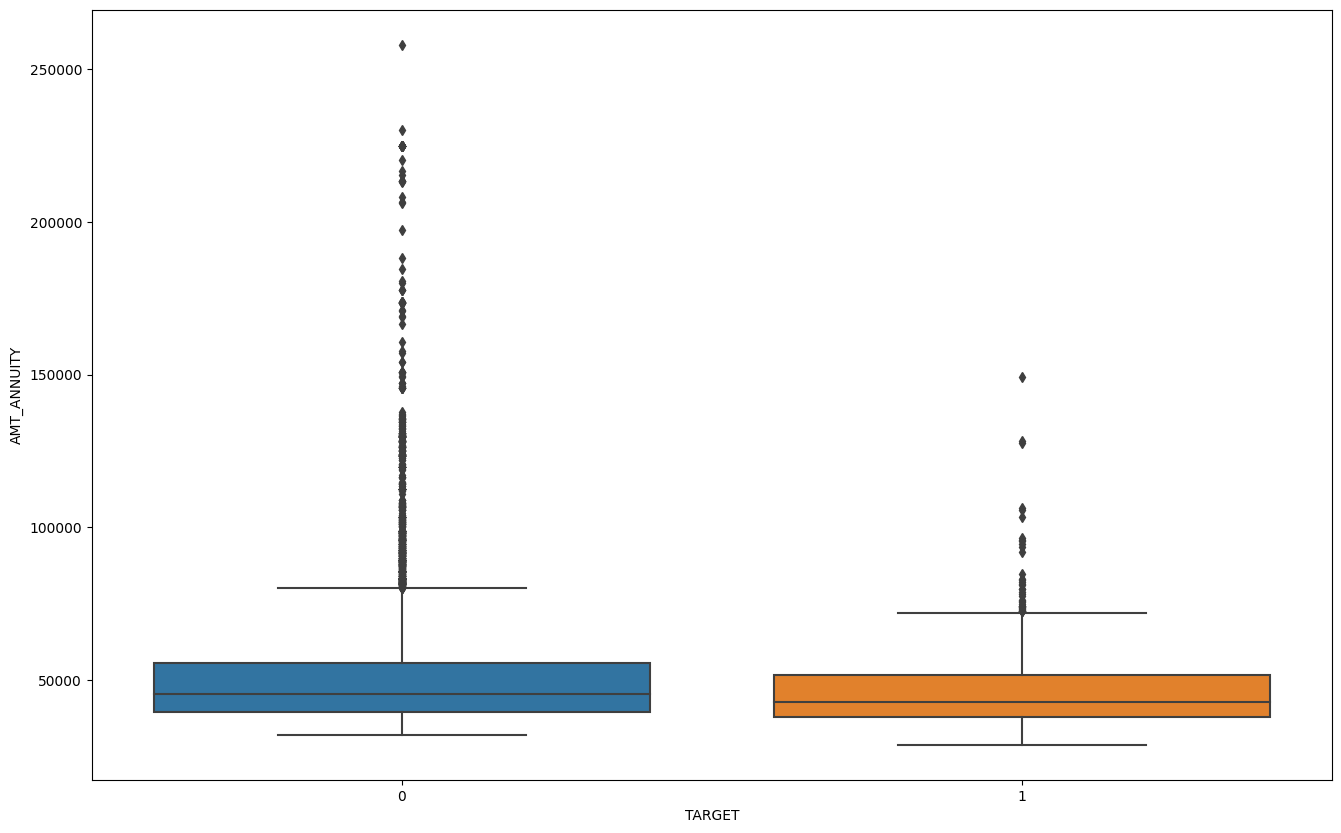

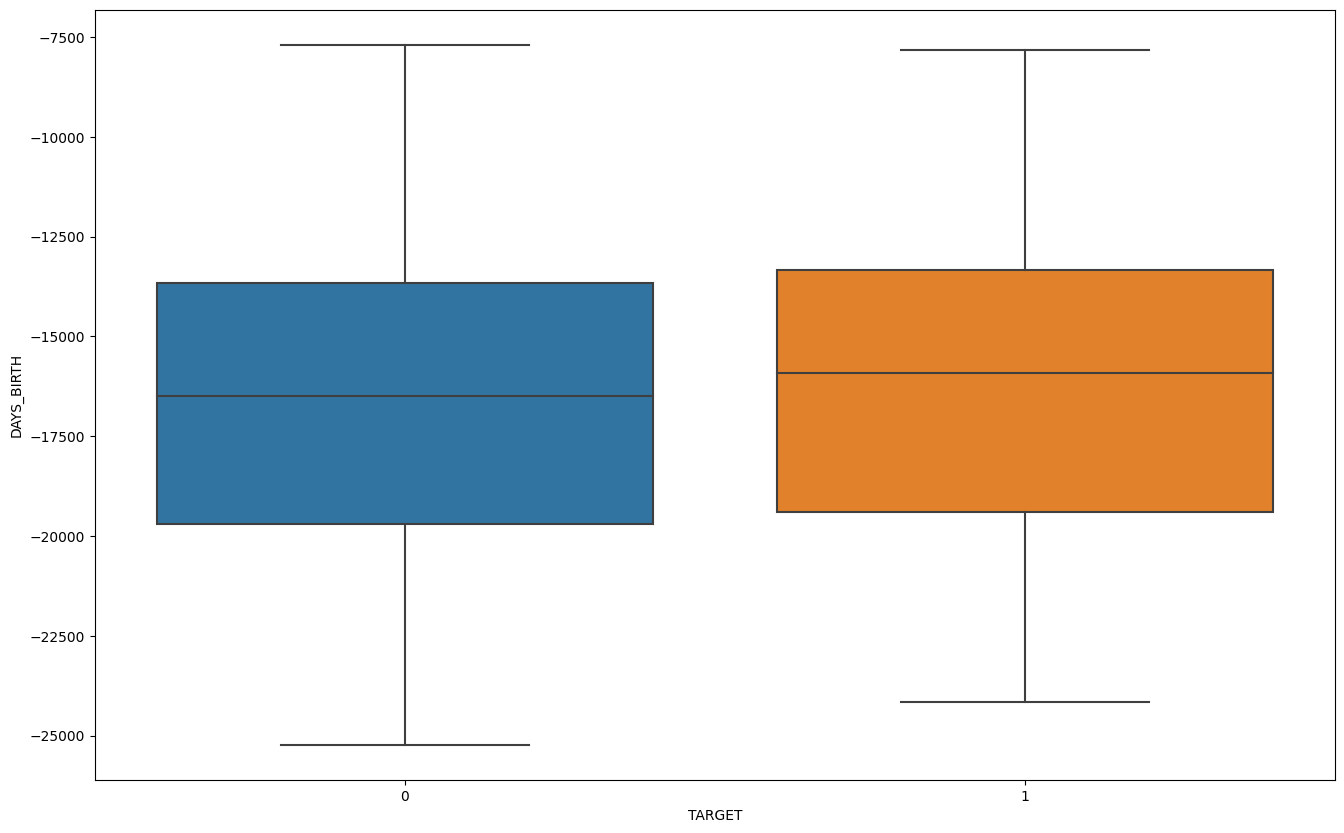

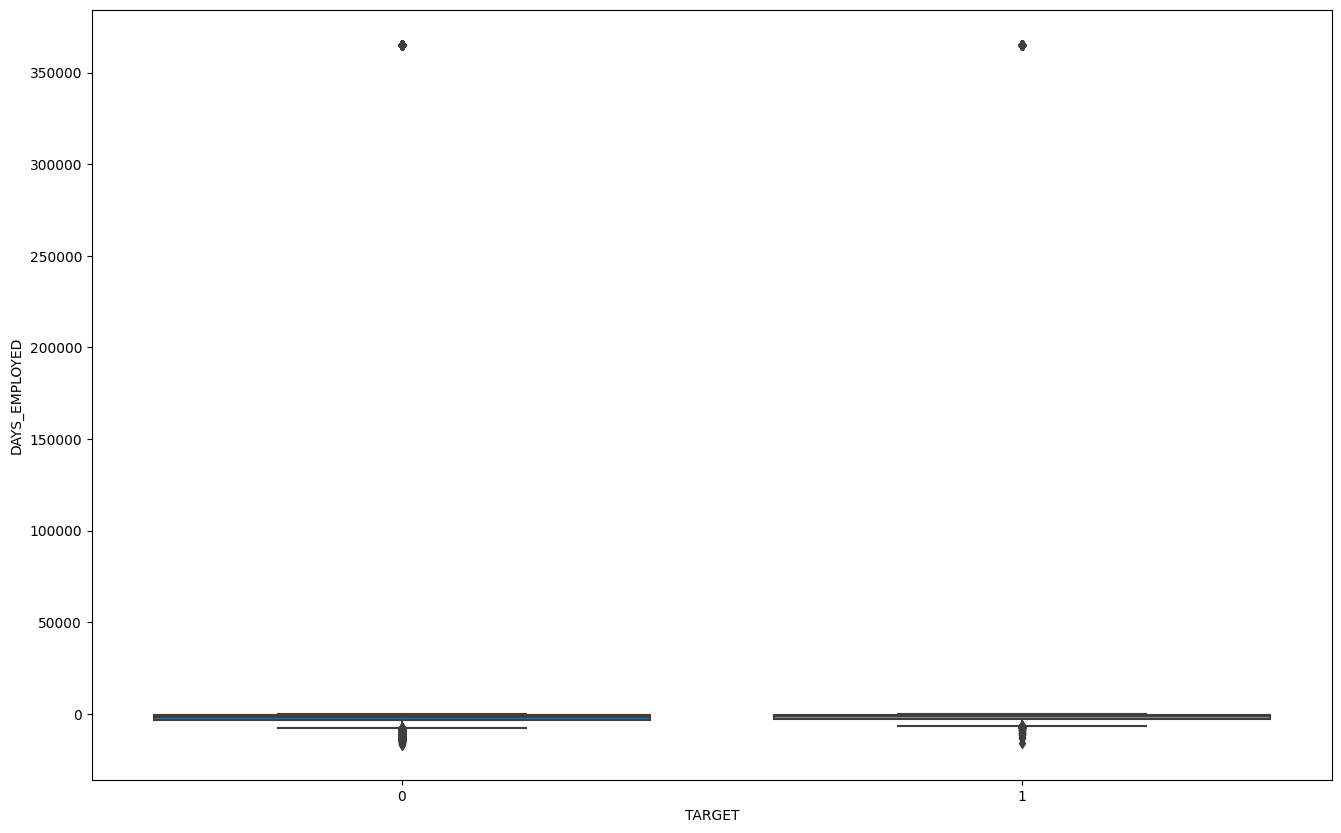

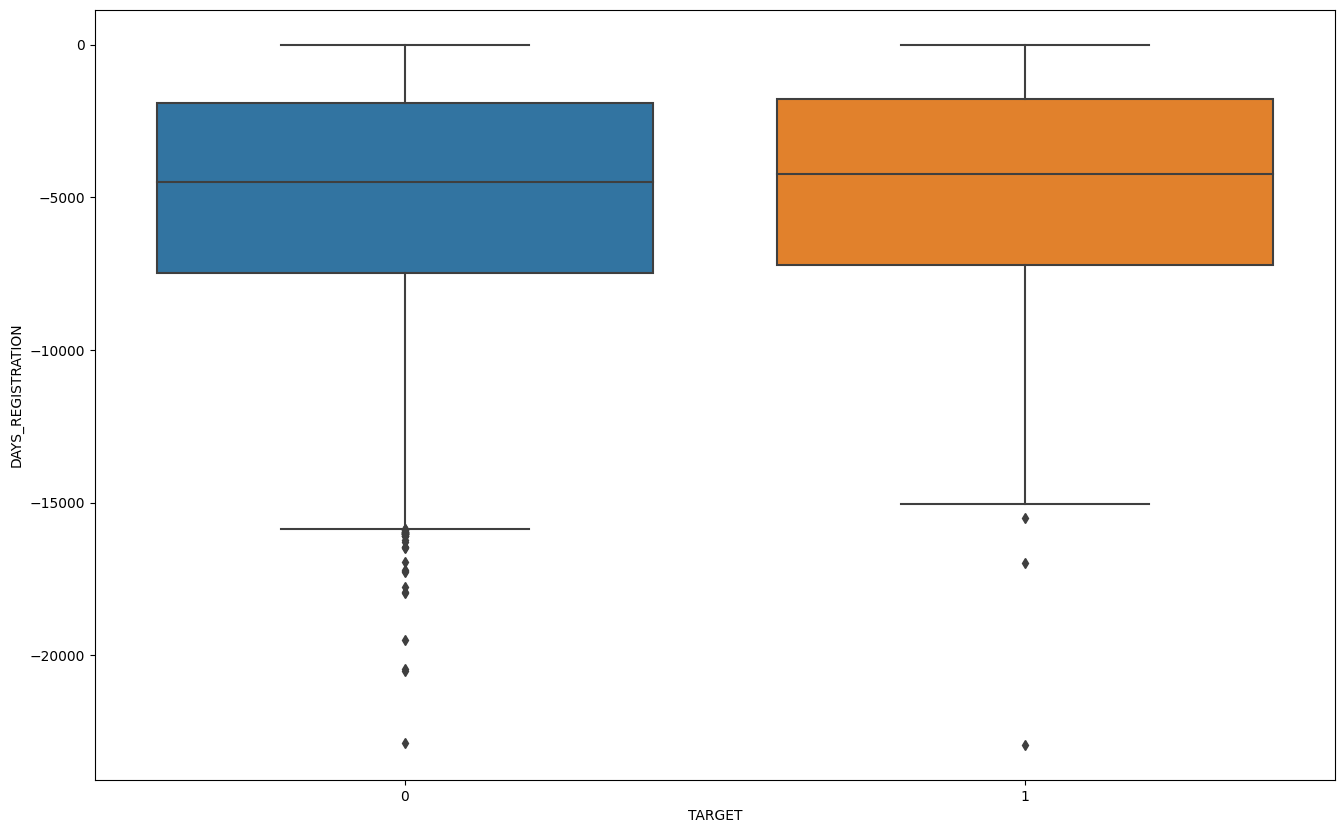

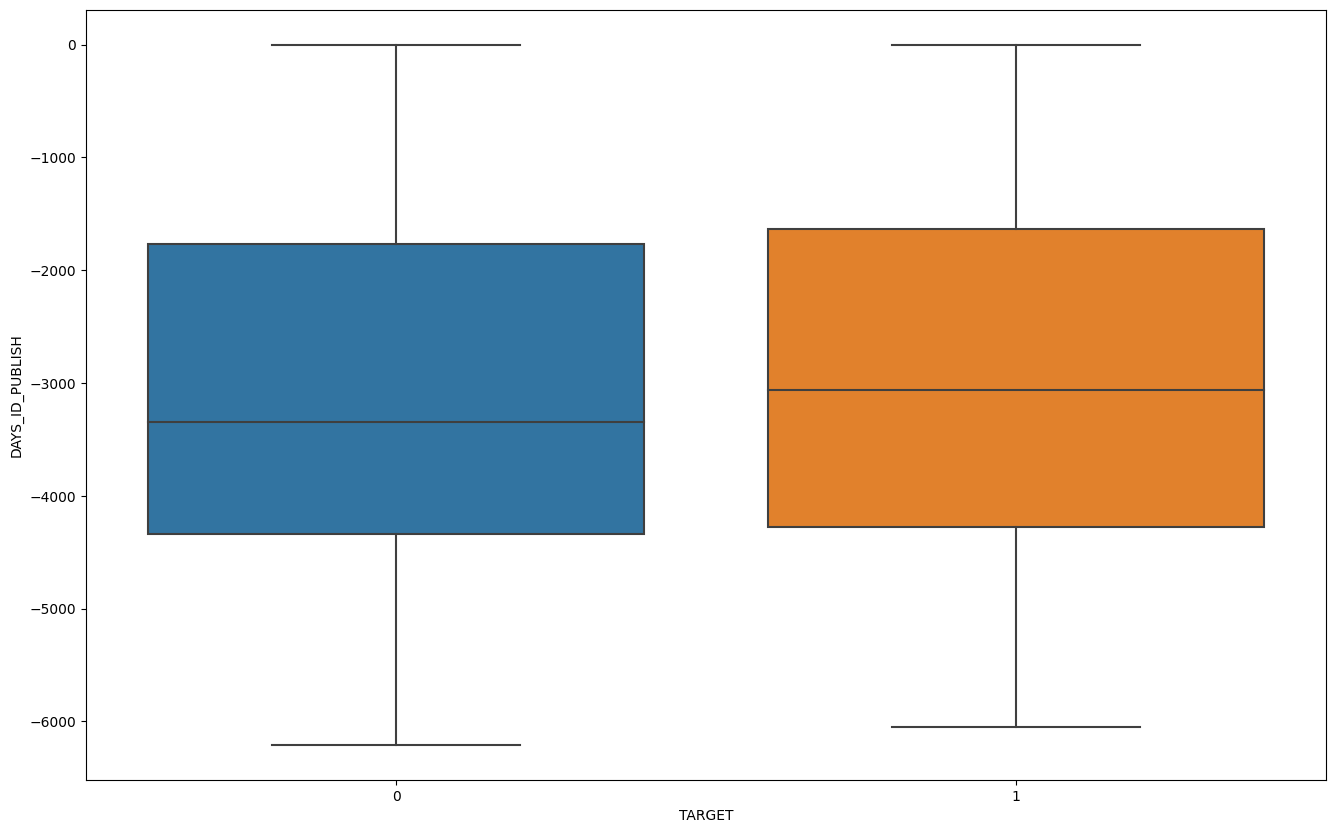

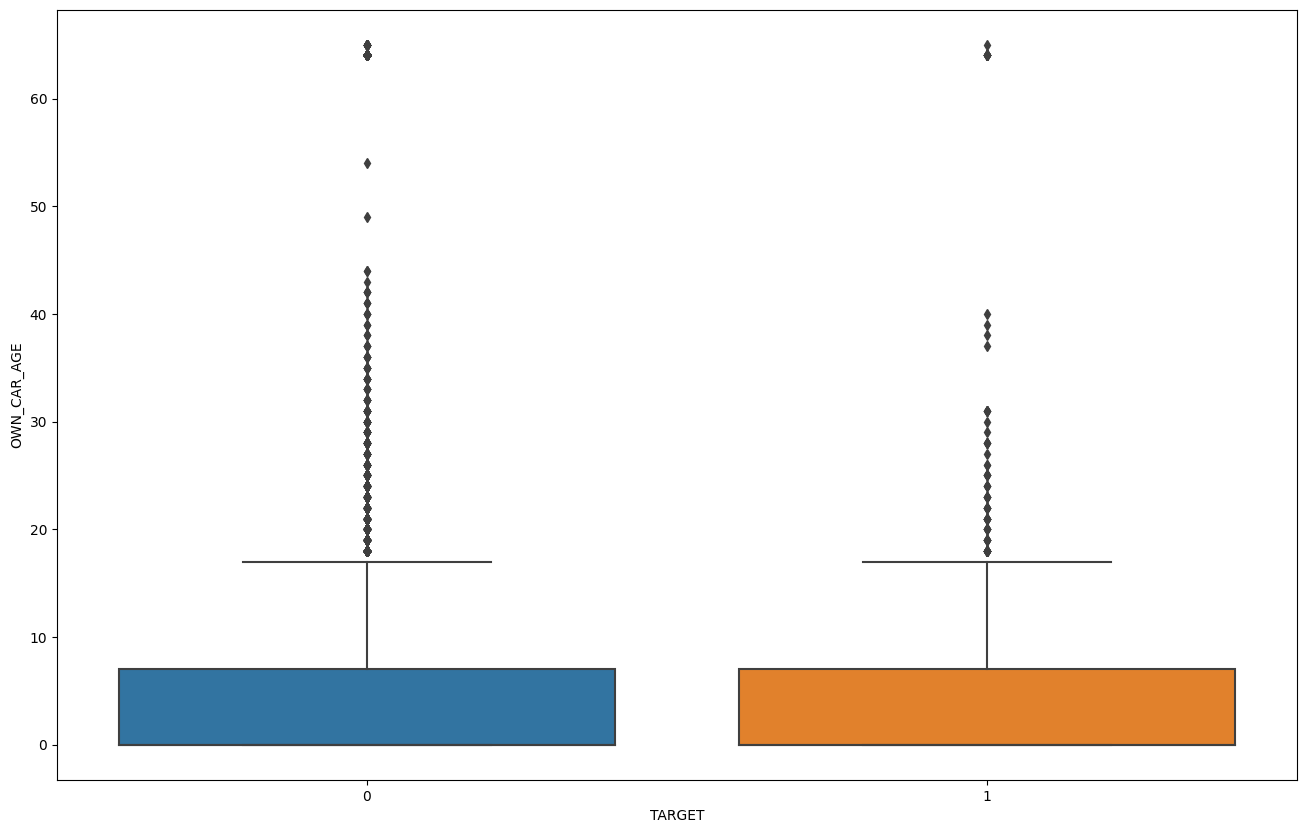

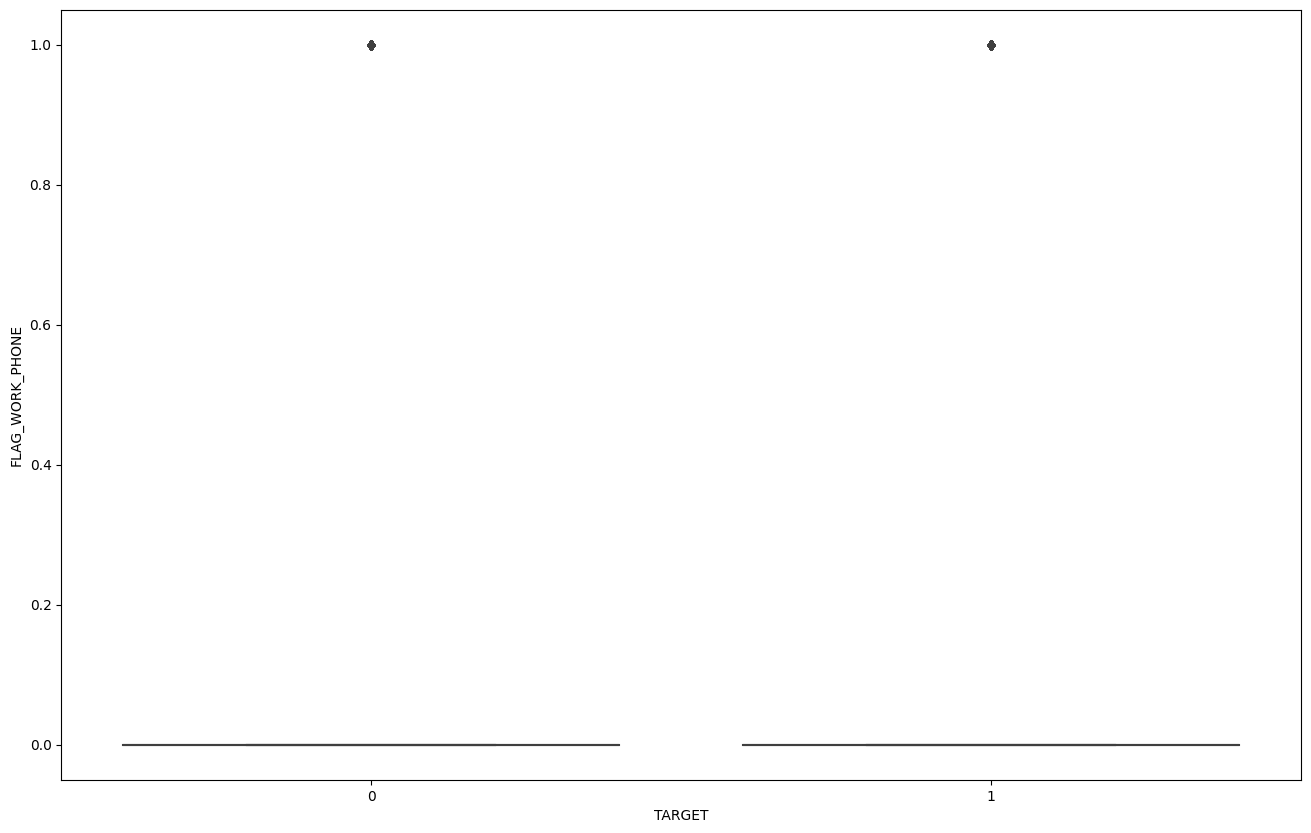

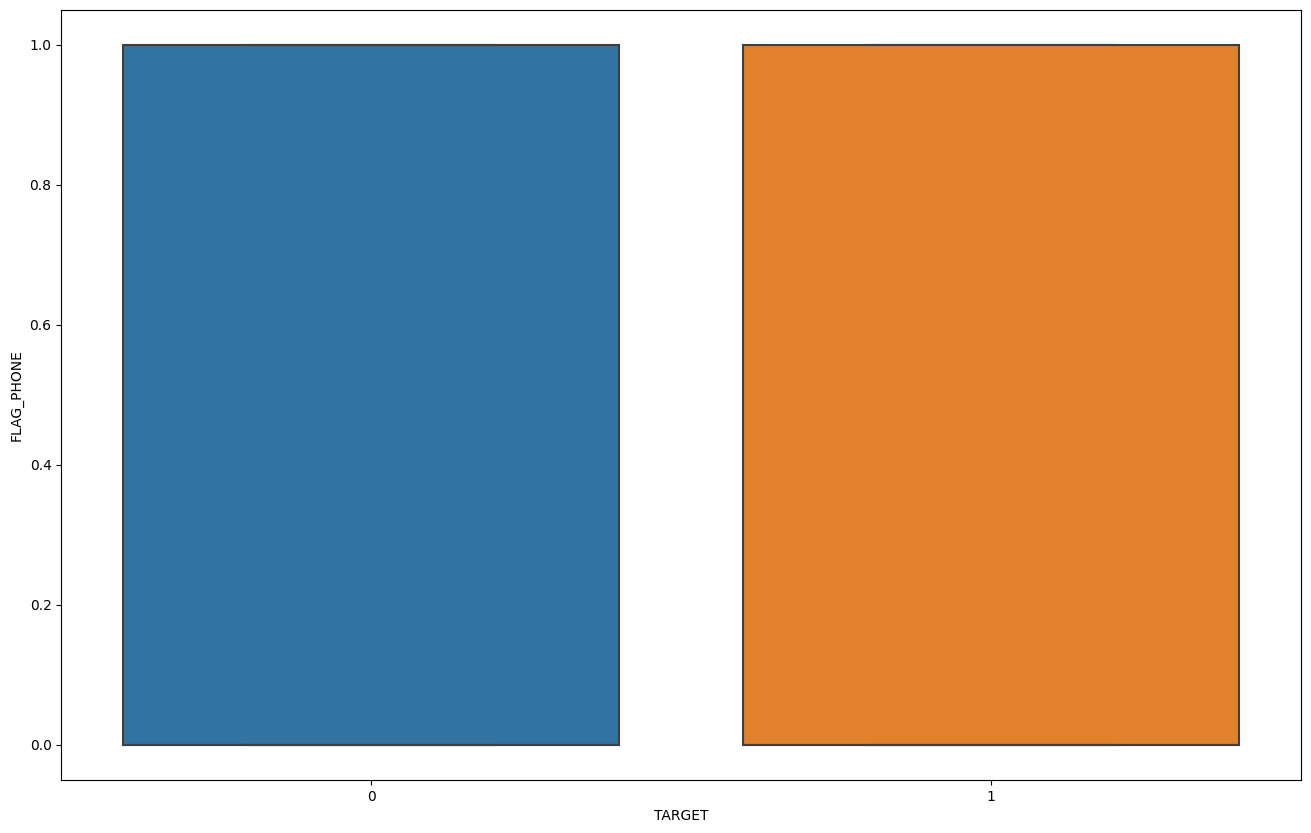

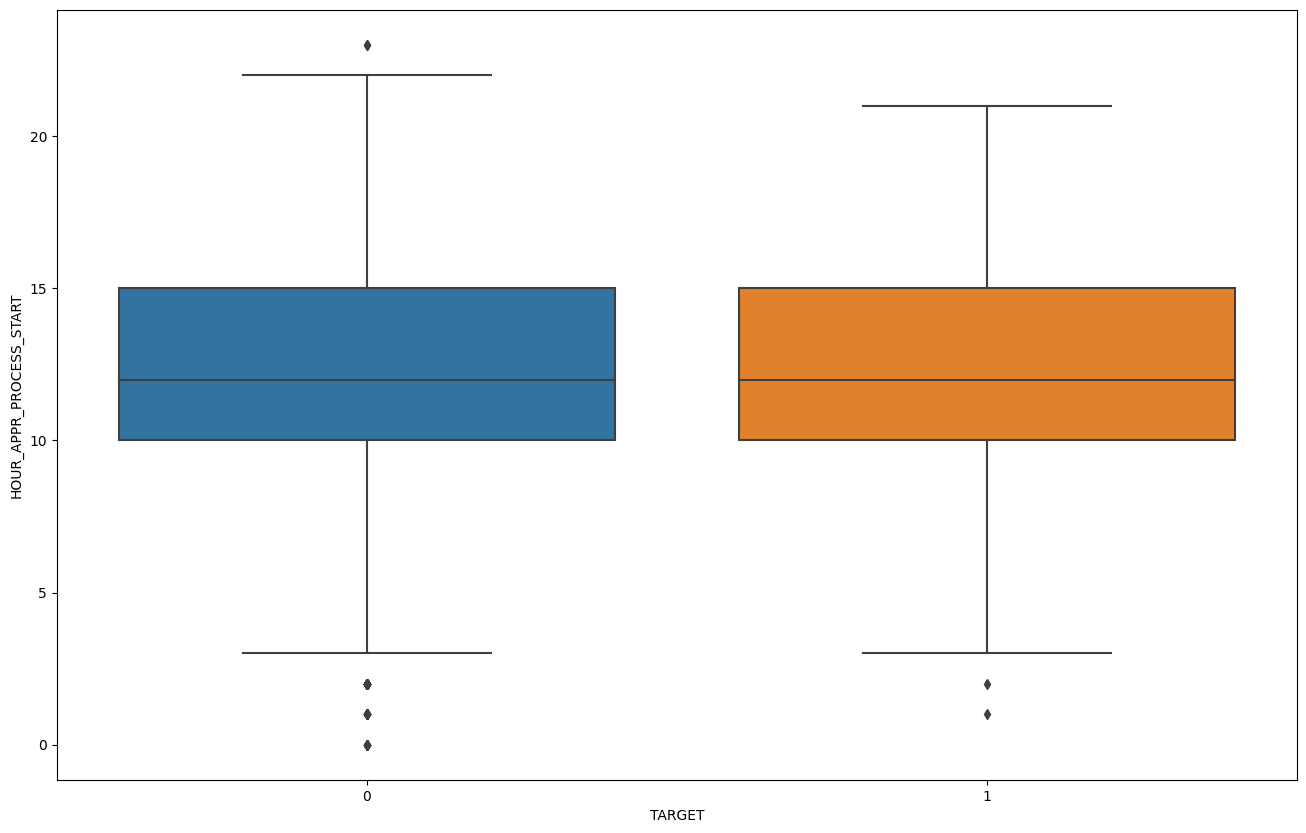

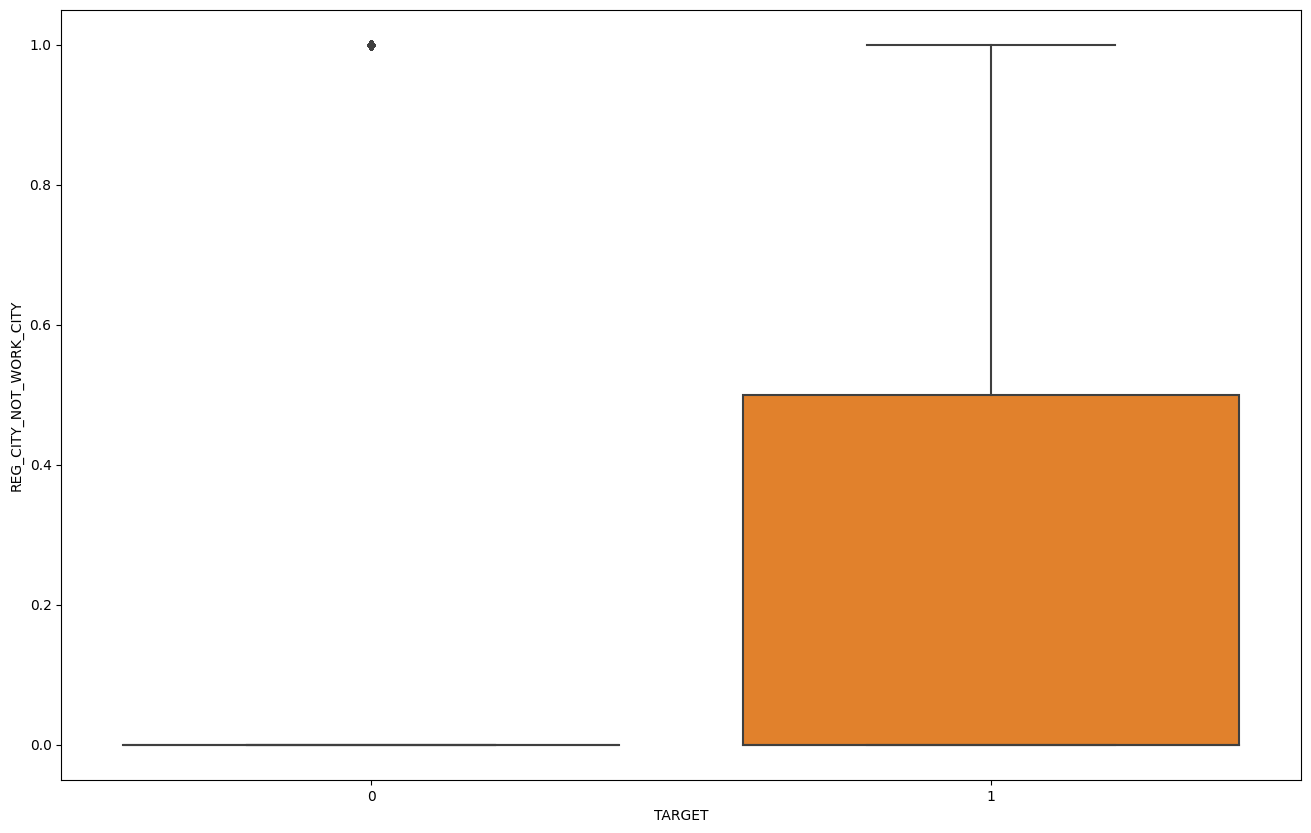

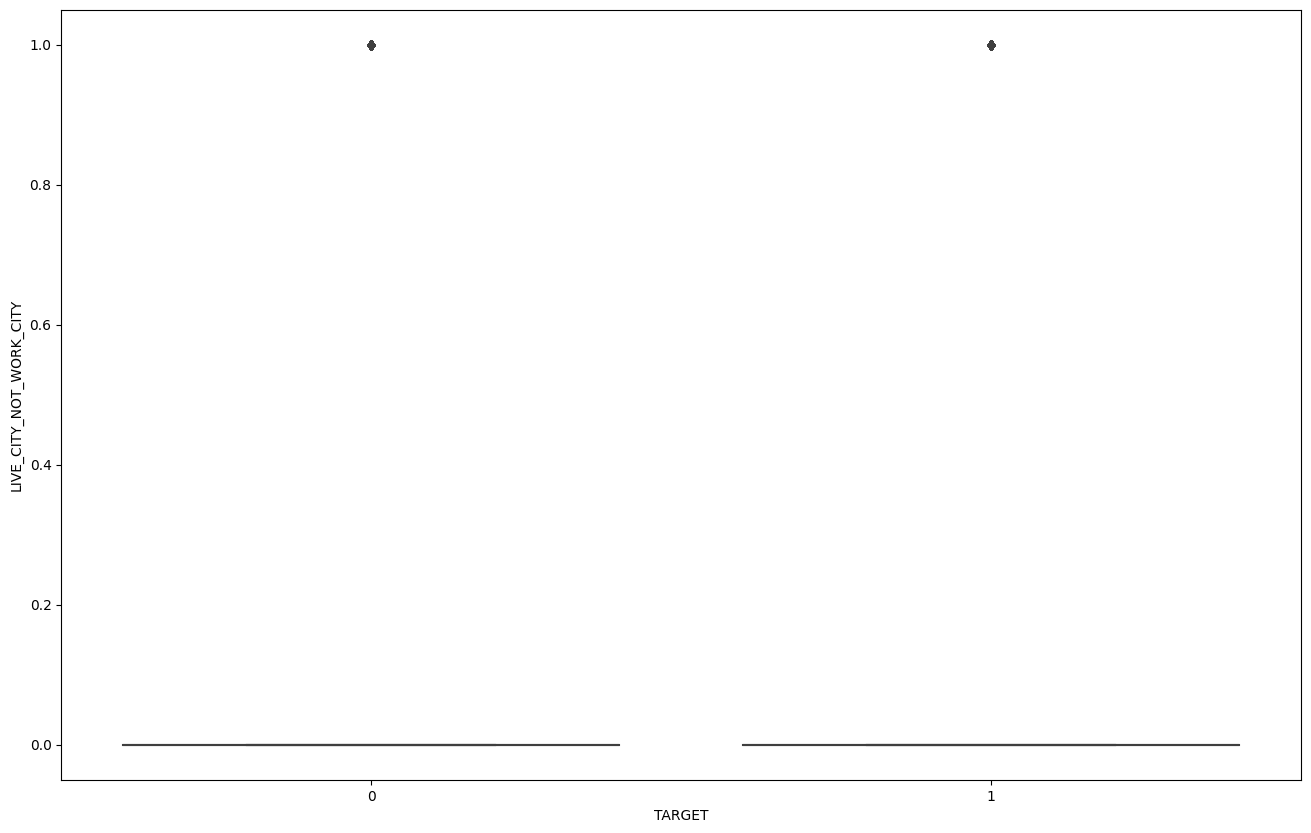

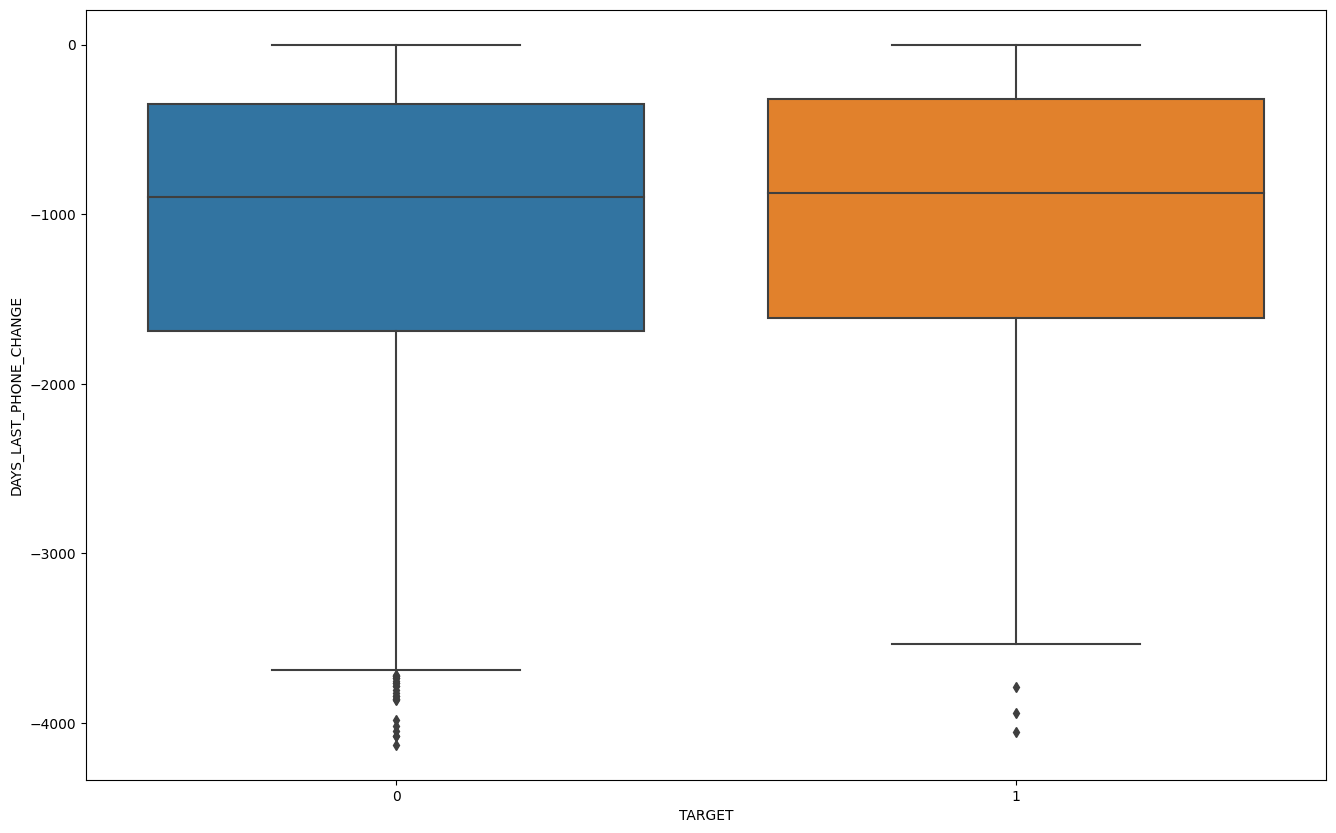

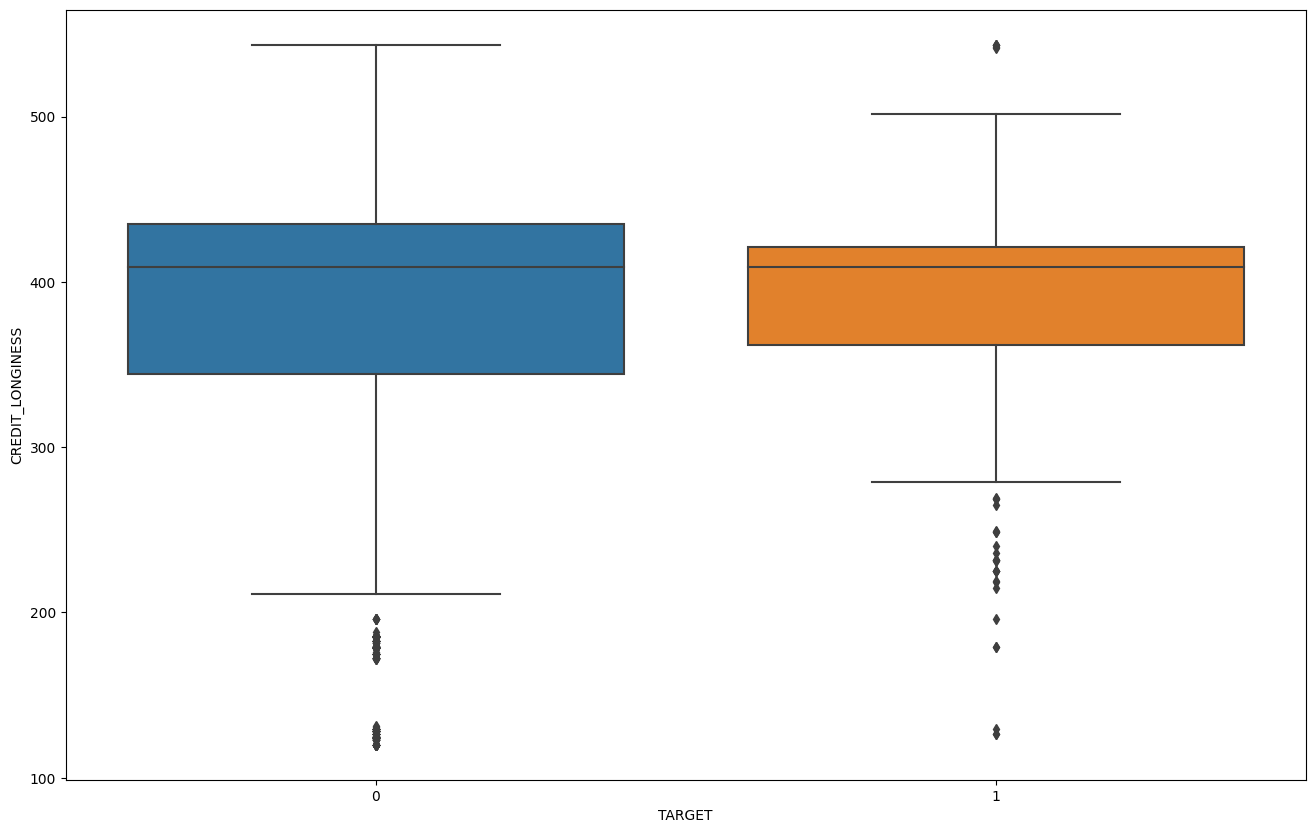

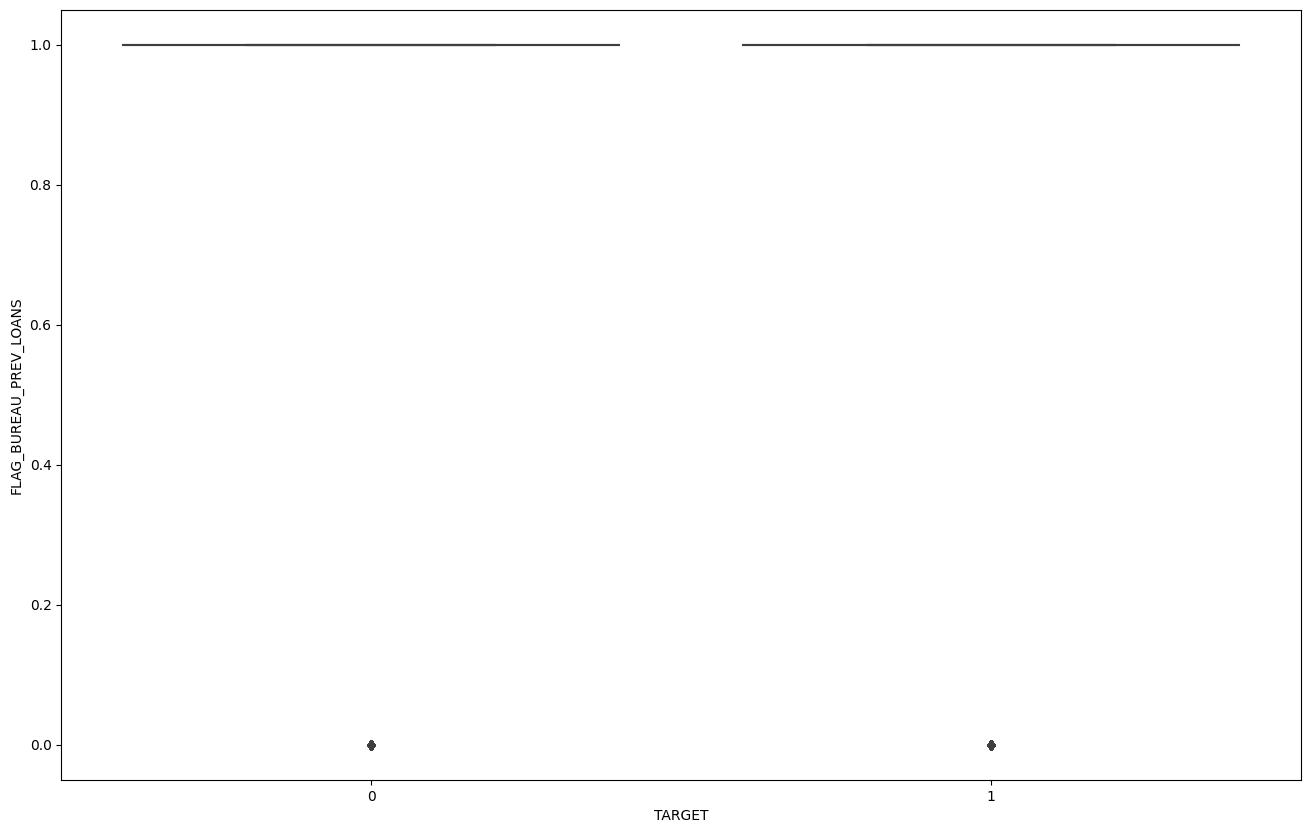

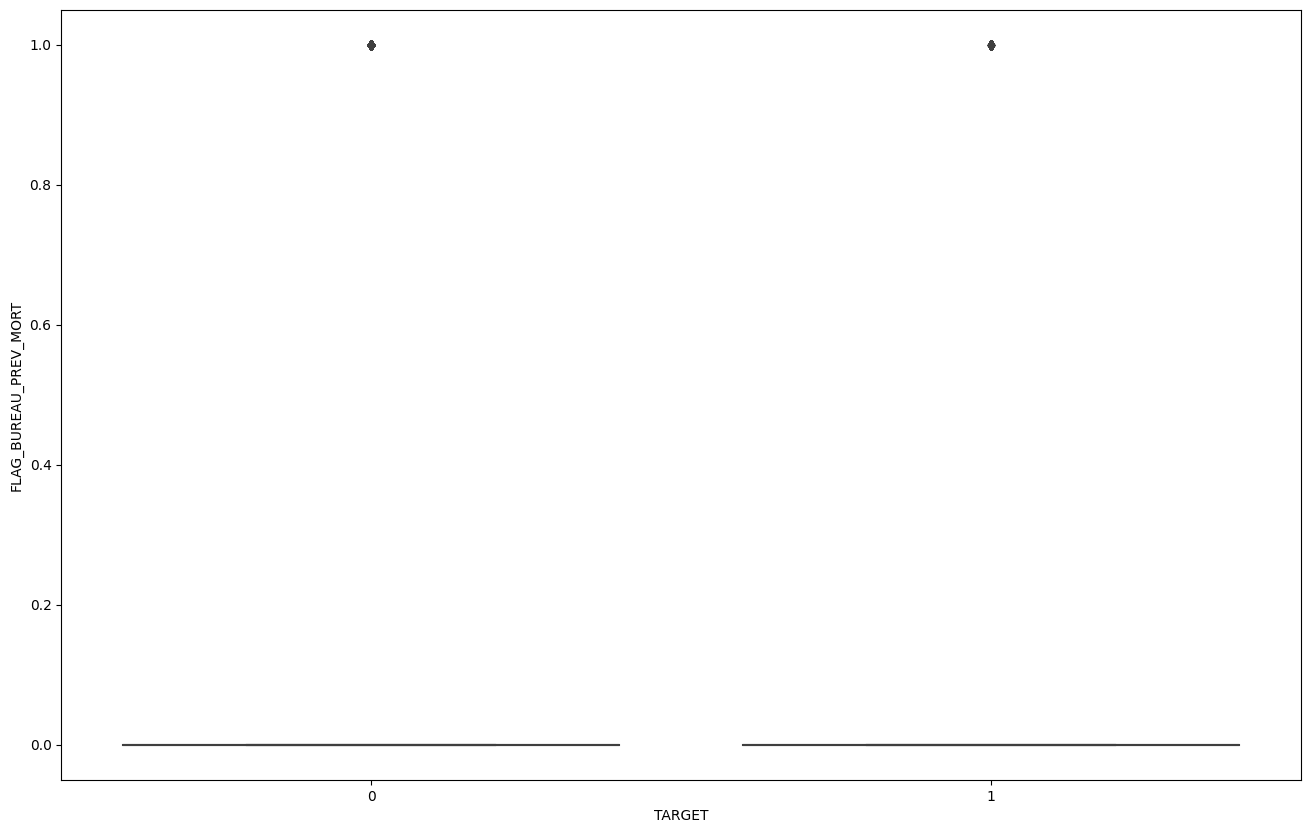

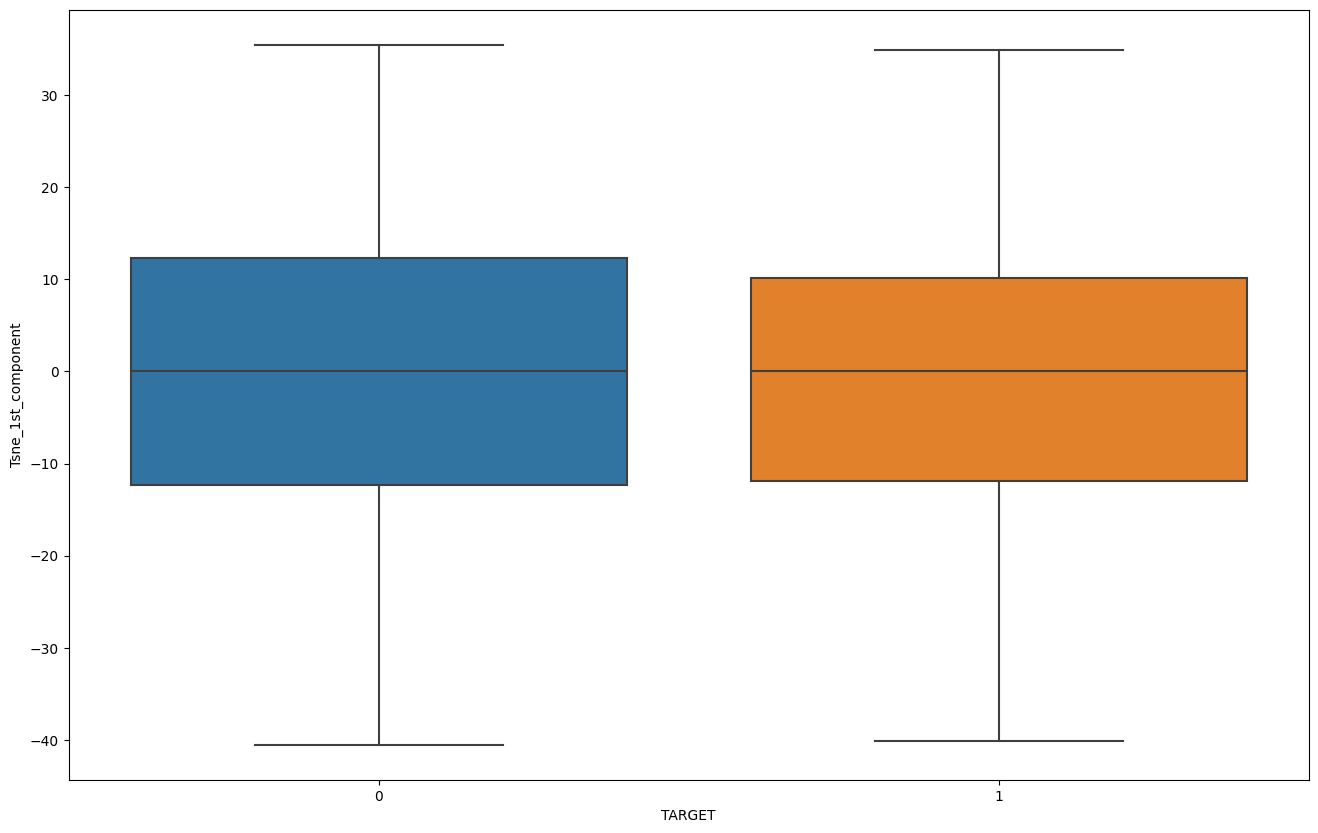

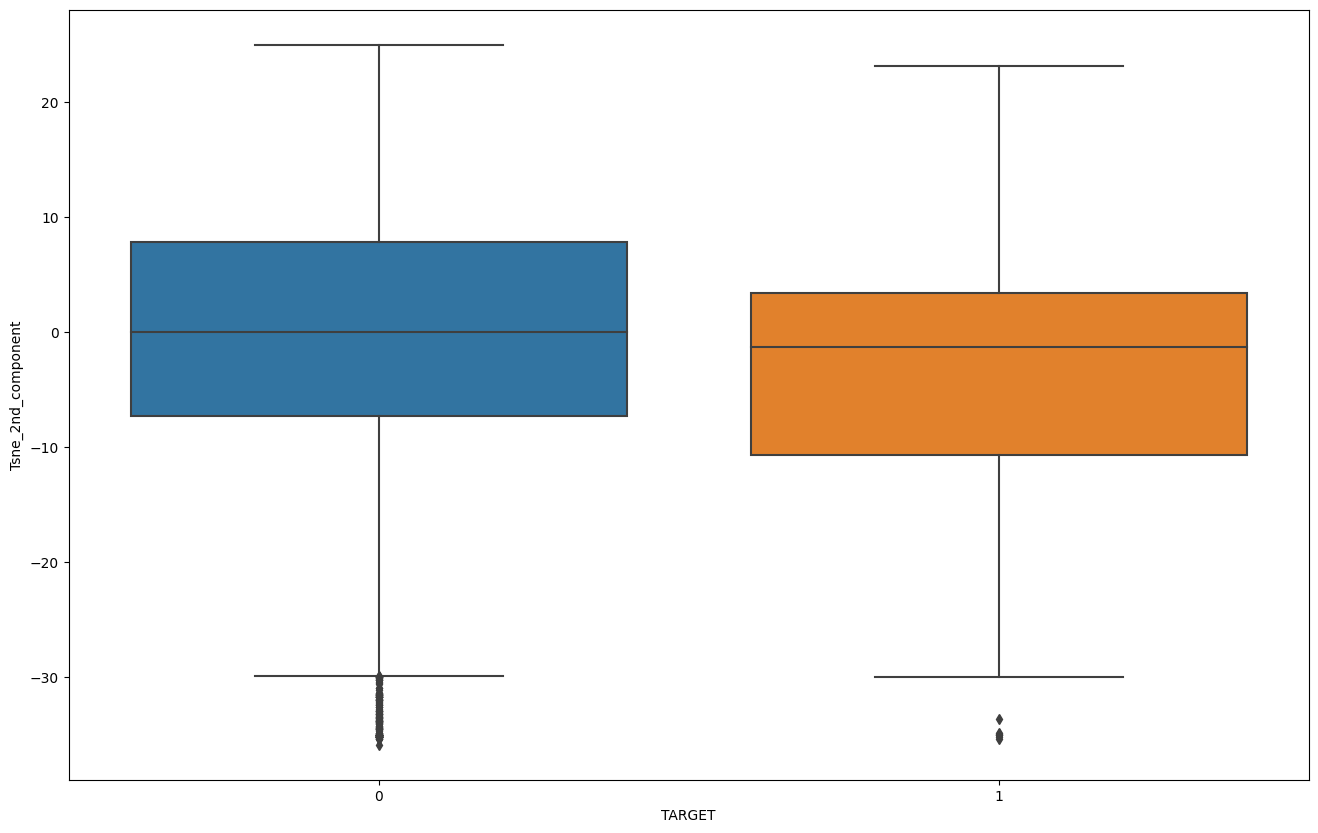

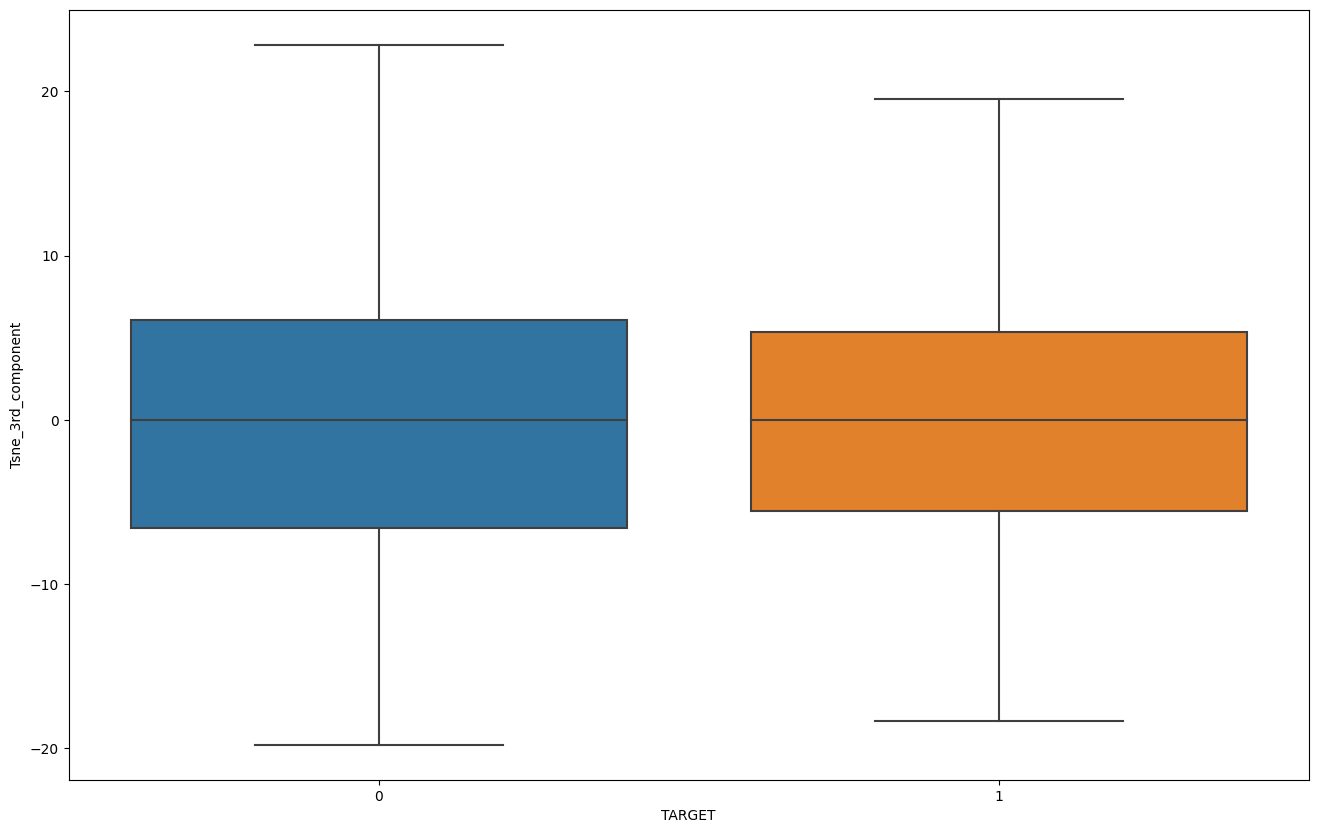

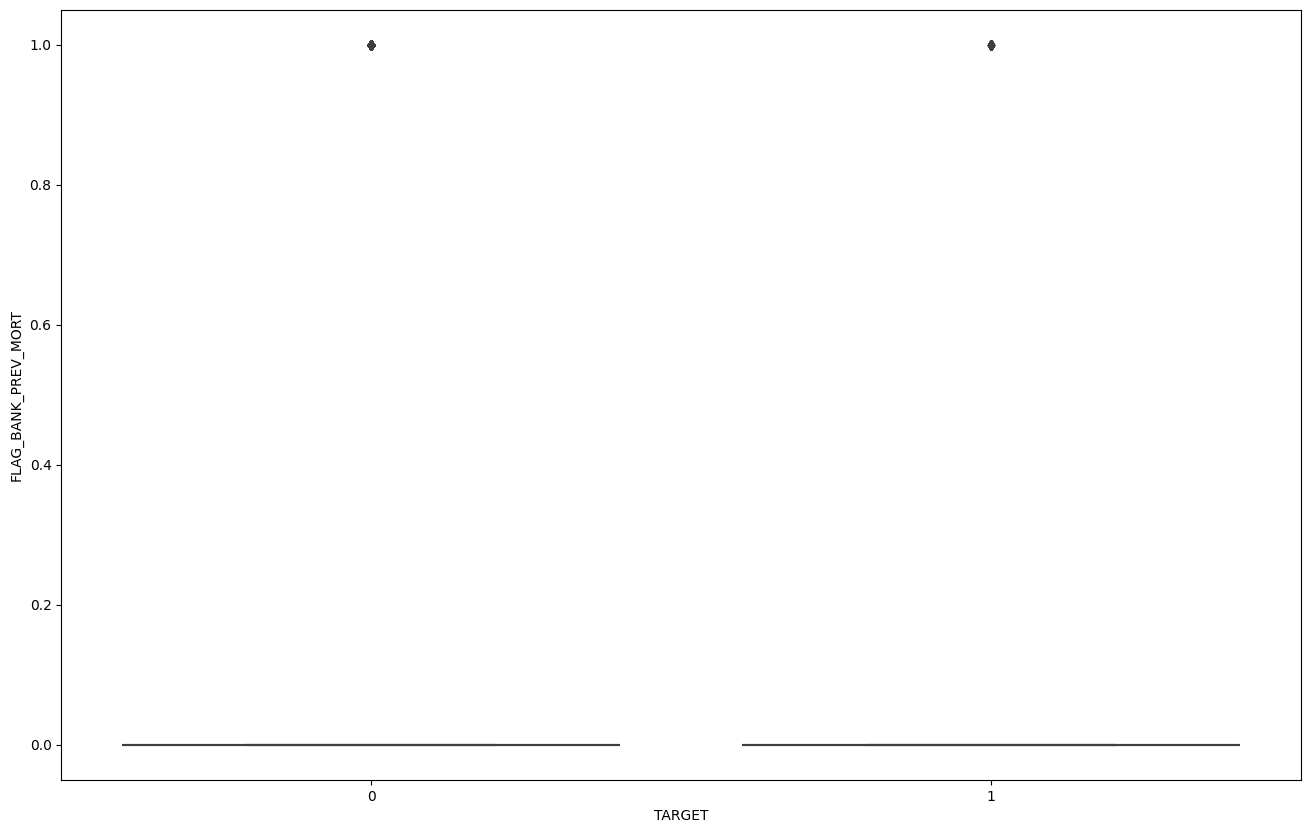

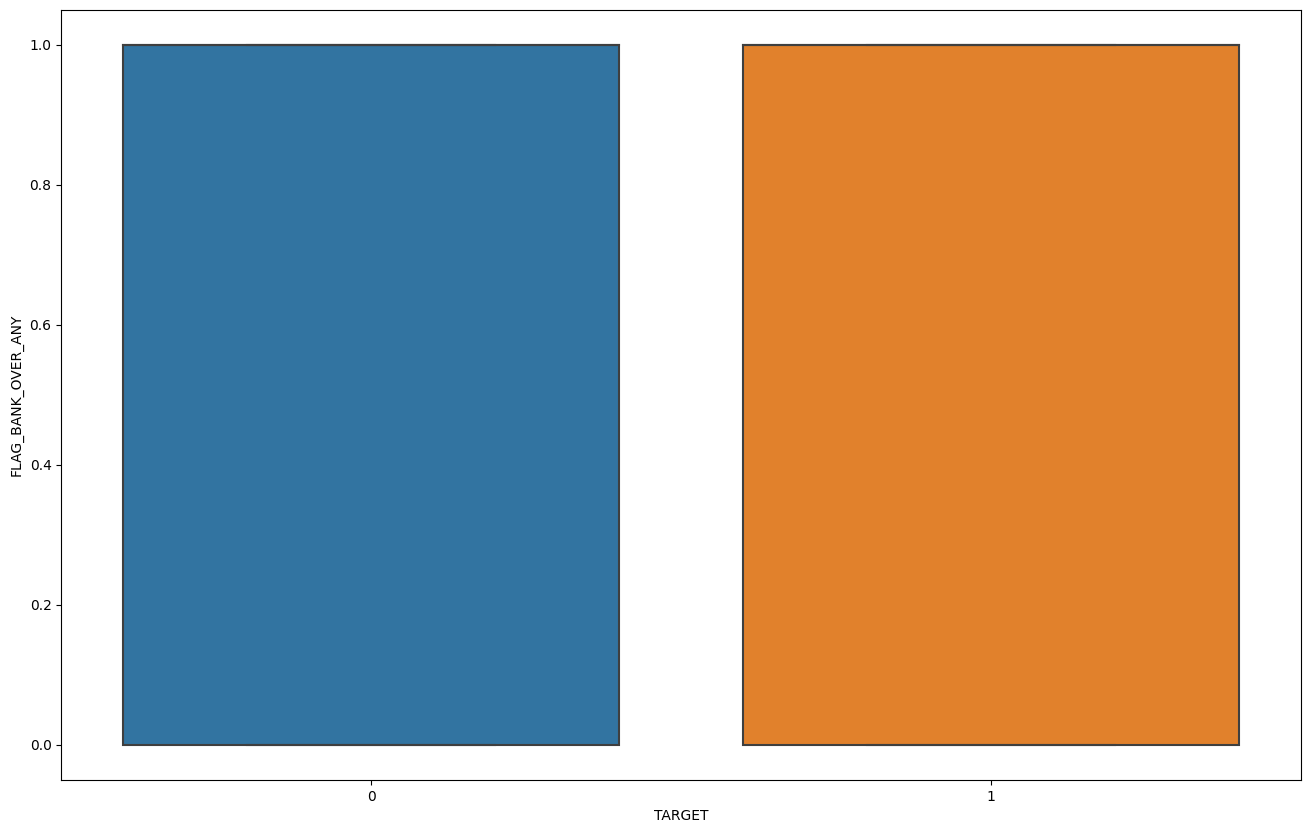

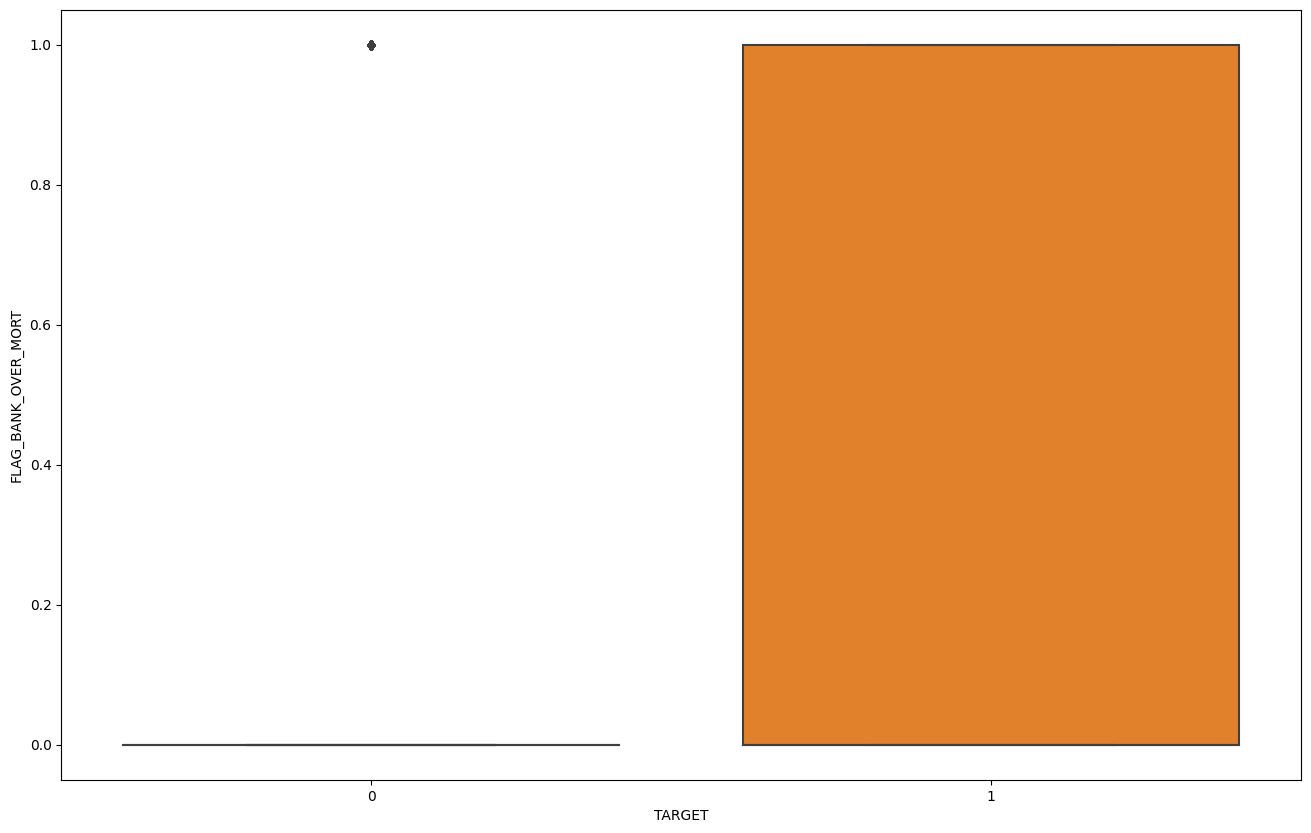

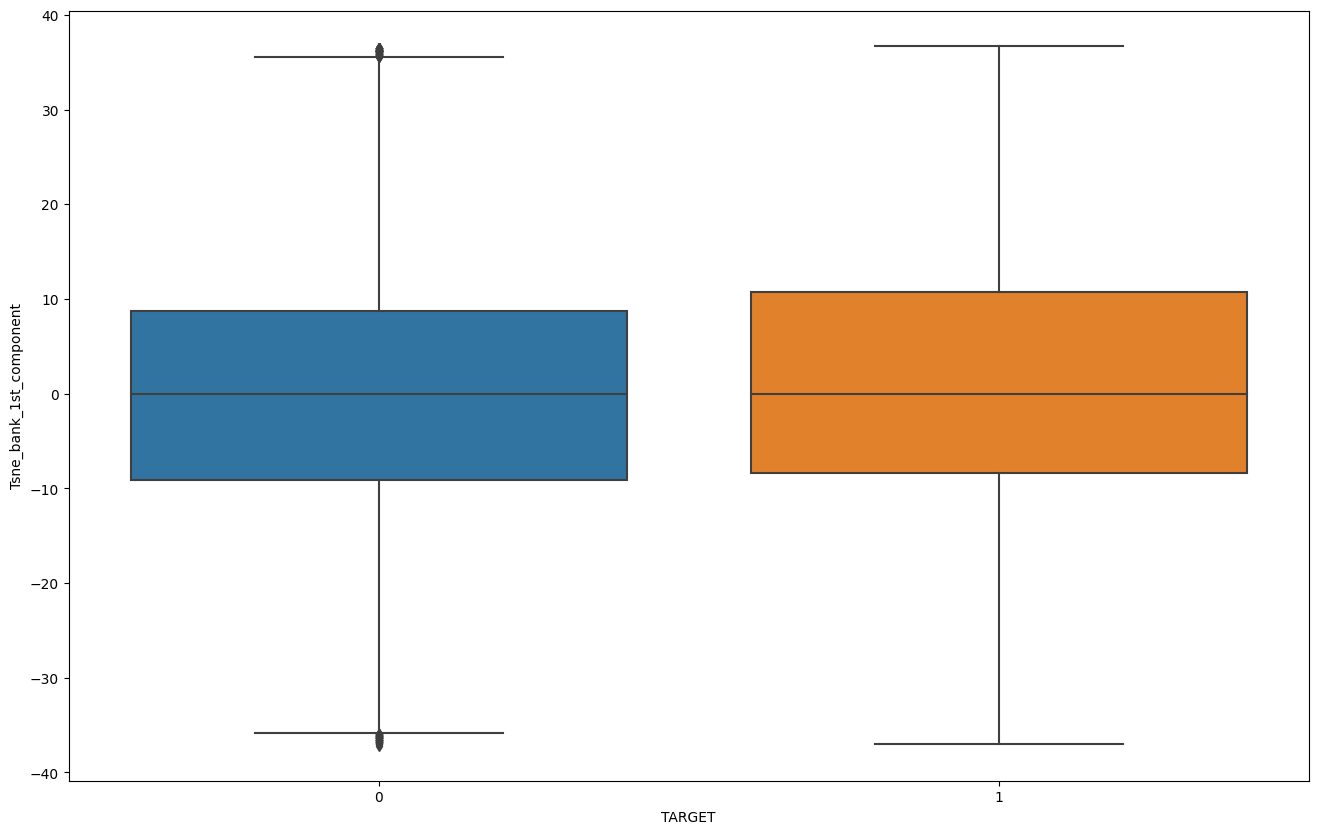

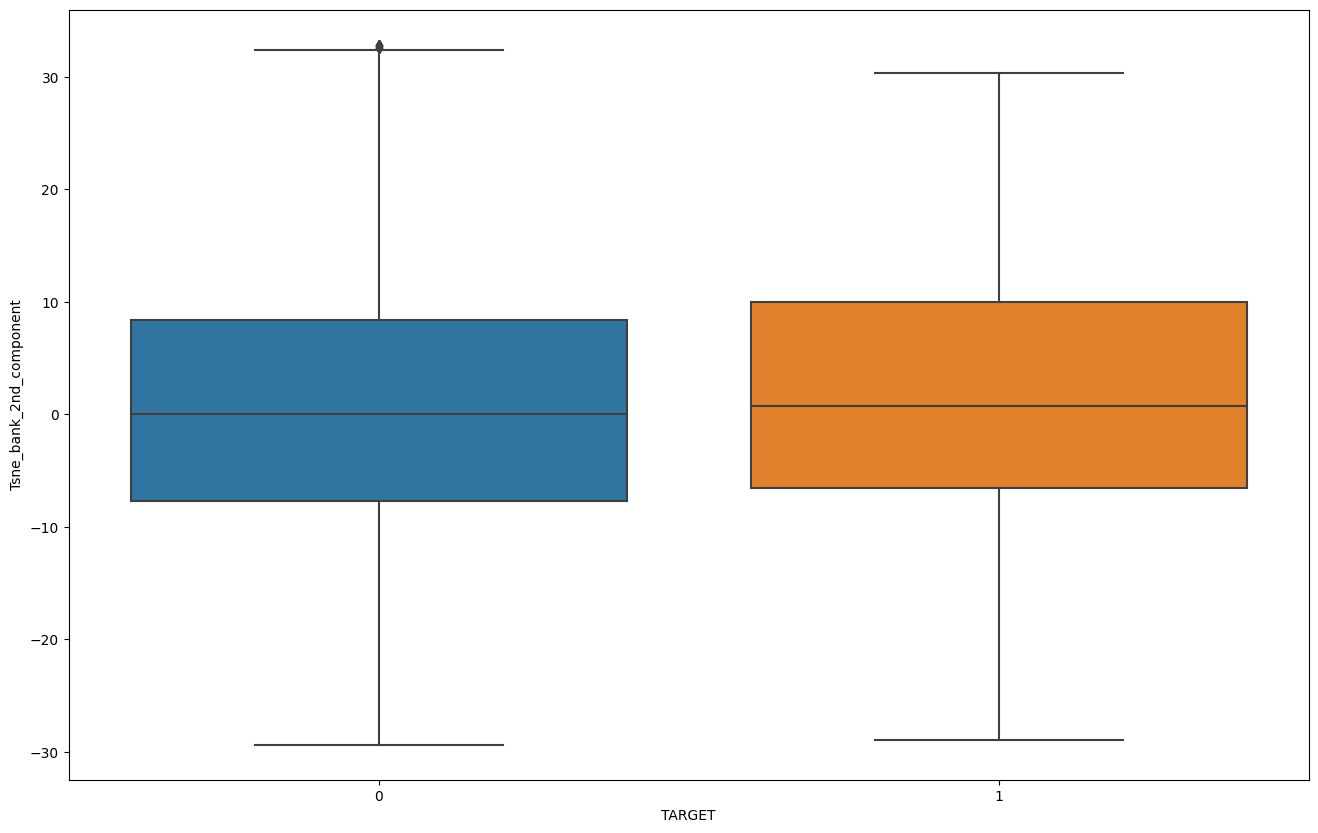

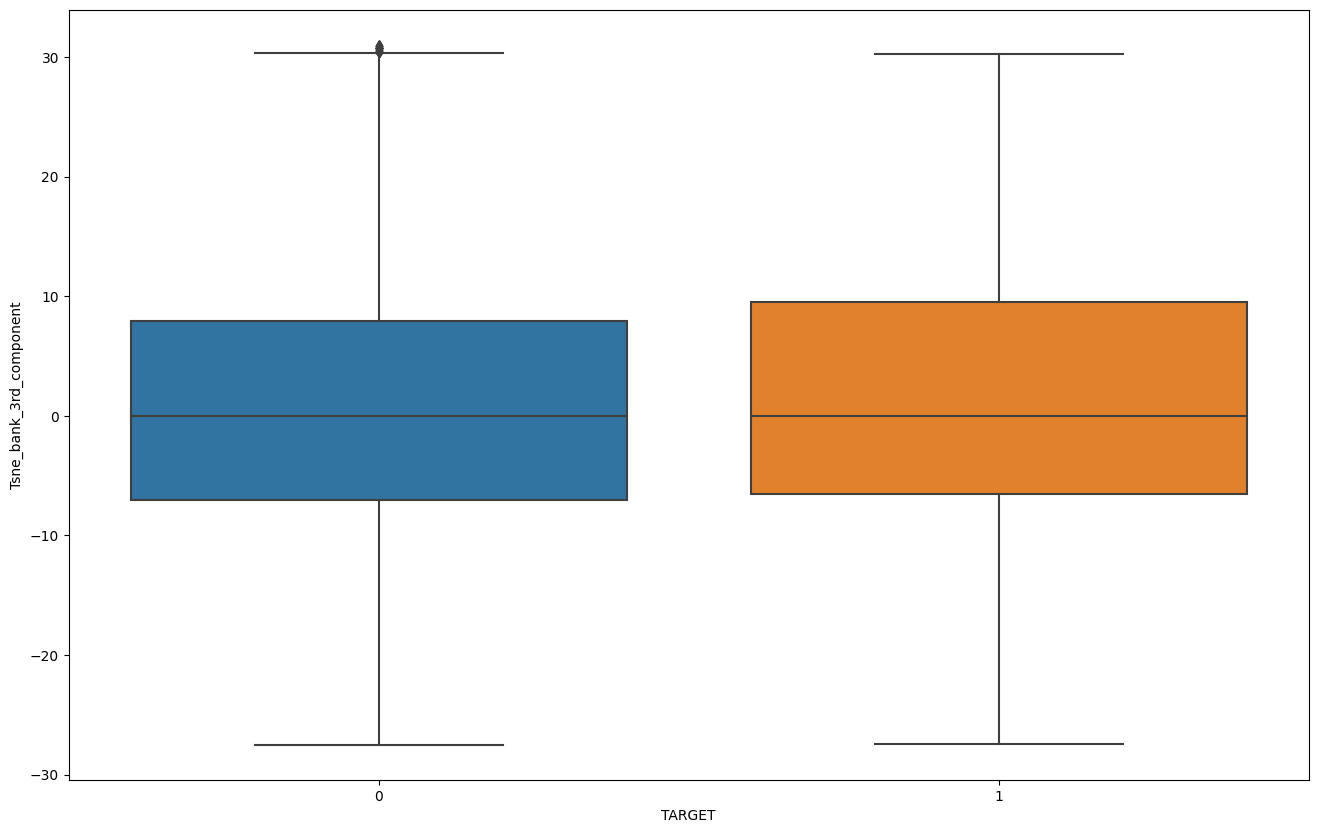

In [252]:
# Проверка влияния числовых признаков на таргет

for col in numeric_columns_full:
    
    fig = plt.figure()
    fig.set_size_inches(16, 10)
    
    sns.boxplot(y=col, x=data_mortgage_full['TARGET'].astype('category'), data=data_mortgage_full)
    
    plt.show()

## Подготовка бэйзлайна

In [239]:
# смотрим итоговые разспределения

numeric_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes!=object].columns

data_mortgage_full.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_PHONE,HOUR_APPR_PROCESS_START,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,CREDIT_LONGINESS,FLAG_BUREAU_PREV_LOANS,FLAG_BUREAU_PREV_MORT,Tsne_1st_component,Tsne_2nd_component,Tsne_3rd_component,FLAG_BANK_PREV_MORT,FLAG_BANK_OVER_ANY,FLAG_BANK_OVER_MORT,Tsne_bank_1st_component,Tsne_bank_2nd_component,Tsne_bank_3rd_component
count,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,2.490900e+04,2.490900e+04,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000,24909.000000
mean,277788.946445,0.052792,0.369264,0.465896,0.651050,0.412381,2.504686e+05,1.526539e+06,49778.374563,-16560.148701,49300.922879,-4924.244530,-3028.020836,4.572685,0.199326,0.321892,12.470954,0.208399,0.173552,-1066.270264,382.052845,0.884419,0.071701,0.418092,-0.056886,-0.159658,0.012526,0.622907,0.233650,-0.086718,-0.003481,0.406284
std,102588.510783,0.223623,0.482615,0.498846,0.476648,0.719155,1.785497e+05,2.933852e+05,15725.761079,3777.303741,128320.387500,3493.264607,1527.823373,8.526439,0.399501,0.467211,3.380115,0.406171,0.378731,869.577778,65.493911,0.319728,0.257997,17.376468,11.139217,8.114257,0.111217,0.484668,0.423161,14.964856,12.035234,10.894572
min,100003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,1.250118e+06,28813.500000,-25229.000000,-16836.000000,-22928.000000,-6207.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4128.000000,120.000000,0.000000,0.000000,-40.501060,-35.910194,-19.791050,0.000000,0.000000,0.000000,-37.176060,-29.350498,-27.503046
25%,189594.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.575000e+05,1.305000e+06,39469.500000,-19687.000000,-3433.000000,-7476.000000,-4333.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,-1682.000000,344.450559,1.000000,0.000000,-12.274991,-7.448915,-6.502544,0.000000,0.000000,0.000000,-9.041074,-7.659139,-6.983541
50%,278040.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.250000e+05,1.436850e+06,45333.000000,-16477.000000,-1652.000000,-4479.000000,-3327.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,-896.000000,409.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,366843.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.925000e+05,1.649844e+06,55507.500000,-13642.000000,-483.000000,-1906.000000,-1760.000000,7.000000,0.000000,1.000000,15.000000,0.000000,0.000000,-347.000000,435.069650,1.000000,0.000000,11.931463,7.591000,6.035555,0.000000,1.000000,0.000000,8.871770,8.474552,8.037127
max,456244.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.350000e+07,4.050000e+06,258025.500000,-7692.000000,365243.000000,0.000000,0.000000,65.000000,1.000000,1.000000,23.000000,1.000000,1.000000,0.000000,543.527144,1.000000,1.000000,35.428658,25.001486,22.848314,1.000000,1.000000,1.000000,36.738567,32.854053,31.021513


In [240]:
object_columns_full = data_mortgage_full.loc[:,data_mortgage_full.dtypes==object].columns

data_mortgage_full.describe(include='object')

,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
count,24909,24909,24909,24909,24909,24909,24909,24909
unique,8,8,5,5,6,19,7,58
top,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0,TUESDAY,Business Entity Type 3
freq,19761,10796,14279,19534,22716,7129,4379,6319


In [247]:
# разделяем датасет для экспериментов
df_tsne = data_mortgage_full.copy()
df_light = data_mortgage_full.loc[:,~data_mortgage_full.columns.str.contains('Tsne_', case=False)]

In [248]:
# MTE
for col in object_columns_full:
        mean_target = df_tsne.groupby(col)['TARGET'].mean()
        df_tsne[col] = df_tsne[col].map(mean_target)

for col in object_columns_full:
        mean_target = df_light.groupby(col)['TARGET'].mean()
        df_light[col] = df_light[col].map(mean_target)

## Эксперимент №1 Логистическая регрессия для выборки с TSNE компонентой

In [297]:
X = df_tsne.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = df_tsne["TARGET"]

In [298]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

In [299]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),
                 ('LR', LogisticRegression(class_weight='balanced'))])  # убираем регуляризацию

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(class_weight='balanced'))])

2024-06-27 22:50:07,392 - No handles with labels found to put in legend.


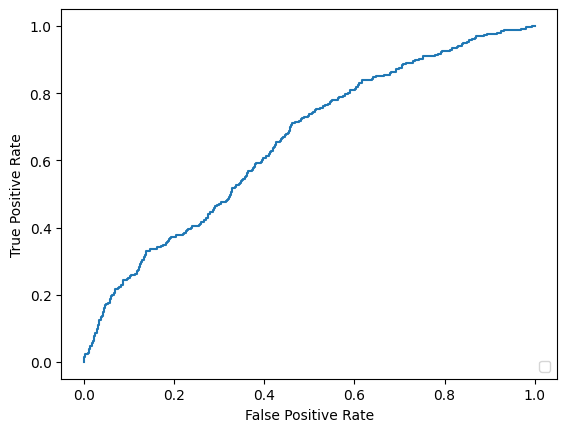

In [300]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [315]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.6556809650028829

In [301]:
from sklearn.metrics import classification_report


print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75      4727
           1       0.08      0.58      0.13       255

    accuracy                           0.62      4982
   macro avg       0.52      0.60      0.44      4982
weighted avg       0.92      0.62      0.72      4982



2024-06-28 19:03:37,666 - No handles with labels found to put in legend.


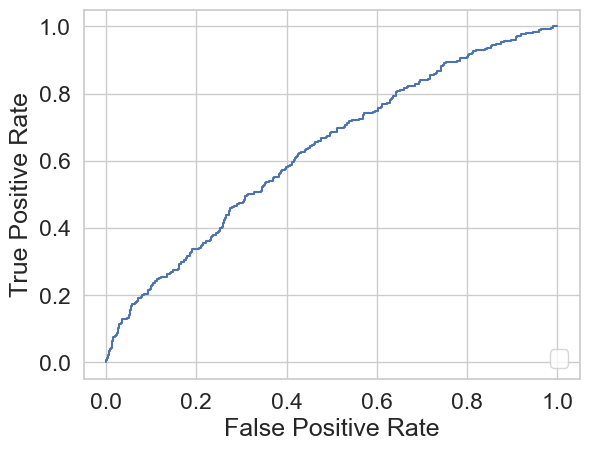

In [316]:
# Результаты без TSNE признаков
X = df_light.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = df_light["TARGET"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),
                 ('LR', LogisticRegression(class_weight='balanced'))])  # убираем регуляризацию

pipe.fit(X_train, y_train)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [317]:
from sklearn.metrics import auc

auc(fpr, tpr)

0.6299821218946644

In [318]:
from sklearn.metrics import classification_report


print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.60      0.74      4727
           1       0.07      0.57      0.13       255

    accuracy                           0.60      4982
   macro avg       0.52      0.59      0.44      4982
weighted avg       0.92      0.60      0.71      4982



## Эксперимент №2 Бустинг для выборки с TSNE компонентой

In [302]:
# Катбуст из финального проекта K/C

from catboost import CatBoostClassifier
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    depth=10,  # Modify this parameter as needed
    learning_rate=0.1,  # Modify this parameter as needed 
    custom_metric = ['F1', 'Precision', 'Recall', 'Accuracy'],
    eval_metric='AUC',  # Changed to PR AUC
    auto_class_weights='Balanced' ,
    verbose=50,  # Output the training process every 100 iterations
    random_seed=42
    
)

# Fit model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	test: 0.5504104	best: 0.5504104 (0)	total: 35.5ms	remaining: 3.52s
50:	test: 0.6273382	best: 0.6316082 (36)	total: 1.68s	remaining: 1.62s
99:	test: 0.6155867	best: 0.6316082 (36)	total: 3.35s	remaining: 0us

bestTest = 0.6316081584
bestIteration = 36

Shrink model to first 37 iterations.


In [303]:
catboost_model.get_best_score()

{'learn': {'Accuracy:use_weights=false': 0.9868018266673357,
  'Precision:use_weights=false': 0.8012093726379441,
  'Recall:use_weights=false': 1.0,
  'Accuracy:use_weights=true': 0.993030158556682,
  'Logloss': 0.15433869219687643,
  'Precision:use_weights=true': 0.9862519605788707,
  'Recall:use_weights=true': 1.0,
  'F1:use_weights=true': 0.9930784010820447,
  'F1:use_weights=false': 0.8896349139739824},
 'validation': {'Accuracy:use_weights=false': 0.9213167402649538,
  'Recall:use_weights=false': 0.5215686274509804,
  'Precision:use_weights=false': 0.09848484848484848,
  'Accuracy:use_weights=true': 0.573565279621182,
  'AUC': 0.6316081583892283,
  'Logloss': 0.6768285788923049,
  'Precision:use_weights=true': 0.6603762459548532,
  'Recall:use_weights=true': 0.5215686274509804,
  'F1:use_weights=true': 0.5261174812089039,
  'F1:use_weights=false': 0.1335379892555641}}

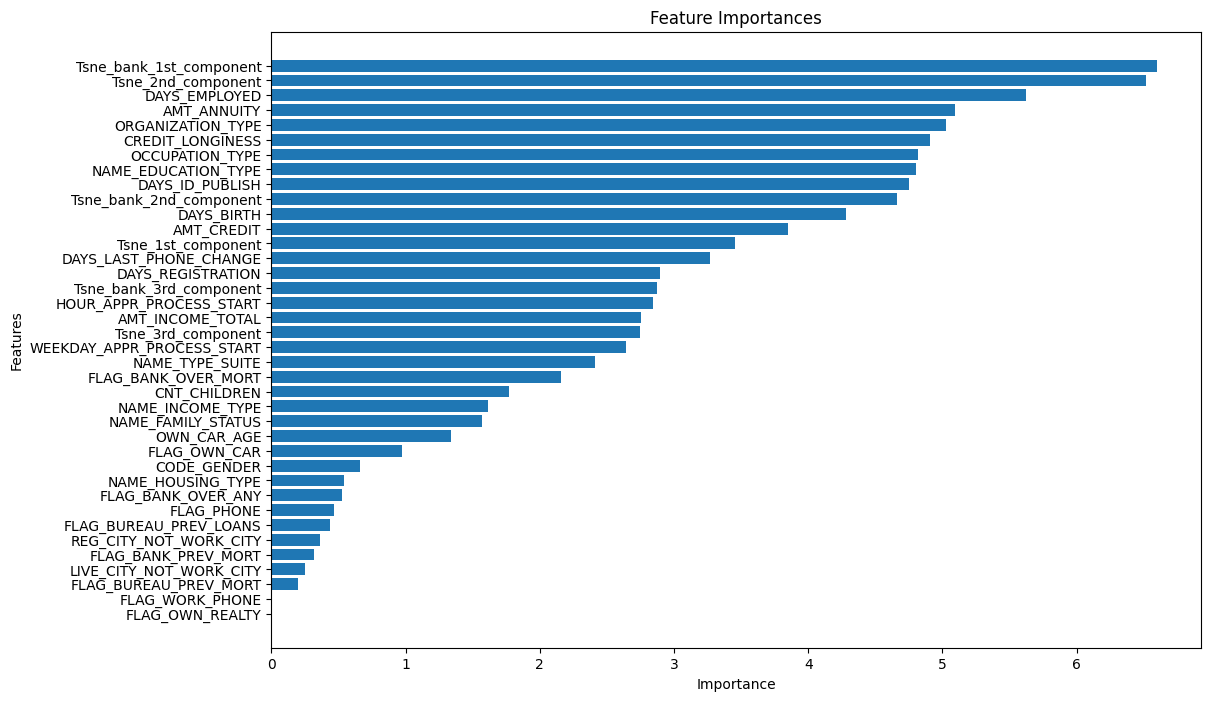

In [304]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [322]:
# Результаты без TSNE

# Результаты без TSNE признаков
X = df_light.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = df_light["TARGET"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

from catboost import CatBoostClassifier
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    depth=10,  # Modify this parameter as needed
    learning_rate=0.1,  # Modify this parameter as needed 
    custom_metric = ['F1', 'Precision', 'Recall', 'Accuracy'],
    eval_metric='AUC',  # Changed to PR AUC
    auto_class_weights='Balanced' ,
    verbose=50,  # Output the training process every 100 iterations
    random_seed=42
    
)

# Fit model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	test: 0.5337950	best: 0.5337950 (0)	total: 30.4ms	remaining: 3.01s
50:	test: 0.6078896	best: 0.6201529 (21)	total: 1.47s	remaining: 1.41s
99:	test: 0.6081833	best: 0.6201529 (21)	total: 2.81s	remaining: 0us

bestTest = 0.6201528972
bestIteration = 21

Shrink model to first 22 iterations.


In [320]:
catboost_model.get_best_score()

{'learn': {'Accuracy:use_weights=false': 0.9718974256034526,
  'Precision:use_weights=false': 0.654320987654321,
  'Recall:use_weights=false': 1.0,
  'Accuracy:use_weights=true': 0.9851592729724027,
  'Logloss': 0.19130352181274937,
  'Precision:use_weights=true': 0.9711741397187283,
  'Recall:use_weights=true': 1.0,
  'F1:use_weights=true': 0.9853762994854504,
  'F1:use_weights=false': 0.791044776119403},
 'validation': {'Accuracy:use_weights=false': 0.9056603773584906,
  'Recall:use_weights=false': 0.4823529411764706,
  'Precision:use_weights=false': 0.08171206225680934,
  'Accuracy:use_weights=true': 0.5673253252341895,
  'AUC': 0.6201528972071164,
  'Logloss': 0.6811075183061513,
  'Precision:use_weights=true': 0.6129752964994355,
  'Recall:use_weights=true': 0.4823529411764706,
  'F1:use_weights=true': 0.5042084369090488,
  'F1:use_weights=false': 0.12530915086562244}}

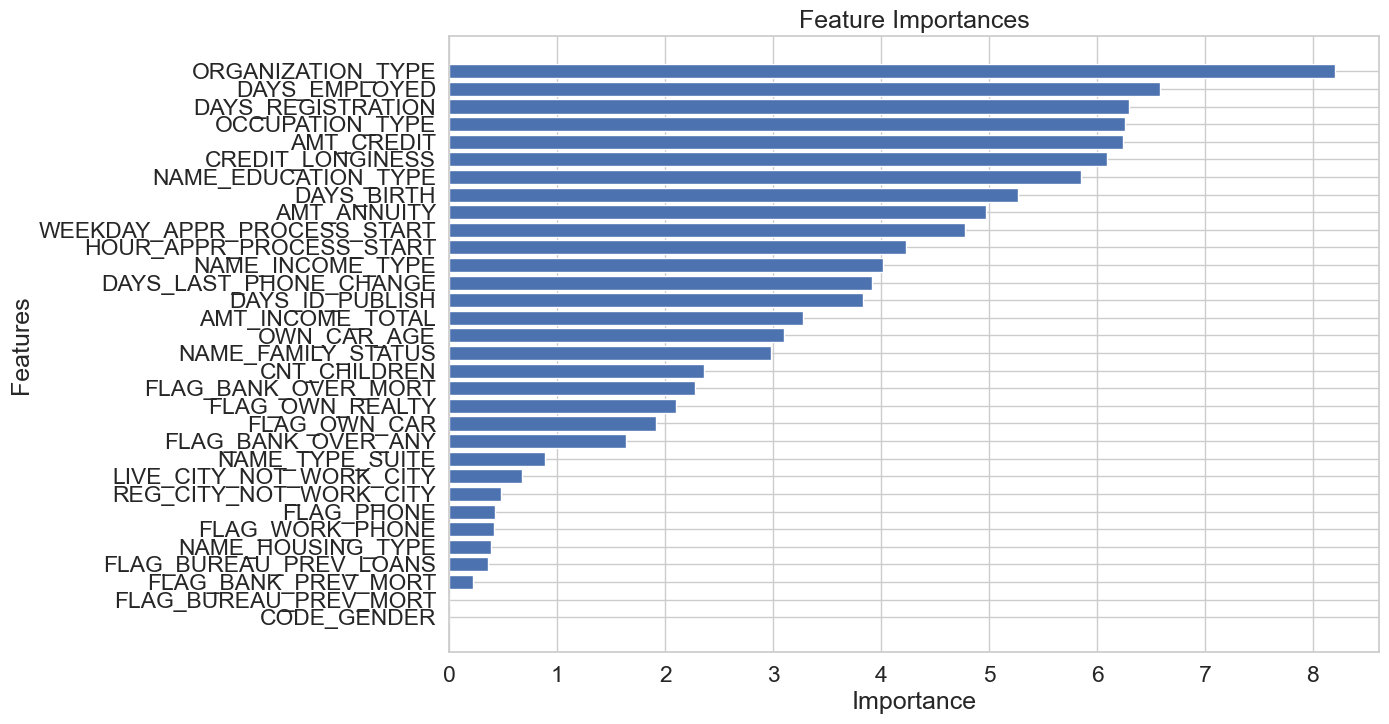

In [321]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Эксперимент №3 AutoML

In [305]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'


task = Task('binary')
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}


In [306]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [309]:
train_data, test_data = train_test_split(
    df_tsne,
    test_size=TEST_SIZE,
    stratify=df_tsne[TARGET_NAME],
    random_state=RANDOM_STATE
)

In [313]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)



In [314]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[22:54:12] Stdout logging level is INFO.
[22:54:12] Task: binary

[22:54:12] Start automl preset with listed constraints:
[22:54:12] - time: 300.00 seconds
[22:54:12] - CPU: 4 cores
[22:54:12] - memory: 16 GB

[22:54:12] Train data shape: (19927, 40)

[22:54:12] Layer 1 train process start. Time left 299.49 secs
[22:54:14] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:54:16] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6750407675068617
[22:54:16] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:54:16] Time left 296.04 secs

[22:54:17] Selector_LightGBM fitting and predicting completed
[22:54:19] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:54:28] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.6609426384307405
[22:54:28] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:54:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 25.24 secs
2024-06-27 22:54:28,633 - A new study created in m

In [323]:
# Результаты без TSNE

train_data, test_data = train_test_split(
    df_light,
    test_size=TEST_SIZE,
    stratify=df_tsne[TARGET_NAME],
    random_state=RANDOM_STATE
)

In [324]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[19:06:50] Stdout logging level is INFO.
[19:06:50] Task: binary

[19:06:50] Start automl preset with listed constraints:
[19:06:50] - time: 300.00 seconds
[19:06:50] - CPU: 4 cores
[19:06:50] - memory: 16 GB

[19:06:50] Train data shape: (19927, 34)

[19:06:58] Layer 1 train process start. Time left 291.49 secs
[19:06:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:07:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6595757560496562
[19:07:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:07:00] Time left 289.62 secs

[19:07:01] Selector_LightGBM fitting and predicting completed
[19:07:02] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:07:10] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.6264102434970917
[19:07:10] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:07:10] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 2.65 secs
2024-06-28 19:07:10,768 - A new study created in me